In [1]:
! pip install tqdm shap torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00


In [2]:
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.0 MB/s eta 0:00:00


In [3]:
# ---------- Fast, resumable MDN seed-ensembling with stability features ----------
# Optimized for A100/PyTorch 2.0+ with model compilation, stability features (LR schedule, clipping),
# and full output saving for component analysis.

import os, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ---------------- User configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized" 
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
os.makedirs(EN_DIR, exist_ok=True)

N_SEEDS = 10
SEEDS = [42 + i for i in range(N_SEEDS)]
BATCH = 256
MAX_EPOCHS = 300
PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 8
PIN_MEMORY = True if DEVICE.type == "cuda" else False
RESUME_IF_EXISTS = True
N_COMPONENTS = 5

if DEVICE.type == "cuda":
    torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

print("Device:", DEVICE)

# ---------------- Data Loading ----------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# ---------------- Physics feature engineering ----------------
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))

log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# ---------------- 29 training features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# ---------------- Split by reaction ----------------
train_file = Path(OUTDIR_BASE)/"train_reactions.csv"
val_file   = Path(OUTDIR_BASE)/"val_reactions.csv"
test_file  = Path(OUTDIR_BASE)/"test_reactions.csv"

if train_file.exists():
    train_reacts = pd.read_csv(train_file)["Reaction"].values
    val_reacts   = pd.read_csv(val_file)["Reaction"].values
    test_reacts  = pd.read_csv(test_file)["Reaction"].values
else:
    reactions = df["Reaction"].unique()
    np.random.seed(42); np.random.shuffle(reactions)
    n = len(reactions)
    train_reacts = reactions[:int(0.7*n)]
    val_reacts   = reactions[int(0.7*n):int(0.8*n)]
    test_reacts  = reactions[int(0.8*n):]
    pd.DataFrame({"Reaction":train_reacts}).to_csv(train_file,index=False)
    pd.DataFrame({"Reaction":val_reacts}).to_csv(val_file,index=False)
    pd.DataFrame({"Reaction":test_reacts}).to_csv(test_file,index=False)

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

test_rows = df.loc[test_mask].reset_index(drop=True)

# ---------------- Prepare training data ----------------
X_train_full = df.loc[train_mask|val_mask, features_train].values.astype(np.float32)
y_train_full = df.loc[train_mask|val_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

scaler = StandardScaler().fit(X_train_full)
joblib.dump(scaler, os.path.join(EN_DIR,"scaler.pkl"))

X_train_full_s = scaler.transform(X_train_full)
X_test_s       = scaler.transform(X_test)

# ---------------- MDN definition ----------------
class MDN(nn.Module):
    def __init__(self,in_dim,hidden=64,n_components=N_COMPONENTS,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden,hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.fc_pi = nn.Linear(hidden,n_components)
        self.fc_mu = nn.Linear(hidden,n_components)
        self.fc_sigma = nn.Linear(hidden,n_components)
    def forward(self,x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h),1)
        mu = self.fc_mu(h)
        sigma = torch.nn.functional.softplus(self.fc_sigma(h))+1e-6
        return pi,mu,sigma

def mdn_loss(pi,mu,sigma,y):
    yexp = y.repeat(1,mu.shape[1])
    logg = -0.5*((yexp-mu)/sigma)**2 - torch.log(sigma) - 0.5*np.log(2*np.pi)
    logmix = torch.logsumexp(torch.log(pi+1e-12)+logg,dim=1)
    return -logmix.mean()

def mdn_predict_mode(pi,mu,sigma):
    idx = torch.argmax(pi,1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def seed_worker(worker_id):
    ws = torch.initial_seed() % 2**32
    np.random.seed(ws); random.seed(ws)

def make_loader(X,y,batch=BATCH,shuffle=True):
    return DataLoader(
        TensorDataset(torch.tensor(X),torch.tensor(y)),
        batch_size=batch, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
        worker_init_fn=seed_worker
    )

# ---------------- Training ----------------
all_preds = []

for s in SEEDS:
    print("\n=== Seed", s, "===")
    seed_dir = os.path.join(EN_DIR,f"seed_{s}")
    os.makedirs(seed_dir,exist_ok=True)

    ckpt_path = os.path.join(seed_dir,"mdn_best.pth")
    dist_path = os.path.join(seed_dir,"mdn_test_components.npz")

    torch.manual_seed(s); np.random.seed(s); random.seed(s)

    n_all = len(X_train_full_s)
    perm = np.random.permutation(n_all)
    val_size = max(int(0.05*n_all),1)
    val_idx = perm[:val_size]
    tr_idx  = perm[val_size:]

    tr_loader = make_loader(X_train_full_s[tr_idx],y_train_full[tr_idx])
    val_loader= make_loader(X_train_full_s[val_idx],y_train_full[val_idx],shuffle=False)

    model = MDN(X_train_full_s.shape[1], hidden=64, n_components=N_COMPONENTS).to(DEVICE)

    if DEVICE.type=="cuda" and torch.__version__.startswith("2."):
        print("Compiling model...")
        model = torch.compile(model)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

    # AMP
    scaler_amp = torch.amp.GradScaler('cuda') if DEVICE.type=="cuda" else None

    best_val=float("inf"); patience_ctr=0

    # resume?
    if RESUME_IF_EXISTS and os.path.exists(ckpt_path):
        try:
            saved=torch.load(ckpt_path,map_location="cpu")
            model.load_state_dict(saved["state"])
            best_val=saved["best_val"]
            print("Resumed from",ckpt_path)
        except:
            print("Resume failed. Training fresh.")

    # --------- Train ---------
    for epoch in range(MAX_EPOCHS):
        model.train()
        epoch_loss=0.0
        pbar=tqdm(tr_loader,desc=f"seed{s} epoch{epoch}",leave=False)

        for xb,yb in pbar:
            xb=xb.to(DEVICE).float(); yb=yb.to(DEVICE).float()
            opt.zero_grad()

            if DEVICE.type=="cuda":
                with torch.amp.autocast(device_type='cuda'):
                    pi,mu,sigma=model(xb)
                    loss=mdn_loss(pi,mu,sigma,yb)

                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(),4.0)
                scaler_amp.step(opt)
                scaler_amp.update()

            else:
                pi,mu,sigma=model(xb)
                loss=mdn_loss(pi,mu,sigma,yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(),4.0)
                opt.step()

            epoch_loss+=loss.item()*xb.size(0)
            pbar.set_postfix({"loss":f"{epoch_loss/(pbar.n+1e-12):.4f}"})

        epoch_loss/=len(tr_loader.dataset)

        # validation
        model.eval()
        val_loss=0.0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb=xb.to(DEVICE).float(); yb=yb.to(DEVICE).float()
                pi,mu,sigma=model(xb)
                val_loss+=mdn_loss(pi,mu,sigma,yb).item()*xb.size(0)
        val_loss/=len(val_loader.dataset)

        scheduler.step(val_loss)

        tqdm.write(f"[seed{s}] epoch {epoch} train={epoch_loss:.4f} val={val_loss:.4f}")

        # early stop
        if val_loss < best_val - 1e-9:
            best_val = val_loss
            torch.save({"state":model.state_dict(),"best_val":best_val}, ckpt_path)
            patience_ctr=0
        else:
            patience_ctr+=1

        if patience_ctr >= PATIENCE:
            print(f"[seed{s}] Early stop at epoch {epoch}")
            break

    # ---------------- Test inference ----------------
    print(f"[seed{s}] Loading best model...")
    saved=torch.load(ckpt_path,map_location=DEVICE)
    model.load_state_dict(saved["state"])
    model.eval()

    test_loader = make_loader(X_test_s,y_test,shuffle=False)

    preds_list=[]; pi_list=[]; mu_list=[]; sigma_list=[]

    with torch.no_grad():
        for xb,_ in tqdm(test_loader,desc=f"seed{s} test",leave=False):
            xb=xb.to(DEVICE).float()
            pi,mu,sigma=model(xb)

            pred = mdn_predict_mode(pi,mu,sigma)
            preds_list.append(pred.cpu().numpy())

            pi_list.append(pi.cpu().numpy())
            mu_list.append(mu.cpu().numpy())
            sigma_list.append(sigma.cpu().numpy())

    preds_arr=np.vstack(preds_list).flatten()
    all_preds.append(preds_arr)

    # save test components
    np.savez(dist_path,
        pi=np.vstack(pi_list),
        mu=np.vstack(mu_list),
        sigma=np.vstack(sigma_list)
    )

    print(f"[seed{s}] Test metrics: RMSE={np.sqrt(mean_squared_error(y_test.flatten(),preds_arr)):.4f}")

    # ---------------------------------------------------------------------
    #  NEW: FULL-DATASET INFERENCE FOR SHAP ANALYSIS
    # ---------------------------------------------------------------------
    print(f"[seed{s}] Computing FULL dataset components...")

    X_all = df[features_train].values.astype(np.float32)
    X_all_s = scaler.transform(X_all)

    full_loader = make_loader(X_all_s, np.zeros((len(X_all_s),1)), shuffle=False)

    pi_all=[]; mu_all=[]; sigma_all=[]

    with torch.no_grad():
        for xb,_ in tqdm(full_loader,desc=f"seed{s} full-data",leave=False):
            xb = xb.to(DEVICE).float()
            pi,mu,sigma = model(xb)
            pi_all.append(pi.cpu().numpy())
            mu_all.append(mu.cpu().numpy())
            sigma_all.append(sigma.cpu().numpy())

    pi_all=np.vstack(pi_all)
    mu_all=np.vstack(mu_all)
    sigma_all=np.vstack(sigma_all)

    np.savez(
        os.path.join(seed_dir,"mdn_all_components.npz"),
        pi=pi_all,
        mu=mu_all,
        sigma=sigma_all
    )

    print(f"[seed{s}] Saved FULL DATA → mdn_all_components.npz")

# ---------------- Ensemble results ----------------
all_preds_arr=np.vstack(all_preds)
delta_ens=all_preds_arr.mean(axis=0)

test_local=test_rows.copy()
eta_test=test_local["eta"].values
log10_S_cal_test=test_local["log10_S_cal"].values

log10_S_pred = log10_S_cal_test + delta_ens
log10_sigma_pred = (
    log10_S_pred
    - np.log10(np.clip(test_local["E c.m."].values,1e-30,np.inf))
    - (2*np.pi*eta_test)/LN10
)
sigma_pred = 10**(log10_sigma_pred)

sigma_true = test_local["σ"].values
delta_true = test_local["delta_log10_S"].values

print("\n=== Ensemble Final Results ===")
print("RMSE(delta):", np.sqrt(mean_squared_error(delta_true,delta_ens)))
print("R2(delta):  ", r2_score(delta_true,delta_ens))
print("R2(logσ):   ", r2_score(np.log10(sigma_true+1e-30),log10_sigma_pred))

pd.DataFrame({
    "Reaction":test_local["Reaction"],
    "E c.m.":test_local["E c.m."],
    "sigma_true":sigma_true,
    "sigma_pred":sigma_pred,
    "delta_ens":delta_ens
}).to_csv(os.path.join(EN_DIR,"ensemble_predictions_final.csv"),index=False)

print("DONE")


Device: cpu

=== Seed 42 ===


seed42 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 0 train=0.5505 val=0.5392


seed42 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 1 train=0.3797 val=0.3664


seed42 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 2 train=0.1867 val=0.1812


seed42 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 3 train=0.0826 val=0.0394


seed42 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 4 train=-0.0041 val=0.0030


seed42 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 5 train=-0.0720 val=-0.0848


seed42 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 6 train=-0.1245 val=-0.0968


seed42 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 7 train=-0.1849 val=-0.1202


seed42 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 8 train=-0.2156 val=-0.1933


seed42 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 9 train=-0.2516 val=-0.2031


seed42 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 10 train=-0.2946 val=-0.2002


seed42 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 11 train=-0.3236 val=-0.2546


seed42 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 12 train=-0.3650 val=-0.2878


seed42 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 13 train=-0.3718 val=-0.2833


seed42 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 14 train=-0.3899 val=-0.3211


seed42 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 15 train=-0.4346 val=-0.3552


seed42 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 16 train=-0.4530 val=-0.3999


seed42 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 17 train=-0.4794 val=-0.4208


seed42 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 18 train=-0.5151 val=-0.4306


seed42 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 19 train=-0.5004 val=-0.4766


seed42 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 20 train=-0.5445 val=-0.4759


seed42 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 21 train=-0.5241 val=-0.5252


seed42 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 22 train=-0.5665 val=-0.5557


seed42 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 23 train=-0.5901 val=-0.5377


seed42 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 24 train=-0.5949 val=-0.5719


seed42 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 25 train=-0.5641 val=-0.5333


seed42 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 26 train=-0.5936 val=-0.5795


seed42 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 27 train=-0.6101 val=-0.6096


seed42 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 28 train=-0.5928 val=-0.5829


seed42 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 29 train=-0.6250 val=-0.6250


seed42 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 30 train=-0.6492 val=-0.6347


seed42 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 31 train=-0.6802 val=-0.6590


seed42 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 32 train=-0.6694 val=-0.6802


seed42 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 33 train=-0.7073 val=-0.7085


seed42 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 34 train=-0.6947 val=-0.7015


seed42 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 35 train=-0.7145 val=-0.7189


seed42 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 36 train=-0.7234 val=-0.7576


seed42 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 37 train=-0.7368 val=-0.7549


seed42 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 38 train=-0.7533 val=-0.7761


seed42 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 39 train=-0.7628 val=-0.7739


seed42 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 40 train=-0.7737 val=-0.7642


seed42 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 41 train=-0.7762 val=-0.7953


seed42 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 42 train=-0.8063 val=-0.8194


seed42 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 43 train=-0.8148 val=-0.8224


seed42 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 44 train=-0.7910 val=-0.8110


seed42 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 45 train=-0.7923 val=-0.8045


seed42 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 46 train=-0.8187 val=-0.8099


seed42 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 47 train=-0.8221 val=-0.8337


seed42 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 48 train=-0.8131 val=-0.8370


seed42 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 49 train=-0.8248 val=-0.8377


seed42 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 50 train=-0.8045 val=-0.8150


seed42 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 51 train=-0.8101 val=-0.8545


seed42 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 52 train=-0.8418 val=-0.8554


seed42 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 53 train=-0.8172 val=-0.8383


seed42 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 54 train=-0.8497 val=-0.8666


seed42 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 55 train=-0.8652 val=-0.8955


seed42 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 56 train=-0.8474 val=-0.8871


seed42 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 57 train=-0.8924 val=-0.8976


seed42 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 58 train=-0.8847 val=-0.8891


seed42 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 59 train=-0.8943 val=-0.8701


seed42 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 60 train=-0.8940 val=-0.9310


seed42 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 61 train=-0.9011 val=-0.9159


seed42 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 62 train=-0.9074 val=-0.9290


seed42 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 63 train=-0.9036 val=-0.9246


seed42 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 64 train=-0.9134 val=-0.9278


seed42 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 65 train=-0.9063 val=-0.9417


seed42 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 66 train=-0.9380 val=-0.9499


seed42 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 67 train=-0.9410 val=-0.9405


seed42 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 68 train=-0.9012 val=-0.9320


seed42 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 69 train=-0.9295 val=-0.9623


seed42 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 70 train=-0.9512 val=-0.9506


seed42 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 71 train=-0.9223 val=-0.9163


seed42 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 72 train=-0.9387 val=-0.9510


seed42 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 73 train=-0.9384 val=-0.9759


seed42 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 74 train=-0.9568 val=-0.9494


seed42 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 75 train=-0.9242 val=-0.9573


seed42 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 76 train=-0.9514 val=-0.9516


seed42 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 77 train=-0.9454 val=-0.9539


seed42 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 78 train=-0.9556 val=-0.9741


seed42 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 79 train=-0.9636 val=-0.9625


seed42 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 80 train=-0.9471 val=-0.9859


seed42 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 81 train=-0.9639 val=-0.9938


seed42 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 82 train=-0.9758 val=-0.9968


seed42 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 83 train=-0.9638 val=-0.9933


seed42 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 84 train=-0.9905 val=-0.9792


seed42 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 85 train=-0.9850 val=-0.9858


seed42 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 86 train=-0.9563 val=-0.9811


seed42 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 87 train=-0.9575 val=-0.9975


seed42 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 88 train=-0.9650 val=-0.9866


seed42 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 89 train=-0.9896 val=-1.0141


seed42 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 90 train=-0.9686 val=-1.0090


seed42 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 91 train=-0.9904 val=-0.9825


seed42 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 92 train=-0.9806 val=-1.0036


seed42 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 93 train=-0.9875 val=-1.0133


seed42 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 94 train=-0.9949 val=-0.9901


seed42 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 95 train=-0.9921 val=-1.0095


seed42 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 96 train=-0.9856 val=-1.0305


seed42 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 97 train=-0.9895 val=-1.0257


seed42 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 98 train=-1.0198 val=-0.9854


seed42 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 99 train=-1.0122 val=-0.9859


seed42 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 100 train=-1.0103 val=-1.0059


seed42 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 101 train=-1.0024 val=-0.9994


seed42 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 102 train=-0.9981 val=-1.0103


seed42 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 103 train=-1.0151 val=-1.0005


seed42 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 104 train=-1.0145 val=-1.0321


seed42 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 105 train=-1.0316 val=-1.0228


seed42 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 106 train=-1.0391 val=-1.0032


seed42 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 107 train=-1.0258 val=-1.0147


seed42 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 108 train=-1.0172 val=-1.0269


seed42 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 109 train=-1.0366 val=-1.0309


seed42 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 110 train=-1.0318 val=-1.0392


seed42 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 111 train=-1.0418 val=-1.0366


seed42 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 112 train=-1.0475 val=-1.0425


seed42 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 113 train=-1.0465 val=-1.0334


seed42 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 114 train=-1.0314 val=-1.0351


seed42 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 115 train=-1.0508 val=-1.0532


seed42 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 116 train=-1.0234 val=-1.0425


seed42 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 117 train=-1.0629 val=-1.0493


seed42 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 118 train=-1.0675 val=-1.0713


seed42 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 119 train=-1.0074 val=-1.0352


seed42 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 120 train=-1.0624 val=-1.0614


seed42 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 121 train=-1.0452 val=-1.0600


seed42 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 122 train=-1.0564 val=-1.0490


seed42 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 123 train=-1.0596 val=-1.0723


seed42 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 124 train=-1.0528 val=-1.0734


seed42 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 125 train=-1.0741 val=-1.1001


seed42 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 126 train=-1.0587 val=-1.0635


seed42 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 127 train=-1.0613 val=-1.0501


seed42 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 128 train=-1.0685 val=-1.0853


seed42 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 129 train=-1.0711 val=-1.0976


seed42 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 130 train=-1.0453 val=-1.0679


seed42 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 131 train=-1.0347 val=-1.0796


seed42 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 132 train=-1.0958 val=-1.0950


seed42 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 133 train=-1.0624 val=-1.0544


seed42 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 134 train=-1.0771 val=-1.0763


seed42 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 135 train=-1.0658 val=-1.0994


seed42 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 136 train=-1.0869 val=-1.0989


seed42 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 137 train=-1.0710 val=-1.0839


seed42 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 138 train=-1.0949 val=-1.1009


seed42 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 139 train=-1.1119 val=-1.0943


seed42 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 140 train=-1.1119 val=-1.0776


seed42 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 141 train=-1.1096 val=-1.0975


seed42 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 142 train=-1.1400 val=-1.1104


seed42 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 143 train=-1.1171 val=-1.0976


seed42 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 144 train=-1.0996 val=-1.1047


seed42 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 145 train=-1.1260 val=-1.1178


seed42 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 146 train=-1.1143 val=-1.1061


seed42 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 147 train=-1.1411 val=-1.1197


seed42 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 148 train=-1.1336 val=-1.1209


seed42 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 149 train=-1.1309 val=-1.1149


seed42 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 150 train=-1.1263 val=-1.1146


seed42 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 151 train=-1.1160 val=-1.1225


seed42 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 152 train=-1.1234 val=-1.1062


seed42 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 153 train=-1.1144 val=-1.1103


seed42 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 154 train=-1.1285 val=-1.1188


seed42 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 155 train=-1.1136 val=-1.1154


seed42 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 156 train=-1.1131 val=-1.1134


seed42 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 157 train=-1.1469 val=-1.1224


seed42 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 158 train=-1.1266 val=-1.1306


seed42 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 159 train=-1.1426 val=-1.1115


seed42 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 160 train=-1.1420 val=-1.1273


seed42 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 161 train=-1.1368 val=-1.1333


seed42 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 162 train=-1.1349 val=-1.1260


seed42 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 163 train=-1.1268 val=-1.1158


seed42 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 164 train=-1.1315 val=-1.1136


seed42 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 165 train=-1.1288 val=-1.1208


seed42 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 166 train=-1.1274 val=-1.1278


seed42 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 167 train=-1.1514 val=-1.1269


seed42 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 168 train=-1.1401 val=-1.1221


seed42 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 169 train=-1.1449 val=-1.1309


seed42 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 170 train=-1.1399 val=-1.1329


seed42 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 171 train=-1.1617 val=-1.1318


seed42 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 172 train=-1.1508 val=-1.1333


seed42 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 173 train=-1.1299 val=-1.1301


seed42 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 174 train=-1.1225 val=-1.1055


seed42 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 175 train=-1.1631 val=-1.1314


seed42 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 176 train=-1.1379 val=-1.1426


seed42 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 177 train=-1.1457 val=-1.1461


seed42 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 178 train=-1.1556 val=-1.1641


seed42 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 179 train=-1.1457 val=-1.1458


seed42 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 180 train=-1.1597 val=-1.1218


seed42 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 181 train=-1.1476 val=-1.1259


seed42 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 182 train=-1.1451 val=-1.1128


seed42 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 183 train=-1.1490 val=-1.1345


seed42 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 184 train=-1.1561 val=-1.1535


seed42 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 185 train=-1.1649 val=-1.1656


seed42 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 186 train=-1.1325 val=-1.1466


seed42 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 187 train=-1.1612 val=-1.1422


seed42 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 188 train=-1.1431 val=-1.1427


seed42 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 189 train=-1.1439 val=-1.1441


seed42 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 190 train=-1.1769 val=-1.1530


seed42 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 191 train=-1.1725 val=-1.1789


seed42 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 192 train=-1.1560 val=-1.1623


seed42 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 193 train=-1.1561 val=-1.1472


seed42 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 194 train=-1.1872 val=-1.1551


seed42 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 195 train=-1.1318 val=-1.1730


seed42 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 196 train=-1.1727 val=-1.1511


seed42 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 197 train=-1.1713 val=-1.1476


seed42 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 198 train=-1.1622 val=-1.1478


seed42 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 199 train=-1.1695 val=-1.1516


seed42 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 200 train=-1.1798 val=-1.1631


seed42 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 201 train=-1.1494 val=-1.1517


seed42 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 202 train=-1.1543 val=-1.1479


seed42 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 203 train=-1.1703 val=-1.1598


seed42 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 204 train=-1.1786 val=-1.1670


seed42 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 205 train=-1.1626 val=-1.1680


seed42 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 206 train=-1.1986 val=-1.1561


seed42 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 207 train=-1.1736 val=-1.1576


seed42 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 208 train=-1.1753 val=-1.1630


seed42 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 209 train=-1.1822 val=-1.1612


seed42 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 210 train=-1.1917 val=-1.1625


seed42 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 211 train=-1.1923 val=-1.1597
[seed42] Early stop at epoch 211
[seed42] Loading best model...


seed42 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed42] Test metrics: RMSE=0.2019
[seed42] Computing FULL dataset components...


seed42 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed42] Saved FULL DATA → mdn_all_components.npz

=== Seed 43 ===


seed43 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 0 train=0.5707 val=0.5010


seed43 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 1 train=0.3901 val=0.2865


seed43 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 2 train=0.1837 val=0.0965


seed43 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 3 train=0.1061 val=-0.0218


seed43 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 4 train=0.0084 val=-0.1068


seed43 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 5 train=-0.0608 val=-0.2231


seed43 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 6 train=-0.1364 val=-0.2882


seed43 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 7 train=-0.1837 val=-0.3318


seed43 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 8 train=-0.2363 val=-0.3929


seed43 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 9 train=-0.2680 val=-0.3988


seed43 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 10 train=-0.3124 val=-0.4345


seed43 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 11 train=-0.3283 val=-0.4811


seed43 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 12 train=-0.3594 val=-0.4773


seed43 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 13 train=-0.3917 val=-0.5246


seed43 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 14 train=-0.4231 val=-0.5447


seed43 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 15 train=-0.4389 val=-0.5364


seed43 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 16 train=-0.4710 val=-0.5661


seed43 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 17 train=-0.4944 val=-0.5696


seed43 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 18 train=-0.4982 val=-0.5958


seed43 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 19 train=-0.4991 val=-0.6014


seed43 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 20 train=-0.5292 val=-0.6359


seed43 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 21 train=-0.5455 val=-0.6408


seed43 epoch22:   0%|          | 0/11 [00:40<?, ?it/s]

[seed43] epoch 22 train=-0.5398 val=-0.6256


seed43 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 23 train=-0.5588 val=-0.6350


seed43 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 24 train=-0.5846 val=-0.6590


seed43 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 25 train=-0.6045 val=-0.6799


seed43 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 26 train=-0.6277 val=-0.6856


seed43 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 27 train=-0.5932 val=-0.6532


seed43 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 28 train=-0.6192 val=-0.7184


seed43 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 29 train=-0.6399 val=-0.7460


seed43 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 30 train=-0.6381 val=-0.7324


seed43 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 31 train=-0.6577 val=-0.7542


seed43 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 32 train=-0.6638 val=-0.7693


seed43 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 33 train=-0.6931 val=-0.7781


seed43 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 34 train=-0.6789 val=-0.7826


seed43 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 35 train=-0.6999 val=-0.7380


seed43 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 36 train=-0.6962 val=-0.7946


seed43 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 37 train=-0.7111 val=-0.8020


seed43 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 38 train=-0.7239 val=-0.8273


seed43 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 39 train=-0.7430 val=-0.8410


seed43 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 40 train=-0.7395 val=-0.8395


seed43 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 41 train=-0.7491 val=-0.8525


seed43 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 42 train=-0.7472 val=-0.8464


seed43 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 43 train=-0.7412 val=-0.8513


seed43 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 44 train=-0.7728 val=-0.8656


seed43 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 45 train=-0.7784 val=-0.8714


seed43 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 46 train=-0.7849 val=-0.8739


seed43 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 47 train=-0.8018 val=-0.8989


seed43 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 48 train=-0.7899 val=-0.8573


seed43 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 49 train=-0.7975 val=-0.9020


seed43 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 50 train=-0.8181 val=-0.9076


seed43 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 51 train=-0.8255 val=-0.9538


seed43 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 52 train=-0.8246 val=-0.9368


seed43 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 53 train=-0.8498 val=-0.9598


seed43 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 54 train=-0.8393 val=-0.9443


seed43 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 55 train=-0.8361 val=-0.9601


seed43 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 56 train=-0.8363 val=-0.9396


seed43 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 57 train=-0.8620 val=-0.9691


seed43 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 58 train=-0.8686 val=-0.9612


seed43 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 59 train=-0.8670 val=-0.9894


seed43 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 60 train=-0.8495 val=-0.9589


seed43 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 61 train=-0.8700 val=-0.9866


seed43 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 62 train=-0.8791 val=-0.9819


seed43 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 63 train=-0.8800 val=-1.0189


seed43 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 64 train=-0.8964 val=-0.9643


seed43 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 65 train=-0.8864 val=-0.9745


seed43 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 66 train=-0.8937 val=-0.9855


seed43 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 67 train=-0.8947 val=-0.9798


seed43 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 68 train=-0.9064 val=-1.0173


seed43 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 69 train=-0.9184 val=-1.0413


seed43 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 70 train=-0.9224 val=-1.0125


seed43 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 71 train=-0.9314 val=-1.0173


seed43 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 72 train=-0.9159 val=-0.9992


seed43 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 73 train=-0.9406 val=-1.0423


seed43 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 74 train=-0.9159 val=-1.0356


seed43 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[seed43] epoch 75 train=-0.9514 val=-1.0565


seed43 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 76 train=-0.9545 val=-1.0392


seed43 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 77 train=-0.9337 val=-0.9979


seed43 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 78 train=-0.9411 val=-1.0559


seed43 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 79 train=-0.9719 val=-1.0467


seed43 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 80 train=-0.9436 val=-1.0342


seed43 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 81 train=-0.9351 val=-1.0513


seed43 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 82 train=-0.9379 val=-1.0695


seed43 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 83 train=-0.9668 val=-1.0496


seed43 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 84 train=-0.9719 val=-1.0662


seed43 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 85 train=-0.9497 val=-1.0412


seed43 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 86 train=-0.9503 val=-1.0281


seed43 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 87 train=-0.9638 val=-1.0524


seed43 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 88 train=-0.9602 val=-1.0522


seed43 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 89 train=-0.9735 val=-1.0602


seed43 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 90 train=-0.9653 val=-1.0851


seed43 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 91 train=-0.9924 val=-1.0704


seed43 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 92 train=-0.9777 val=-1.0549


seed43 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 93 train=-0.9989 val=-1.0715


seed43 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 94 train=-0.9702 val=-1.0686


seed43 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 95 train=-0.9728 val=-1.0971


seed43 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 96 train=-0.9871 val=-1.0853


seed43 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 97 train=-1.0055 val=-1.0552


seed43 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 98 train=-0.9711 val=-1.0954


seed43 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 99 train=-0.9919 val=-1.0874


seed43 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 100 train=-0.9812 val=-1.0791


seed43 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 101 train=-1.0005 val=-1.0894


seed43 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 102 train=-1.0339 val=-1.1048


seed43 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 103 train=-1.0016 val=-1.0884


seed43 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 104 train=-1.0145 val=-1.0506


seed43 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 105 train=-1.0065 val=-1.1010


seed43 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 106 train=-1.0065 val=-1.1177


seed43 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 107 train=-1.0032 val=-1.1144


seed43 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 108 train=-1.0028 val=-1.0950


seed43 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 109 train=-1.0057 val=-1.1284


seed43 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 110 train=-1.0251 val=-1.1277


seed43 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 111 train=-1.0398 val=-1.1281


seed43 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 112 train=-1.0411 val=-1.1583


seed43 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 113 train=-1.0030 val=-1.0876


seed43 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 114 train=-1.0297 val=-1.1095


seed43 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 115 train=-1.0202 val=-1.1067


seed43 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 116 train=-1.0386 val=-1.1480


seed43 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 117 train=-1.0588 val=-1.1041


seed43 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 118 train=-1.0189 val=-1.0990


seed43 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 119 train=-1.0340 val=-1.1153


seed43 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 120 train=-1.0389 val=-1.1595


seed43 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 121 train=-1.0201 val=-1.1303


seed43 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 122 train=-1.0661 val=-1.1506


seed43 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 123 train=-1.0617 val=-1.1451


seed43 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 124 train=-1.0464 val=-1.1124


seed43 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 125 train=-1.0424 val=-1.1395


seed43 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 126 train=-1.0526 val=-1.1511


seed43 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 127 train=-1.0306 val=-1.1762


seed43 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 128 train=-1.0543 val=-1.1615


seed43 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 129 train=-1.0820 val=-1.1661


seed43 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 130 train=-1.0485 val=-1.1522


seed43 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 131 train=-1.0609 val=-1.1659


seed43 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 132 train=-1.0619 val=-1.1477


seed43 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 133 train=-1.0789 val=-1.1914


seed43 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 134 train=-1.0454 val=-1.1221


seed43 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 135 train=-1.0853 val=-1.1730


seed43 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 136 train=-1.0713 val=-1.1579


seed43 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 137 train=-1.0655 val=-1.1680


seed43 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 138 train=-1.0848 val=-1.1874


seed43 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 139 train=-1.0752 val=-1.1901


seed43 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 140 train=-1.0740 val=-1.1627


seed43 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 141 train=-1.0752 val=-1.1880


seed43 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 142 train=-1.0834 val=-1.1811


seed43 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 143 train=-1.0803 val=-1.1665


seed43 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 144 train=-1.0889 val=-1.2068


seed43 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 145 train=-1.1182 val=-1.1762


seed43 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 146 train=-1.0881 val=-1.1557


seed43 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 147 train=-1.0956 val=-1.1645


seed43 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 148 train=-1.0967 val=-1.1967


seed43 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 149 train=-1.0786 val=-1.1991


seed43 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 150 train=-1.0945 val=-1.1571


seed43 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 151 train=-1.0754 val=-1.1599


seed43 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 152 train=-1.0762 val=-1.1864


seed43 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 153 train=-1.1100 val=-1.2093


seed43 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 154 train=-1.1182 val=-1.2112


seed43 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 155 train=-1.1057 val=-1.1883


seed43 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 156 train=-1.1080 val=-1.2141


seed43 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 157 train=-1.1046 val=-1.1935


seed43 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 158 train=-1.1330 val=-1.2131


seed43 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 159 train=-1.1098 val=-1.1909


seed43 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 160 train=-1.1064 val=-1.1798


seed43 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 161 train=-1.1151 val=-1.1935


seed43 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 162 train=-1.1137 val=-1.1778


seed43 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 163 train=-1.1200 val=-1.1847


seed43 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 164 train=-1.1138 val=-1.2273


seed43 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 165 train=-1.1166 val=-1.1945


seed43 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 166 train=-1.0997 val=-1.2108


seed43 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 167 train=-1.1310 val=-1.2261


seed43 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 168 train=-1.1073 val=-1.1956


seed43 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 169 train=-1.1188 val=-1.2084


seed43 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 170 train=-1.1417 val=-1.2283


seed43 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 171 train=-1.1267 val=-1.2138


seed43 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 172 train=-1.1066 val=-1.1656


seed43 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 173 train=-1.1375 val=-1.1664


seed43 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 174 train=-1.1209 val=-1.1974


seed43 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 175 train=-1.1372 val=-1.2355


seed43 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 176 train=-1.1325 val=-1.2121


seed43 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 177 train=-1.1098 val=-1.1906


seed43 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 178 train=-1.1470 val=-1.2291


seed43 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 179 train=-1.1312 val=-1.2210


seed43 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 180 train=-1.1416 val=-1.2222


seed43 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 181 train=-1.1371 val=-1.2456


seed43 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 182 train=-1.1334 val=-1.2348


seed43 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 183 train=-1.1319 val=-1.2245


seed43 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 184 train=-1.1608 val=-1.2243


seed43 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 185 train=-1.1651 val=-1.2274


seed43 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 186 train=-1.1619 val=-1.2248


seed43 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 187 train=-1.1524 val=-1.1965


seed43 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 188 train=-1.1556 val=-1.2055


seed43 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 189 train=-1.1436 val=-1.2100


seed43 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 190 train=-1.1717 val=-1.2329


seed43 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 191 train=-1.1505 val=-1.2251


seed43 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 192 train=-1.1408 val=-1.1809


seed43 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 193 train=-1.1485 val=-1.2316


seed43 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 194 train=-1.1475 val=-1.2389


seed43 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 195 train=-1.1814 val=-1.2502


seed43 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 196 train=-1.1737 val=-1.2392


seed43 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 197 train=-1.1789 val=-1.2564


seed43 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 198 train=-1.2078 val=-1.2522


seed43 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 199 train=-1.1790 val=-1.2622


seed43 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 200 train=-1.1732 val=-1.2291


seed43 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 201 train=-1.1775 val=-1.2483


seed43 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 202 train=-1.1720 val=-1.2530


seed43 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 203 train=-1.1877 val=-1.2430


seed43 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 204 train=-1.1884 val=-1.2646


seed43 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 205 train=-1.1667 val=-1.2461


seed43 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 206 train=-1.1790 val=-1.2594


seed43 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 207 train=-1.1980 val=-1.2581


seed43 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 208 train=-1.1697 val=-1.2485


seed43 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 209 train=-1.1831 val=-1.2440


seed43 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 210 train=-1.1911 val=-1.2506


seed43 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 211 train=-1.1972 val=-1.2585


seed43 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 212 train=-1.1961 val=-1.2583


seed43 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 213 train=-1.1989 val=-1.2927


seed43 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 214 train=-1.2155 val=-1.2913


seed43 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 215 train=-1.2013 val=-1.2655


seed43 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 216 train=-1.1756 val=-1.2482


seed43 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 217 train=-1.2135 val=-1.2565


seed43 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 218 train=-1.2062 val=-1.2935


seed43 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 219 train=-1.1849 val=-1.2594


seed43 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 220 train=-1.1946 val=-1.2590


seed43 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 221 train=-1.2080 val=-1.2680


seed43 epoch222:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 222 train=-1.2035 val=-1.2823


seed43 epoch223:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 223 train=-1.2041 val=-1.2651


seed43 epoch224:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 224 train=-1.2015 val=-1.2481


seed43 epoch225:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 225 train=-1.1794 val=-1.2376


seed43 epoch226:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 226 train=-1.2103 val=-1.2465


seed43 epoch227:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 227 train=-1.2024 val=-1.2701


seed43 epoch228:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 228 train=-1.1993 val=-1.2635


seed43 epoch229:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 229 train=-1.2246 val=-1.2645


seed43 epoch230:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 230 train=-1.1957 val=-1.2679


seed43 epoch231:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 231 train=-1.2177 val=-1.2703


seed43 epoch232:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 232 train=-1.2008 val=-1.2832


seed43 epoch233:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 233 train=-1.2176 val=-1.2836


seed43 epoch234:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 234 train=-1.2290 val=-1.2791


seed43 epoch235:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 235 train=-1.2169 val=-1.2754


seed43 epoch236:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 236 train=-1.1984 val=-1.2831


seed43 epoch237:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 237 train=-1.2162 val=-1.2965


seed43 epoch238:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 238 train=-1.1998 val=-1.2929


seed43 epoch239:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 239 train=-1.2103 val=-1.2848


seed43 epoch240:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 240 train=-1.2074 val=-1.2937


seed43 epoch241:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 241 train=-1.2076 val=-1.2910


seed43 epoch242:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 242 train=-1.2149 val=-1.2853


seed43 epoch243:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 243 train=-1.2176 val=-1.2893


seed43 epoch244:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 244 train=-1.2385 val=-1.3025


seed43 epoch245:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 245 train=-1.2130 val=-1.3001


seed43 epoch246:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 246 train=-1.2064 val=-1.2854


seed43 epoch247:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 247 train=-1.1961 val=-1.2720


seed43 epoch248:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 248 train=-1.2122 val=-1.2808


seed43 epoch249:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 249 train=-1.2245 val=-1.2972


seed43 epoch250:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 250 train=-1.2277 val=-1.2975


seed43 epoch251:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 251 train=-1.2238 val=-1.3060


seed43 epoch252:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 252 train=-1.2175 val=-1.3113


seed43 epoch253:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 253 train=-1.2318 val=-1.3015


seed43 epoch254:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 254 train=-1.2183 val=-1.2944


seed43 epoch255:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 255 train=-1.2233 val=-1.2903


seed43 epoch256:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 256 train=-1.2285 val=-1.2950


seed43 epoch257:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 257 train=-1.2311 val=-1.2992


seed43 epoch258:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 258 train=-1.2325 val=-1.3010


seed43 epoch259:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 259 train=-1.2148 val=-1.3008


seed43 epoch260:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 260 train=-1.2193 val=-1.2982


seed43 epoch261:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 261 train=-1.2095 val=-1.3061


seed43 epoch262:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 262 train=-1.2132 val=-1.3062


seed43 epoch263:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 263 train=-1.2268 val=-1.3009


seed43 epoch264:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 264 train=-1.2372 val=-1.3059


seed43 epoch265:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 265 train=-1.2215 val=-1.3063


seed43 epoch266:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 266 train=-1.2339 val=-1.3052


seed43 epoch267:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 267 train=-1.2381 val=-1.3064


seed43 epoch268:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 268 train=-1.2110 val=-1.3119


seed43 epoch269:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 269 train=-1.2233 val=-1.3121


seed43 epoch270:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 270 train=-1.2383 val=-1.3095


seed43 epoch271:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 271 train=-1.2304 val=-1.3071


seed43 epoch272:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 272 train=-1.1981 val=-1.3048


seed43 epoch273:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 273 train=-1.2353 val=-1.3123


seed43 epoch274:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 274 train=-1.2277 val=-1.3134


seed43 epoch275:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 275 train=-1.2402 val=-1.3069


seed43 epoch276:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 276 train=-1.2215 val=-1.3007


seed43 epoch277:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 277 train=-1.2335 val=-1.3014


seed43 epoch278:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 278 train=-1.2679 val=-1.3052


seed43 epoch279:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 279 train=-1.2382 val=-1.3053


seed43 epoch280:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 280 train=-1.2206 val=-1.2915


seed43 epoch281:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 281 train=-1.2395 val=-1.2930


seed43 epoch282:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 282 train=-1.2496 val=-1.3015


seed43 epoch283:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 283 train=-1.2416 val=-1.3030


seed43 epoch284:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 284 train=-1.2602 val=-1.3047


seed43 epoch285:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 285 train=-1.2212 val=-1.3042


seed43 epoch286:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 286 train=-1.2403 val=-1.3023


seed43 epoch287:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 287 train=-1.2337 val=-1.2979


seed43 epoch288:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 288 train=-1.2384 val=-1.2974


seed43 epoch289:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 289 train=-1.2311 val=-1.2982


seed43 epoch290:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 290 train=-1.2300 val=-1.3008


seed43 epoch291:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 291 train=-1.2230 val=-1.3032


seed43 epoch292:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 292 train=-1.2303 val=-1.3033


seed43 epoch293:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 293 train=-1.2447 val=-1.3064


seed43 epoch294:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 294 train=-1.2384 val=-1.3093
[seed43] Early stop at epoch 294
[seed43] Loading best model...


seed43 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed43] Test metrics: RMSE=0.2110
[seed43] Computing FULL dataset components...


seed43 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed43] Saved FULL DATA → mdn_all_components.npz

=== Seed 44 ===


seed44 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 0 train=0.5596 val=0.4847


seed44 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 1 train=0.3256 val=0.1862


seed44 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 2 train=0.1561 val=0.0655


seed44 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 3 train=0.0848 val=0.0194


seed44 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 4 train=0.0120 val=-0.0050


seed44 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 5 train=-0.0772 val=-0.0973


seed44 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 6 train=-0.1126 val=-0.1388


seed44 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 7 train=-0.1817 val=-0.1850


seed44 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 8 train=-0.2089 val=-0.2408


seed44 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 9 train=-0.2472 val=-0.2940


seed44 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 10 train=-0.2746 val=-0.3179


seed44 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 11 train=-0.3352 val=-0.3725


seed44 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 12 train=-0.3365 val=-0.3972


seed44 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 13 train=-0.3719 val=-0.4140


seed44 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 14 train=-0.3852 val=-0.3791


seed44 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 15 train=-0.3933 val=-0.3956


seed44 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 16 train=-0.4253 val=-0.4500


seed44 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 17 train=-0.4519 val=-0.4310


seed44 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 18 train=-0.4524 val=-0.4692


seed44 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 19 train=-0.4784 val=-0.4564


seed44 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 20 train=-0.4977 val=-0.4792


seed44 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 21 train=-0.4951 val=-0.5110


seed44 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 22 train=-0.5083 val=-0.4974


seed44 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 23 train=-0.5250 val=-0.5153


seed44 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 24 train=-0.5277 val=-0.4558


seed44 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 25 train=-0.5429 val=-0.5462


seed44 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 26 train=-0.5439 val=-0.5705


seed44 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 27 train=-0.5447 val=-0.5353


seed44 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 28 train=-0.5770 val=-0.5577


seed44 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 29 train=-0.5914 val=-0.5667


seed44 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 30 train=-0.5741 val=-0.5605


seed44 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 31 train=-0.5822 val=-0.5784


seed44 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 32 train=-0.6048 val=-0.5905


seed44 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 33 train=-0.5951 val=-0.5920


seed44 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 34 train=-0.6192 val=-0.6251


seed44 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 35 train=-0.6227 val=-0.6491


seed44 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 36 train=-0.6286 val=-0.6105


seed44 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 37 train=-0.6319 val=-0.6452


seed44 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 38 train=-0.6426 val=-0.6443


seed44 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 39 train=-0.6638 val=-0.6902


seed44 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 40 train=-0.6638 val=-0.6547


seed44 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 41 train=-0.6565 val=-0.6927


seed44 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 42 train=-0.6729 val=-0.6724


seed44 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 43 train=-0.6761 val=-0.6672


seed44 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 44 train=-0.6883 val=-0.7079


seed44 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 45 train=-0.6832 val=-0.7338


seed44 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 46 train=-0.6961 val=-0.7329


seed44 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 47 train=-0.6938 val=-0.7682


seed44 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 48 train=-0.7097 val=-0.7502


seed44 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 49 train=-0.7337 val=-0.7730


seed44 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 50 train=-0.7394 val=-0.7732


seed44 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 51 train=-0.7483 val=-0.7691


seed44 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 52 train=-0.7083 val=-0.7674


seed44 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 53 train=-0.7776 val=-0.8082


seed44 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 54 train=-0.7554 val=-0.8178


seed44 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 55 train=-0.7452 val=-0.8262


seed44 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 56 train=-0.7621 val=-0.8073


seed44 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 57 train=-0.7753 val=-0.8252


seed44 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 58 train=-0.7974 val=-0.8116


seed44 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 59 train=-0.7724 val=-0.8283


seed44 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 60 train=-0.7966 val=-0.8688


seed44 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 61 train=-0.7919 val=-0.8897


seed44 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 62 train=-0.7922 val=-0.8687


seed44 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 63 train=-0.8267 val=-0.8759


seed44 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 64 train=-0.7939 val=-0.8489


seed44 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 65 train=-0.8184 val=-0.8784


seed44 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 66 train=-0.8213 val=-0.9033


seed44 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 67 train=-0.8294 val=-0.9021


seed44 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 68 train=-0.8420 val=-0.8967


seed44 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 69 train=-0.8515 val=-0.9377


seed44 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 70 train=-0.8585 val=-0.9415


seed44 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 71 train=-0.8406 val=-0.9142


seed44 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 72 train=-0.8656 val=-0.9493


seed44 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 73 train=-0.8453 val=-0.9190


seed44 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 74 train=-0.8595 val=-0.9527


seed44 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 75 train=-0.8690 val=-0.9416


seed44 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 76 train=-0.8714 val=-0.9534


seed44 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 77 train=-0.8956 val=-0.9380


seed44 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 78 train=-0.8932 val=-0.9678


seed44 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 79 train=-0.8857 val=-0.9506


seed44 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 80 train=-0.8656 val=-0.9379


seed44 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 81 train=-0.8684 val=-0.9881


seed44 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 82 train=-0.8714 val=-0.9145


seed44 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 83 train=-0.8898 val=-0.9907


seed44 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 84 train=-0.8985 val=-0.9694


seed44 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 85 train=-0.9094 val=-0.9548


seed44 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 86 train=-0.8855 val=-1.0101


seed44 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 87 train=-0.9194 val=-1.0156


seed44 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 88 train=-0.9150 val=-1.0071


seed44 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 89 train=-0.9064 val=-1.0135


seed44 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 90 train=-0.9224 val=-1.0083


seed44 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 91 train=-0.9380 val=-0.9922


seed44 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 92 train=-0.9385 val=-1.0079


seed44 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 93 train=-0.9585 val=-1.0288


seed44 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 94 train=-0.9320 val=-1.0025


seed44 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 95 train=-0.9353 val=-1.0120


seed44 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 96 train=-0.9456 val=-1.0336


seed44 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 97 train=-0.9632 val=-1.0408


seed44 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 98 train=-0.9338 val=-1.0140


seed44 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 99 train=-0.9342 val=-1.0486


seed44 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 100 train=-0.9601 val=-1.0249


seed44 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 101 train=-0.9446 val=-1.0138


seed44 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 102 train=-0.9473 val=-0.9802


seed44 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 103 train=-0.9621 val=-1.0308


seed44 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 104 train=-0.9492 val=-1.0250


seed44 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 105 train=-0.9370 val=-0.9973


seed44 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 106 train=-0.9600 val=-1.0448


seed44 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 107 train=-0.9431 val=-1.0325


seed44 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 108 train=-0.9913 val=-1.0400


seed44 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 109 train=-0.9740 val=-1.0249


seed44 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 110 train=-0.9830 val=-1.0511


seed44 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 111 train=-0.9845 val=-1.0547


seed44 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 112 train=-0.9899 val=-1.0273


seed44 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 113 train=-0.9595 val=-1.0536


seed44 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 114 train=-1.0048 val=-1.0475


seed44 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 115 train=-1.0013 val=-1.0540


seed44 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 116 train=-0.9946 val=-1.0908


seed44 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 117 train=-1.0011 val=-1.0998


seed44 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 118 train=-0.9882 val=-1.0641


seed44 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 119 train=-1.0117 val=-1.0912


seed44 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 120 train=-1.0054 val=-1.0404


seed44 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 121 train=-0.9796 val=-1.0562


seed44 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 122 train=-0.9816 val=-1.0747


seed44 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 123 train=-1.0099 val=-1.0753


seed44 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 124 train=-1.0365 val=-1.1183


seed44 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 125 train=-1.0004 val=-1.0712


seed44 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 126 train=-1.0053 val=-1.0671


seed44 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 127 train=-0.9925 val=-1.0435


seed44 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 128 train=-1.0026 val=-1.0855


seed44 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 129 train=-1.0215 val=-1.0735


seed44 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 130 train=-1.0146 val=-1.0948


seed44 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 131 train=-1.0277 val=-1.0705


seed44 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 132 train=-1.0021 val=-1.0819


seed44 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 133 train=-1.0360 val=-1.0920


seed44 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 134 train=-1.0397 val=-1.1042


seed44 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 135 train=-1.0495 val=-1.1061


seed44 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 136 train=-1.0286 val=-1.0889


seed44 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 137 train=-1.0683 val=-1.0942


seed44 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 138 train=-1.0383 val=-1.1006


seed44 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 139 train=-1.0367 val=-1.0875


seed44 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 140 train=-1.0367 val=-1.0816


seed44 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 141 train=-1.0613 val=-1.1027


seed44 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 142 train=-1.0403 val=-1.1333


seed44 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 143 train=-1.0748 val=-1.1115


seed44 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 144 train=-1.0465 val=-1.1043


seed44 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 145 train=-1.0631 val=-1.1315


seed44 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 146 train=-1.0601 val=-1.1184


seed44 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 147 train=-1.0417 val=-1.1106


seed44 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 148 train=-1.0661 val=-1.1234


seed44 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 149 train=-1.0643 val=-1.1245


seed44 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 150 train=-1.0720 val=-1.1304


seed44 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 151 train=-1.0658 val=-1.1231


seed44 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 152 train=-1.0645 val=-1.1127


seed44 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 153 train=-1.0525 val=-1.1129


seed44 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 154 train=-1.0711 val=-1.1207


seed44 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 155 train=-1.0621 val=-1.1338


seed44 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 156 train=-1.0554 val=-1.1422


seed44 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 157 train=-1.0692 val=-1.1437


seed44 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 158 train=-1.0826 val=-1.1281


seed44 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 159 train=-1.0911 val=-1.1267


seed44 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 160 train=-1.0650 val=-1.1284


seed44 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 161 train=-1.0887 val=-1.1293


seed44 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 162 train=-1.0937 val=-1.1359


seed44 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 163 train=-1.0821 val=-1.1427


seed44 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 164 train=-1.0895 val=-1.1432


seed44 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 165 train=-1.1041 val=-1.1390


seed44 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 166 train=-1.0949 val=-1.1418


seed44 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 167 train=-1.0790 val=-1.1335


seed44 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 168 train=-1.0797 val=-1.1246


seed44 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 169 train=-1.1004 val=-1.1400


seed44 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 170 train=-1.0993 val=-1.1470


seed44 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 171 train=-1.0809 val=-1.1491


seed44 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 172 train=-1.0834 val=-1.1472


seed44 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 173 train=-1.0908 val=-1.1462


seed44 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 174 train=-1.0875 val=-1.1433


seed44 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 175 train=-1.1125 val=-1.1442


seed44 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 176 train=-1.1074 val=-1.1503


seed44 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 177 train=-1.1001 val=-1.1502


seed44 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 178 train=-1.0830 val=-1.1515


seed44 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 179 train=-1.0930 val=-1.1476


seed44 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 180 train=-1.0755 val=-1.1458


seed44 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 181 train=-1.0814 val=-1.1410


seed44 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 182 train=-1.0926 val=-1.1396


seed44 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 183 train=-1.1148 val=-1.1418


seed44 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 184 train=-1.1100 val=-1.1486


seed44 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 185 train=-1.1086 val=-1.1528


seed44 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 186 train=-1.0937 val=-1.1507


seed44 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 187 train=-1.0977 val=-1.1470


seed44 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 188 train=-1.0833 val=-1.1469


seed44 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 189 train=-1.0821 val=-1.1464


seed44 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 190 train=-1.0748 val=-1.1462


seed44 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 191 train=-1.1110 val=-1.1484


seed44 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 192 train=-1.0925 val=-1.1471


seed44 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 193 train=-1.0959 val=-1.1448


seed44 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 194 train=-1.0910 val=-1.1471


seed44 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 195 train=-1.1050 val=-1.1512


seed44 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 196 train=-1.1116 val=-1.1571


seed44 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 197 train=-1.0999 val=-1.1548


seed44 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 198 train=-1.1055 val=-1.1624


seed44 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 199 train=-1.0953 val=-1.1597


seed44 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 200 train=-1.0876 val=-1.1533


seed44 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 201 train=-1.1018 val=-1.1547


seed44 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 202 train=-1.0962 val=-1.1515


seed44 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 203 train=-1.1074 val=-1.1500


seed44 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 204 train=-1.1205 val=-1.1542


seed44 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 205 train=-1.1000 val=-1.1523


seed44 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 206 train=-1.1063 val=-1.1510


seed44 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 207 train=-1.0888 val=-1.1577


seed44 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 208 train=-1.0967 val=-1.1572


seed44 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 209 train=-1.0921 val=-1.1519


seed44 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 210 train=-1.0931 val=-1.1556


seed44 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 211 train=-1.1128 val=-1.1610


seed44 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 212 train=-1.1180 val=-1.1658


seed44 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 213 train=-1.0954 val=-1.1630


seed44 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 214 train=-1.0931 val=-1.1596


seed44 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 215 train=-1.1094 val=-1.1605


seed44 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 216 train=-1.0976 val=-1.1584


seed44 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 217 train=-1.1153 val=-1.1591


seed44 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 218 train=-1.1148 val=-1.1627


seed44 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 219 train=-1.0766 val=-1.1611


seed44 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 220 train=-1.1348 val=-1.1618


seed44 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 221 train=-1.1150 val=-1.1635


seed44 epoch222:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 222 train=-1.1084 val=-1.1621


seed44 epoch223:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 223 train=-1.1148 val=-1.1598


seed44 epoch224:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 224 train=-1.1151 val=-1.1592


seed44 epoch225:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 225 train=-1.1153 val=-1.1619


seed44 epoch226:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 226 train=-1.0866 val=-1.1613


seed44 epoch227:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 227 train=-1.1007 val=-1.1602


seed44 epoch228:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 228 train=-1.1245 val=-1.1598


seed44 epoch229:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 229 train=-1.1118 val=-1.1611


seed44 epoch230:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 230 train=-1.0918 val=-1.1620


seed44 epoch231:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 231 train=-1.1261 val=-1.1636


seed44 epoch232:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 232 train=-1.1261 val=-1.1653
[seed44] Early stop at epoch 232
[seed44] Loading best model...


seed44 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed44] Test metrics: RMSE=0.1864
[seed44] Computing FULL dataset components...


seed44 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed44] Saved FULL DATA → mdn_all_components.npz

=== Seed 45 ===


seed45 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 0 train=0.5659 val=0.4399


seed45 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 1 train=0.3592 val=0.0949


seed45 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 2 train=0.1918 val=-0.1030


seed45 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 3 train=0.0923 val=-0.1536


seed45 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 4 train=0.0297 val=-0.2655


seed45 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 5 train=-0.0576 val=-0.3752


seed45 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 6 train=-0.1179 val=-0.3722


seed45 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 7 train=-0.1735 val=-0.4395


seed45 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 8 train=-0.2231 val=-0.4659


seed45 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 9 train=-0.2347 val=-0.5067


seed45 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 10 train=-0.2816 val=-0.5686


seed45 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 11 train=-0.3234 val=-0.6102


seed45 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 12 train=-0.3597 val=-0.6388


seed45 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 13 train=-0.3585 val=-0.6737


seed45 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 14 train=-0.3891 val=-0.6857


seed45 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 15 train=-0.3892 val=-0.5993


seed45 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 16 train=-0.4373 val=-0.6623


seed45 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 17 train=-0.4560 val=-0.7373


seed45 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 18 train=-0.4669 val=-0.7541


seed45 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 19 train=-0.4808 val=-0.7317


seed45 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 20 train=-0.5008 val=-0.8057


seed45 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 21 train=-0.5126 val=-0.8214


seed45 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 22 train=-0.5241 val=-0.8064


seed45 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 23 train=-0.5405 val=-0.8312


seed45 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 24 train=-0.5632 val=-0.8123


seed45 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 25 train=-0.5748 val=-0.8587


seed45 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 26 train=-0.5895 val=-0.8990


seed45 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 27 train=-0.6083 val=-0.9159


seed45 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 28 train=-0.5736 val=-0.8487


seed45 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 29 train=-0.6135 val=-0.9164


seed45 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 30 train=-0.6452 val=-0.9449


seed45 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 31 train=-0.6289 val=-0.9628


seed45 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 32 train=-0.6280 val=-0.9363


seed45 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 33 train=-0.6773 val=-0.9839


seed45 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 34 train=-0.6463 val=-0.9380


seed45 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 35 train=-0.6924 val=-0.9862


seed45 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 36 train=-0.6743 val=-1.0140


seed45 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 37 train=-0.6883 val=-1.0222


seed45 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 38 train=-0.6883 val=-1.0144


seed45 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 39 train=-0.7111 val=-1.0289


seed45 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 40 train=-0.7225 val=-1.0485


seed45 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 41 train=-0.7192 val=-1.0336


seed45 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 42 train=-0.7222 val=-1.0567


seed45 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 43 train=-0.7551 val=-1.0760


seed45 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 44 train=-0.7403 val=-1.0451


seed45 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 45 train=-0.7602 val=-1.0280


seed45 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 46 train=-0.7473 val=-1.0772


seed45 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 47 train=-0.7602 val=-1.1195


seed45 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 48 train=-0.7759 val=-1.0404


seed45 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 49 train=-0.7855 val=-1.0996


seed45 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 50 train=-0.7693 val=-1.1039


seed45 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 51 train=-0.7983 val=-1.1174


seed45 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 52 train=-0.8091 val=-1.1276


seed45 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 53 train=-0.7904 val=-1.1191


seed45 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 54 train=-0.8165 val=-1.1387


seed45 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 55 train=-0.8203 val=-1.1206


seed45 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 56 train=-0.8281 val=-1.0900


seed45 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 57 train=-0.8314 val=-1.1311


seed45 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 58 train=-0.8443 val=-1.1292


seed45 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 59 train=-0.8421 val=-1.1708


seed45 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 60 train=-0.8489 val=-1.1074


seed45 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 61 train=-0.8284 val=-1.1890


seed45 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 62 train=-0.8542 val=-1.1953


seed45 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 63 train=-0.8593 val=-1.1979


seed45 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 64 train=-0.8483 val=-1.1969


seed45 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 65 train=-0.8709 val=-1.2108


seed45 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 66 train=-0.8961 val=-1.2128


seed45 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 67 train=-0.8920 val=-1.2133


seed45 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 68 train=-0.8878 val=-1.2043


seed45 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 69 train=-0.8873 val=-1.1951


seed45 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 70 train=-0.8956 val=-1.2124


seed45 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 71 train=-0.8811 val=-1.1664


seed45 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 72 train=-0.8867 val=-1.2199


seed45 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 73 train=-0.9029 val=-1.2484


seed45 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 74 train=-0.8960 val=-1.2173


seed45 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 75 train=-0.9012 val=-1.2854


seed45 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 76 train=-0.9006 val=-1.2200


seed45 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 77 train=-0.9209 val=-1.2380


seed45 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 78 train=-0.9185 val=-1.2350


seed45 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 79 train=-0.9363 val=-1.2631


seed45 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 80 train=-0.9401 val=-1.2745


seed45 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 81 train=-0.9444 val=-1.2613


seed45 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 82 train=-0.9243 val=-1.2277


seed45 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 83 train=-0.9451 val=-1.2518


seed45 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 84 train=-0.9180 val=-1.2330


seed45 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 85 train=-0.9525 val=-1.2501


seed45 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 86 train=-0.9579 val=-1.2536


seed45 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 87 train=-0.9716 val=-1.2873


seed45 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 88 train=-0.9592 val=-1.2792


seed45 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 89 train=-0.9569 val=-1.2729


seed45 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 90 train=-0.9529 val=-1.2919


seed45 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 91 train=-0.9651 val=-1.2864


seed45 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 92 train=-0.9580 val=-1.2908


seed45 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 93 train=-0.9800 val=-1.2928


seed45 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 94 train=-0.9692 val=-1.2780


seed45 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 95 train=-0.9942 val=-1.2652


seed45 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 96 train=-0.9701 val=-1.2949


seed45 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 97 train=-0.9757 val=-1.2925


seed45 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 98 train=-0.9808 val=-1.2913


seed45 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 99 train=-0.9753 val=-1.3107


seed45 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 100 train=-0.9894 val=-1.2967


seed45 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 101 train=-0.9774 val=-1.2989


seed45 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 102 train=-0.9709 val=-1.2848


seed45 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 103 train=-1.0043 val=-1.3146


seed45 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 104 train=-1.0087 val=-1.3177


seed45 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 105 train=-0.9762 val=-1.3252


seed45 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 106 train=-0.9716 val=-1.2936


seed45 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 107 train=-0.9804 val=-1.2880


seed45 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 108 train=-0.9727 val=-1.3016


seed45 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 109 train=-0.9874 val=-1.2937


seed45 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 110 train=-1.0047 val=-1.3098


seed45 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 111 train=-1.0167 val=-1.3259


seed45 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 112 train=-1.0066 val=-1.3293


seed45 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 113 train=-0.9970 val=-1.3094


seed45 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 114 train=-1.0021 val=-1.2781


seed45 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 115 train=-1.0142 val=-1.3221


seed45 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 116 train=-1.0059 val=-1.3310


seed45 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 117 train=-0.9925 val=-1.3086


seed45 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 118 train=-0.9975 val=-1.2838


seed45 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 119 train=-1.0296 val=-1.3458


seed45 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 120 train=-1.0133 val=-1.3436


seed45 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 121 train=-1.0320 val=-1.3213


seed45 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 122 train=-1.0245 val=-1.3079


seed45 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 123 train=-1.0021 val=-1.3309


seed45 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 124 train=-1.0324 val=-1.3329


seed45 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 125 train=-1.0105 val=-1.3444


seed45 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 126 train=-1.0231 val=-1.3052


seed45 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 127 train=-1.0197 val=-1.3257


seed45 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 128 train=-1.0119 val=-1.3412


seed45 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 129 train=-1.0241 val=-1.3152


seed45 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 130 train=-1.0103 val=-1.3015


seed45 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 131 train=-1.0245 val=-1.3275


seed45 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 132 train=-1.0248 val=-1.3317


seed45 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 133 train=-1.0536 val=-1.3493


seed45 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 134 train=-1.0474 val=-1.3392


seed45 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 135 train=-1.0210 val=-1.3354


seed45 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 136 train=-1.0380 val=-1.3247


seed45 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 137 train=-1.0215 val=-1.3228


seed45 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 138 train=-1.0577 val=-1.3184


seed45 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 139 train=-1.0532 val=-1.3306


seed45 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 140 train=-1.0459 val=-1.3411


seed45 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 141 train=-1.0106 val=-1.3449


seed45 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 142 train=-1.0324 val=-1.3145


seed45 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 143 train=-1.0545 val=-1.3327


seed45 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 144 train=-1.0597 val=-1.3361


seed45 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 145 train=-1.0374 val=-1.3405


seed45 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 146 train=-1.0582 val=-1.3375


seed45 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 147 train=-1.0450 val=-1.3366


seed45 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 148 train=-1.0549 val=-1.3435


seed45 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 149 train=-1.0397 val=-1.3436


seed45 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 150 train=-1.0536 val=-1.3463


seed45 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 151 train=-1.0443 val=-1.3578


seed45 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 152 train=-1.0585 val=-1.3458


seed45 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 153 train=-1.0461 val=-1.3519


seed45 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
Exception ignored in:   File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>self._shutdown_workers()

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive(): 
  ^ ^^ ^ ^ ^ ^ ^^^^^^^^^^^
^  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pi

[seed45] epoch 154 train=-1.0325 val=-1.3505


seed45 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 155 train=-1.0716 val=-1.3541


seed45 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 156 train=-1.0395 val=-1.3569


seed45 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 157 train=-1.0491 val=-1.3564


seed45 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 158 train=-1.0553 val=-1.3438


seed45 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 159 train=-1.0660 val=-1.3504


seed45 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 160 train=-1.0517 val=-1.3500


seed45 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 161 train=-1.0580 val=-1.3408


seed45 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 162 train=-1.0739 val=-1.3393


seed45 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 163 train=-1.0684 val=-1.3483


seed45 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 164 train=-1.0391 val=-1.3503


seed45 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 165 train=-1.0581 val=-1.3499


seed45 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 166 train=-1.0570 val=-1.3445


seed45 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 167 train=-1.0593 val=-1.3473


seed45 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 168 train=-1.0517 val=-1.3541


seed45 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 169 train=-1.0557 val=-1.3577


seed45 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 170 train=-1.0441 val=-1.3453


seed45 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 171 train=-1.0400 val=-1.3538
[seed45] Early stop at epoch 171
[seed45] Loading best model...


seed45 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed45] Test metrics: RMSE=0.2022
[seed45] Computing FULL dataset components...


seed45 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed45] Saved FULL DATA → mdn_all_components.npz

=== Seed 46 ===


seed46 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 0 train=0.6129 val=0.4830


seed46 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 1 train=0.4085 val=0.1787


seed46 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 2 train=0.2095 val=-0.0453


seed46 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 3 train=0.1309 val=-0.0582


seed46 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 4 train=0.0412 val=-0.1686


seed46 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 5 train=-0.0388 val=-0.2694


seed46 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 6 train=-0.1031 val=-0.3259


seed46 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 7 train=-0.1353 val=-0.3277


seed46 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 8 train=-0.1861 val=-0.3965


seed46 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 9 train=-0.2257 val=-0.4523


seed46 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 10 train=-0.2446 val=-0.4485


seed46 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 11 train=-0.2702 val=-0.4909


seed46 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 12 train=-0.3132 val=-0.5169


seed46 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 13 train=-0.3147 val=-0.5406


seed46 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 14 train=-0.3629 val=-0.5585


seed46 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 15 train=-0.4031 val=-0.6049


seed46 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 16 train=-0.4089 val=-0.6058


seed46 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 17 train=-0.4310 val=-0.5845


seed46 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 18 train=-0.4720 val=-0.6464


seed46 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 19 train=-0.4697 val=-0.6491


seed46 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 20 train=-0.4815 val=-0.6613


seed46 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 21 train=-0.5040 val=-0.6553


seed46 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 22 train=-0.5092 val=-0.6849


seed46 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 23 train=-0.5420 val=-0.7104


seed46 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 24 train=-0.5501 val=-0.7355


seed46 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 25 train=-0.5722 val=-0.7492


seed46 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 26 train=-0.5792 val=-0.7627


seed46 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 27 train=-0.6053 val=-0.7764


seed46 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 28 train=-0.6098 val=-0.7807


seed46 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 29 train=-0.6122 val=-0.7853


seed46 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 30 train=-0.6316 val=-0.7868


seed46 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 31 train=-0.6584 val=-0.7906


seed46 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 32 train=-0.6627 val=-0.8434


seed46 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 33 train=-0.6856 val=-0.8685


seed46 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 34 train=-0.6834 val=-0.8719


seed46 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 35 train=-0.6808 val=-0.8705


seed46 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 36 train=-0.7058 val=-0.8825


seed46 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 37 train=-0.7171 val=-0.9017


seed46 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 38 train=-0.7061 val=-0.9049


seed46 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 39 train=-0.7275 val=-0.9012


seed46 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 40 train=-0.7239 val=-0.9210


seed46 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 41 train=-0.7421 val=-0.8920


seed46 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 42 train=-0.7421 val=-0.9389


seed46 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 43 train=-0.7746 val=-0.9086


seed46 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 44 train=-0.7352 val=-0.8979


seed46 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 45 train=-0.7507 val=-0.9274


seed46 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 46 train=-0.7842 val=-0.9538


seed46 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 47 train=-0.7897 val=-0.9697


seed46 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 48 train=-0.7691 val=-0.9733


seed46 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 49 train=-0.8038 val=-0.9967


seed46 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 50 train=-0.7966 val=-0.9889


seed46 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 51 train=-0.8005 val=-0.9940


seed46 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 52 train=-0.8136 val=-1.0020


seed46 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 53 train=-0.8082 val=-1.0020


seed46 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 54 train=-0.8307 val=-1.0052


seed46 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 55 train=-0.8403 val=-0.9971


seed46 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 56 train=-0.8349 val=-1.0190


seed46 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 57 train=-0.8203 val=-1.0058


seed46 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 58 train=-0.8545 val=-1.0175


seed46 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 59 train=-0.8458 val=-1.0464


seed46 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 60 train=-0.8465 val=-1.0262


seed46 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 61 train=-0.8579 val=-1.0302


seed46 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 62 train=-0.8470 val=-1.0363


seed46 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 63 train=-0.8649 val=-1.0437


seed46 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 64 train=-0.8591 val=-1.0663


seed46 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 65 train=-0.8598 val=-1.0858


seed46 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 66 train=-0.8756 val=-1.0548


seed46 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 67 train=-0.8756 val=-1.0662


seed46 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 68 train=-0.8896 val=-1.0610


seed46 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 69 train=-0.8734 val=-1.0800


seed46 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 70 train=-0.9008 val=-1.0652


seed46 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 71 train=-0.8980 val=-1.0831


seed46 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680><function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent

[seed46] epoch 72 train=-0.8820 val=-1.0267


seed46 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 73 train=-0.8862 val=-1.0715


seed46 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 74 train=-0.8993 val=-1.0524


seed46 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 75 train=-0.8884 val=-1.0966


seed46 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 76 train=-0.9153 val=-1.1010


seed46 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 77 train=-0.8902 val=-1.1098


seed46 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 78 train=-0.9210 val=-1.1151


seed46 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 79 train=-0.9181 val=-1.1222


seed46 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 80 train=-0.9163 val=-1.0798


seed46 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 81 train=-0.9173 val=-1.0920


seed46 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 82 train=-0.9340 val=-1.1003


seed46 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 83 train=-0.9320 val=-1.0801


seed46 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 84 train=-0.9321 val=-1.1031


seed46 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 85 train=-0.9325 val=-1.1160


seed46 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 86 train=-0.9438 val=-1.1510


seed46 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 87 train=-0.9179 val=-1.1147


seed46 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 88 train=-0.9342 val=-1.1021


seed46 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 89 train=-0.9424 val=-1.1010


seed46 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 90 train=-0.9446 val=-1.1271


seed46 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 91 train=-0.9688 val=-1.1554


seed46 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 92 train=-0.9334 val=-1.0630


seed46 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 93 train=-0.9609 val=-1.1390


seed46 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 94 train=-0.9453 val=-1.1408


seed46 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 95 train=-0.9843 val=-1.1383


seed46 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 96 train=-0.9762 val=-1.1434


seed46 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 97 train=-0.9415 val=-1.1369


seed46 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 98 train=-0.9496 val=-1.1680


seed46 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 99 train=-0.9814 val=-1.1742


seed46 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 100 train=-0.9606 val=-1.1462


seed46 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 101 train=-0.9667 val=-1.1591


seed46 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 102 train=-0.9861 val=-1.1742


seed46 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 103 train=-0.9734 val=-1.1524


seed46 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 104 train=-0.9711 val=-1.1761


seed46 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 105 train=-0.9772 val=-1.1690


seed46 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 106 train=-0.9808 val=-1.1496


seed46 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 107 train=-0.9871 val=-1.1923


seed46 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 108 train=-1.0087 val=-1.1828


seed46 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 109 train=-0.9877 val=-1.1706


seed46 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 110 train=-0.9965 val=-1.1538


seed46 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 111 train=-0.9978 val=-1.1273


seed46 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 112 train=-0.9960 val=-1.1528


seed46 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 113 train=-1.0085 val=-1.1739


seed46 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 114 train=-1.0207 val=-1.1617


seed46 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 115 train=-1.0154 val=-1.2081


seed46 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 116 train=-1.0233 val=-1.1680


seed46 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 117 train=-1.0136 val=-1.1754


seed46 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 118 train=-1.0454 val=-1.1946


seed46 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 119 train=-1.0173 val=-1.1949


seed46 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 120 train=-1.0377 val=-1.2295


seed46 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 121 train=-1.0226 val=-1.1913


seed46 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 122 train=-1.0422 val=-1.2008


seed46 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 123 train=-1.0163 val=-1.1989


seed46 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 124 train=-1.0396 val=-1.2299


seed46 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 125 train=-0.9977 val=-1.1579


seed46 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 126 train=-1.0242 val=-1.2134


seed46 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 127 train=-1.0239 val=-1.1799


seed46 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 128 train=-1.0427 val=-1.1855


seed46 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 129 train=-1.0452 val=-1.2295


seed46 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 130 train=-1.0154 val=-1.1998


seed46 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 131 train=-1.0298 val=-1.2068


seed46 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 132 train=-1.0592 val=-1.2012


seed46 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 133 train=-1.0399 val=-1.2065


seed46 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 134 train=-1.0534 val=-1.2053


seed46 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 135 train=-1.0460 val=-1.2099


seed46 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 136 train=-1.0589 val=-1.2249


seed46 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 137 train=-1.0870 val=-1.2340


seed46 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 138 train=-1.0468 val=-1.2322


seed46 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/no

[seed46] epoch 139 train=-1.0573 val=-1.2264


seed46 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 140 train=-1.0810 val=-1.2227


seed46 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 141 train=-1.0905 val=-1.2288


seed46 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 142 train=-1.0793 val=-1.2420


seed46 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 143 train=-1.0862 val=-1.2430


seed46 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 144 train=-1.0953 val=-1.2251


seed46 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>

 Traceback (most recent call last):
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680><function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/da

[seed46] epoch 145 train=-1.1081 val=-1.2373


seed46 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 146 train=-1.0666 val=-1.2369


seed46 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 147 train=-1.0957 val=-1.2363


seed46 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 148 train=-1.0847 val=-1.2596


seed46 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 149 train=-1.0886 val=-1.2685


seed46 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 150 train=-1.0812 val=-1.2534


seed46 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 151 train=-1.0660 val=-1.2305


seed46 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 152 train=-1.0884 val=-1.2330


seed46 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 153 train=-1.0851 val=-1.2407


seed46 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 154 train=-1.0883 val=-1.2421


seed46 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 155 train=-1.1134 val=-1.2278


seed46 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 156 train=-1.0992 val=-1.2372


seed46 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 157 train=-1.0841 val=-1.2239


seed46 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 158 train=-1.0856 val=-1.2202


seed46 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 159 train=-1.1133 val=-1.2298


seed46 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 160 train=-1.0904 val=-1.2404


seed46 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 161 train=-1.0979 val=-1.2351


seed46 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 162 train=-1.0961 val=-1.2631


seed46 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 163 train=-1.0925 val=-1.2686


seed46 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 164 train=-1.1190 val=-1.2621


seed46 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 165 train=-1.0979 val=-1.2453


seed46 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 166 train=-1.1031 val=-1.2458


seed46 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 167 train=-1.1041 val=-1.2589


seed46 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 168 train=-1.1151 val=-1.2618


seed46 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 169 train=-1.0975 val=-1.2599


seed46 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 170 train=-1.1025 val=-1.2670


seed46 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 171 train=-1.1073 val=-1.2734


seed46 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 172 train=-1.1161 val=-1.2751


seed46 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 173 train=-1.1195 val=-1.2591


seed46 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 174 train=-1.1165 val=-1.2617


seed46 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 175 train=-1.0920 val=-1.2535


seed46 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 176 train=-1.1230 val=-1.2585


seed46 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 177 train=-1.1199 val=-1.2590


seed46 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 178 train=-1.1144 val=-1.2657


seed46 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 179 train=-1.1010 val=-1.2740


seed46 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 180 train=-1.1183 val=-1.2746


seed46 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 181 train=-1.1147 val=-1.2650


seed46 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 182 train=-1.1064 val=-1.2545


seed46 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 183 train=-1.1114 val=-1.2542


seed46 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 184 train=-1.1118 val=-1.2679


seed46 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 185 train=-1.1020 val=-1.2669


seed46 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 186 train=-1.1082 val=-1.2614


seed46 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 187 train=-1.1231 val=-1.2708


seed46 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 188 train=-1.1088 val=-1.2687


seed46 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 189 train=-1.1137 val=-1.2673


seed46 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 190 train=-1.1248 val=-1.2679


seed46 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 191 train=-1.1274 val=-1.2641


seed46 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 192 train=-1.0864 val=-1.2670
[seed46] Early stop at epoch 192
[seed46] Loading best model...


seed46 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed46] Test metrics: RMSE=0.2086
[seed46] Computing FULL dataset components...


seed46 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed46] Saved FULL DATA → mdn_all_components.npz

=== Seed 47 ===


seed47 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 0 train=0.6051 val=0.5674


seed47 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 1 train=0.4345 val=0.3619


seed47 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 2 train=0.2274 val=0.1817


seed47 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 3 train=0.1309 val=0.0880


seed47 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 4 train=0.0351 val=-0.0069


seed47 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 5 train=-0.0515 val=-0.1150


seed47 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 6 train=-0.1076 val=-0.1582


seed47 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 7 train=-0.1590 val=-0.2187


seed47 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 8 train=-0.1972 val=-0.2540


seed47 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 9 train=-0.2418 val=-0.2992


seed47 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 10 train=-0.2762 val=-0.3336


seed47 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 11 train=-0.3161 val=-0.3666


seed47 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 12 train=-0.3289 val=-0.4042


seed47 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 13 train=-0.3693 val=-0.4213


seed47 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 14 train=-0.3910 val=-0.4677


seed47 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 15 train=-0.3929 val=-0.4317


seed47 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 16 train=-0.4133 val=-0.4830


seed47 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 17 train=-0.4657 val=-0.5205


seed47 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 18 train=-0.4545 val=-0.5114


seed47 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 19 train=-0.4784 val=-0.5452


seed47 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 20 train=-0.4718 val=-0.5691


seed47 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 21 train=-0.5014 val=-0.5788


seed47 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 22 train=-0.5006 val=-0.5209


seed47 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 23 train=-0.4981 val=-0.5681


seed47 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 24 train=-0.5273 val=-0.6001


seed47 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 25 train=-0.5037 val=-0.6075


seed47 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 26 train=-0.5302 val=-0.6258


seed47 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 27 train=-0.5513 val=-0.6312


seed47 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 28 train=-0.5540 val=-0.6420


seed47 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 29 train=-0.5770 val=-0.6583


seed47 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 30 train=-0.5837 val=-0.6873


seed47 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 31 train=-0.5667 val=-0.6613


seed47 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 32 train=-0.6137 val=-0.7300


seed47 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 33 train=-0.6200 val=-0.7384


seed47 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 34 train=-0.5983 val=-0.7147


seed47 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 35 train=-0.6154 val=-0.7364


seed47 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 36 train=-0.6418 val=-0.7286


seed47 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 37 train=-0.6443 val=-0.7467


seed47 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 38 train=-0.6517 val=-0.7575


seed47 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 39 train=-0.6456 val=-0.7686


seed47 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 40 train=-0.6621 val=-0.7959


seed47 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 41 train=-0.6755 val=-0.7796


seed47 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 42 train=-0.6812 val=-0.8029


seed47 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 43 train=-0.7010 val=-0.8285


seed47 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 44 train=-0.6969 val=-0.8109


seed47 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 45 train=-0.6960 val=-0.8013


seed47 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 46 train=-0.6982 val=-0.8114


seed47 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 47 train=-0.7132 val=-0.8237


seed47 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 48 train=-0.7220 val=-0.8464


seed47 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 49 train=-0.7313 val=-0.8356


seed47 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 50 train=-0.7249 val=-0.8181


seed47 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 51 train=-0.7484 val=-0.8493


seed47 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 52 train=-0.7475 val=-0.8561


seed47 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 53 train=-0.7457 val=-0.8896


seed47 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 54 train=-0.7732 val=-0.8980


seed47 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 55 train=-0.7775 val=-0.9019


seed47 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 56 train=-0.7680 val=-0.8603


seed47 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 57 train=-0.7609 val=-0.8839


seed47 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 58 train=-0.7680 val=-0.9162


seed47 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 59 train=-0.7832 val=-0.8567


seed47 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 60 train=-0.7559 val=-0.8772


seed47 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 61 train=-0.7741 val=-0.8614


seed47 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 62 train=-0.7938 val=-0.9057


seed47 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 63 train=-0.8068 val=-0.9457


seed47 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 64 train=-0.8156 val=-0.9186


seed47 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 65 train=-0.8248 val=-0.9405


seed47 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 66 train=-0.8204 val=-0.9292


seed47 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 67 train=-0.8374 val=-0.9537


seed47 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 68 train=-0.8396 val=-0.9720


seed47 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 69 train=-0.8248 val=-0.9405


seed47 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 70 train=-0.8488 val=-1.0122


seed47 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 71 train=-0.8399 val=-0.9955


seed47 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 72 train=-0.8682 val=-1.0094


seed47 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 73 train=-0.8442 val=-0.9675


seed47 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 74 train=-0.8500 val=-0.9976


seed47 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 75 train=-0.8434 val=-0.9562


seed47 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 76 train=-0.8863 val=-1.0119


seed47 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 77 train=-0.8789 val=-1.0080


seed47 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 78 train=-0.8887 val=-1.0191


seed47 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 79 train=-0.8915 val=-1.0004


seed47 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 80 train=-0.8980 val=-1.0215


seed47 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 81 train=-0.8721 val=-0.9761


seed47 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 82 train=-0.8903 val=-1.0095


seed47 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 83 train=-0.8972 val=-1.0196


seed47 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 84 train=-0.9105 val=-1.0083


seed47 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 85 train=-0.9148 val=-1.0408


seed47 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 86 train=-0.9162 val=-1.0172


seed47 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 87 train=-0.9074 val=-1.0047


seed47 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 88 train=-0.9332 val=-1.0538


seed47 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 89 train=-0.9247 val=-1.0203


seed47 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 90 train=-0.9111 val=-1.0189


seed47 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 91 train=-0.9475 val=-1.0280


seed47 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 92 train=-0.9186 val=-0.9798


seed47 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 93 train=-0.9348 val=-1.0670


seed47 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 94 train=-0.9285 val=-1.0486


seed47 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 95 train=-0.9683 val=-1.0822


seed47 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 96 train=-0.9433 val=-1.0279


seed47 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 97 train=-0.9400 val=-1.0602


seed47 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 98 train=-0.9554 val=-1.0360


seed47 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 99 train=-0.9313 val=-1.0758


seed47 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 100 train=-0.9523 val=-1.0787


seed47 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 101 train=-0.9632 val=-1.0930


seed47 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 102 train=-0.9680 val=-1.0827


seed47 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 103 train=-0.9568 val=-1.0751


seed47 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 104 train=-0.9715 val=-1.0658


seed47 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 105 train=-0.9721 val=-1.0395


seed47 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 106 train=-0.9782 val=-1.0970


seed47 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 107 train=-0.9824 val=-1.0891


seed47 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 108 train=-0.9379 val=-1.0135


seed47 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 109 train=-0.9438 val=-1.1129


seed47 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 110 train=-0.9914 val=-1.0936


seed47 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 111 train=-1.0006 val=-1.0935


seed47 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 112 train=-1.0007 val=-1.0911


seed47 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 113 train=-0.9745 val=-1.1176


seed47 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 114 train=-0.9829 val=-1.0874


seed47 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 115 train=-0.9857 val=-1.1110


seed47 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 116 train=-1.0179 val=-1.1177


seed47 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 117 train=-1.0208 val=-1.1158


seed47 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 118 train=-0.9735 val=-1.1106


seed47 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 119 train=-0.9971 val=-1.1379


seed47 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 120 train=-1.0102 val=-1.1321


seed47 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 121 train=-1.0163 val=-1.0941


seed47 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 122 train=-1.0195 val=-1.1574


seed47 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 123 train=-1.0098 val=-1.1443


seed47 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 124 train=-1.0368 val=-1.1323


seed47 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 125 train=-1.0250 val=-1.1088


seed47 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 126 train=-1.0033 val=-1.1373


seed47 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 127 train=-1.0172 val=-1.1396


seed47 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 128 train=-1.0044 val=-1.1360


seed47 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 129 train=-1.0194 val=-1.1149


seed47 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 130 train=-1.0257 val=-1.1332


seed47 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 131 train=-1.0209 val=-1.1226


seed47 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 132 train=-1.0334 val=-1.1405


seed47 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 133 train=-1.0331 val=-1.1487


seed47 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 134 train=-1.0436 val=-1.1534


seed47 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 135 train=-1.0640 val=-1.1555


seed47 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 136 train=-1.0137 val=-1.1620


seed47 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 137 train=-1.0444 val=-1.1884


seed47 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 138 train=-1.0437 val=-1.1914


seed47 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 139 train=-1.0508 val=-1.1752


seed47 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 140 train=-1.0743 val=-1.1830


seed47 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 141 train=-1.0837 val=-1.1845


seed47 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 142 train=-1.0543 val=-1.1682


seed47 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 143 train=-1.0688 val=-1.1900


seed47 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 144 train=-1.0608 val=-1.1695


seed47 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 145 train=-1.0867 val=-1.1785


seed47 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 146 train=-1.0866 val=-1.1787


seed47 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 147 train=-1.0761 val=-1.1667


seed47 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 148 train=-1.0678 val=-1.1690


seed47 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 149 train=-1.0532 val=-1.1553


seed47 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 150 train=-1.0963 val=-1.1754


seed47 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 151 train=-1.0943 val=-1.1942


seed47 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 152 train=-1.0893 val=-1.1973


seed47 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 153 train=-1.0902 val=-1.1905


seed47 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 154 train=-1.0909 val=-1.1878


seed47 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 155 train=-1.0558 val=-1.1873


seed47 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 156 train=-1.0820 val=-1.1777


seed47 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 157 train=-1.0674 val=-1.1861


seed47 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 158 train=-1.1131 val=-1.1913


seed47 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 159 train=-1.0765 val=-1.1827


seed47 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 160 train=-1.0965 val=-1.1938


seed47 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 161 train=-1.0832 val=-1.1885


seed47 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 162 train=-1.1001 val=-1.1925


seed47 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 163 train=-1.1043 val=-1.1905


seed47 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 164 train=-1.0733 val=-1.1865


seed47 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 165 train=-1.1088 val=-1.1929


seed47 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 166 train=-1.0889 val=-1.1981


seed47 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 167 train=-1.0959 val=-1.1893


seed47 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 168 train=-1.0990 val=-1.1938


seed47 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 169 train=-1.1093 val=-1.1869


seed47 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 170 train=-1.0823 val=-1.1919


seed47 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 171 train=-1.0976 val=-1.1937


seed47 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 172 train=-1.0869 val=-1.1946


seed47 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 173 train=-1.0924 val=-1.1915


seed47 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 174 train=-1.0904 val=-1.1949


seed47 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 175 train=-1.0989 val=-1.1983


seed47 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 176 train=-1.0848 val=-1.1927


seed47 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 177 train=-1.0895 val=-1.1871


seed47 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 178 train=-1.1004 val=-1.1902


seed47 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 179 train=-1.0850 val=-1.1953


seed47 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 180 train=-1.1206 val=-1.1963


seed47 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 181 train=-1.1079 val=-1.1919


seed47 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 182 train=-1.1163 val=-1.1953


seed47 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 183 train=-1.0970 val=-1.1947


seed47 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 184 train=-1.0867 val=-1.1964


seed47 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 185 train=-1.0990 val=-1.2043


seed47 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 186 train=-1.0983 val=-1.2095


seed47 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 187 train=-1.1081 val=-1.1996


seed47 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 188 train=-1.0846 val=-1.1971


seed47 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 189 train=-1.1249 val=-1.1905


seed47 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 190 train=-1.1144 val=-1.1982


seed47 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 191 train=-1.0935 val=-1.2019


seed47 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 192 train=-1.1216 val=-1.2117


seed47 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 193 train=-1.0953 val=-1.2050


seed47 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 194 train=-1.0917 val=-1.1990


seed47 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 195 train=-1.1030 val=-1.2064


seed47 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 196 train=-1.1004 val=-1.1966


seed47 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 197 train=-1.1140 val=-1.2011


seed47 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 198 train=-1.1182 val=-1.1960


seed47 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 199 train=-1.1170 val=-1.2002


seed47 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 200 train=-1.0976 val=-1.2012


seed47 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 201 train=-1.1193 val=-1.1952


seed47 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 202 train=-1.1087 val=-1.1989


seed47 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 203 train=-1.1068 val=-1.2051


seed47 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 204 train=-1.1019 val=-1.2094


seed47 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 205 train=-1.0778 val=-1.2052


seed47 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 206 train=-1.1139 val=-1.2048


seed47 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 207 train=-1.1066 val=-1.2066


seed47 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 208 train=-1.1037 val=-1.2040


seed47 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 209 train=-1.1198 val=-1.2085


seed47 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 210 train=-1.1123 val=-1.2155


seed47 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 211 train=-1.0650 val=-1.2076


seed47 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 212 train=-1.0992 val=-1.2063


seed47 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 213 train=-1.1162 val=-1.2025


seed47 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 214 train=-1.1107 val=-1.2001


seed47 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 215 train=-1.1019 val=-1.2051


seed47 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 216 train=-1.1141 val=-1.2097


seed47 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 217 train=-1.1245 val=-1.2113


seed47 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 218 train=-1.1133 val=-1.2129


seed47 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 219 train=-1.1194 val=-1.2099


seed47 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 220 train=-1.1058 val=-1.2110


seed47 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 221 train=-1.1180 val=-1.2078


seed47 epoch222:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 222 train=-1.1118 val=-1.2058


seed47 epoch223:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 223 train=-1.1053 val=-1.2062


seed47 epoch224:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 224 train=-1.1261 val=-1.2089


seed47 epoch225:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 225 train=-1.0981 val=-1.2102


seed47 epoch226:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 226 train=-1.0871 val=-1.2130


seed47 epoch227:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 227 train=-1.1158 val=-1.2142


seed47 epoch228:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 228 train=-1.1208 val=-1.2165


seed47 epoch229:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 229 train=-1.1112 val=-1.2182


seed47 epoch230:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 230 train=-1.1049 val=-1.2174


seed47 epoch231:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 231 train=-1.0944 val=-1.2158


seed47 epoch232:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 232 train=-1.1193 val=-1.2151


seed47 epoch233:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 233 train=-1.1359 val=-1.2130


seed47 epoch234:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 234 train=-1.0984 val=-1.2137


seed47 epoch235:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 235 train=-1.1004 val=-1.2143


seed47 epoch236:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 236 train=-1.1214 val=-1.2141


seed47 epoch237:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 237 train=-1.0939 val=-1.2147


seed47 epoch238:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 238 train=-1.1087 val=-1.2117


seed47 epoch239:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 239 train=-1.1120 val=-1.2114


seed47 epoch240:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 240 train=-1.1007 val=-1.2091


seed47 epoch241:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 241 train=-1.0957 val=-1.2083


seed47 epoch242:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 242 train=-1.1118 val=-1.2093


seed47 epoch243:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 243 train=-1.1058 val=-1.2102


seed47 epoch244:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 244 train=-1.1236 val=-1.2111


seed47 epoch245:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 245 train=-1.0998 val=-1.2131


seed47 epoch246:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 246 train=-1.1131 val=-1.2134


seed47 epoch247:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 247 train=-1.0998 val=-1.2137


seed47 epoch248:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 248 train=-1.1201 val=-1.2137


seed47 epoch249:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 249 train=-1.1105 val=-1.2143
[seed47] Early stop at epoch 249
[seed47] Loading best model...


seed47 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed47] Test metrics: RMSE=0.1983
[seed47] Computing FULL dataset components...


seed47 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed47] Saved FULL DATA → mdn_all_components.npz

=== Seed 48 ===


seed48 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 0 train=0.5870 val=0.4545


seed48 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 1 train=0.3944 val=0.1699


seed48 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 2 train=0.1702 val=-0.1534


seed48 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 3 train=0.0719 val=-0.2443


seed48 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 4 train=-0.0184 val=-0.2634


seed48 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 5 train=-0.0791 val=-0.3709


seed48 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 6 train=-0.1402 val=-0.4265


seed48 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 7 train=-0.1791 val=-0.4652


seed48 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 8 train=-0.2204 val=-0.4944


seed48 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 9 train=-0.2744 val=-0.5497


seed48 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 10 train=-0.3014 val=-0.5347


seed48 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 11 train=-0.3061 val=-0.5505


seed48 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 12 train=-0.3494 val=-0.6276


seed48 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 13 train=-0.3810 val=-0.6313


seed48 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 14 train=-0.4115 val=-0.6427


seed48 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 15 train=-0.4099 val=-0.6782


seed48 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 16 train=-0.4392 val=-0.7201


seed48 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 17 train=-0.4637 val=-0.6860


seed48 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 18 train=-0.4926 val=-0.7188


seed48 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 19 train=-0.4894 val=-0.7383


seed48 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 20 train=-0.5245 val=-0.7533


seed48 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 21 train=-0.5400 val=-0.7690


seed48 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 22 train=-0.5558 val=-0.7932


seed48 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 23 train=-0.5554 val=-0.7746


seed48 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 24 train=-0.5567 val=-0.7954


seed48 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 25 train=-0.5920 val=-0.8424


seed48 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 26 train=-0.6094 val=-0.8600


seed48 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 27 train=-0.6278 val=-0.8441


seed48 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 28 train=-0.6374 val=-0.8637


seed48 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 29 train=-0.6212 val=-0.8505


seed48 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 30 train=-0.6453 val=-0.8957


seed48 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 31 train=-0.6268 val=-0.8684


seed48 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 32 train=-0.6628 val=-0.9076


seed48 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 33 train=-0.6641 val=-0.9278


seed48 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 34 train=-0.6880 val=-0.8983


seed48 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 35 train=-0.7223 val=-0.9570


seed48 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 36 train=-0.7388 val=-0.9920


seed48 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 37 train=-0.7006 val=-0.9534


seed48 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 38 train=-0.7469 val=-0.9870


seed48 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 39 train=-0.7300 val=-0.9804


seed48 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 40 train=-0.7189 val=-0.9956


seed48 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 41 train=-0.7663 val=-1.0243


seed48 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 42 train=-0.7323 val=-1.0495


seed48 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 43 train=-0.7643 val=-1.0132


seed48 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 44 train=-0.7799 val=-1.0120


seed48 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 45 train=-0.7771 val=-1.0013


seed48 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 46 train=-0.7779 val=-1.0402


seed48 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 47 train=-0.7685 val=-1.0295


seed48 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 48 train=-0.8175 val=-1.0494


seed48 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 49 train=-0.8040 val=-1.0713


seed48 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 50 train=-0.8055 val=-1.0019


seed48 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 51 train=-0.7936 val=-1.0505


seed48 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 52 train=-0.8493 val=-1.0766


seed48 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 53 train=-0.8705 val=-1.0947


seed48 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 54 train=-0.8439 val=-1.0881


seed48 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 55 train=-0.8597 val=-1.1164


seed48 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 56 train=-0.8324 val=-1.0935


seed48 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 57 train=-0.8438 val=-1.1047


seed48 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 58 train=-0.8641 val=-1.1113


seed48 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 59 train=-0.8714 val=-1.1067


seed48 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 60 train=-0.8694 val=-1.0989


seed48 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 61 train=-0.8707 val=-1.1029


seed48 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 62 train=-0.8824 val=-1.1146


seed48 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 63 train=-0.8932 val=-1.1282


seed48 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 64 train=-0.9158 val=-1.1521


seed48 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 65 train=-0.9077 val=-1.1515


seed48 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 66 train=-0.8906 val=-1.1233


seed48 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 67 train=-0.8996 val=-1.1679


seed48 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 68 train=-0.9269 val=-1.1611


seed48 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 69 train=-0.9230 val=-1.1516


seed48 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 70 train=-0.9064 val=-1.1573


seed48 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 71 train=-0.9039 val=-1.1497


seed48 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 72 train=-0.9073 val=-1.1489


seed48 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 73 train=-0.9384 val=-1.1938


seed48 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 74 train=-0.9317 val=-1.1635


seed48 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 75 train=-0.9328 val=-1.1751


seed48 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 76 train=-0.9162 val=-1.1717


seed48 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 77 train=-0.9419 val=-1.1924


seed48 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 78 train=-0.9556 val=-1.2011


seed48 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 79 train=-0.9122 val=-1.1595


seed48 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 80 train=-0.9246 val=-1.1874


seed48 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 81 train=-0.9441 val=-1.1570


seed48 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 82 train=-0.8961 val=-1.1206


seed48 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 83 train=-0.9449 val=-1.1634


seed48 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 84 train=-0.9536 val=-1.2106


seed48 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 85 train=-0.9802 val=-1.1991


seed48 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 86 train=-0.9659 val=-1.1937


seed48 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 87 train=-0.9380 val=-1.1779


seed48 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 88 train=-0.9772 val=-1.2185


seed48 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 89 train=-0.9680 val=-1.2099


seed48 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 90 train=-0.9784 val=-1.2321


seed48 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 91 train=-0.9480 val=-1.2126


seed48 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 92 train=-0.9594 val=-1.1534


seed48 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 93 train=-0.9367 val=-1.1728


seed48 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 94 train=-0.9549 val=-1.2149


seed48 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 95 train=-0.9774 val=-1.2394


seed48 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 96 train=-0.9854 val=-1.2290


seed48 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 97 train=-0.9960 val=-1.2450


seed48 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 98 train=-0.9773 val=-1.2178


seed48 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 99 train=-0.9794 val=-1.2462


seed48 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 100 train=-0.9954 val=-1.2291


seed48 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 101 train=-0.9963 val=-1.2378


seed48 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 102 train=-0.9967 val=-1.2438


seed48 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 103 train=-1.0206 val=-1.2517


seed48 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 104 train=-1.0018 val=-1.2457


seed48 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 105 train=-0.9988 val=-1.2144


seed48 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 106 train=-1.0065 val=-1.2441


seed48 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 107 train=-1.0405 val=-1.2768


seed48 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 108 train=-1.0310 val=-1.2343


seed48 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 109 train=-1.0415 val=-1.2583


seed48 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 110 train=-1.0231 val=-1.2135


seed48 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 111 train=-1.0153 val=-1.2701


seed48 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 112 train=-1.0180 val=-1.2632


seed48 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 113 train=-1.0143 val=-1.2671


seed48 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 114 train=-1.0175 val=-1.2637


seed48 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 115 train=-1.0406 val=-1.2967


seed48 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 116 train=-1.0480 val=-1.2944


seed48 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 117 train=-1.0248 val=-1.2472


seed48 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 118 train=-1.0286 val=-1.2949


seed48 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 119 train=-1.0493 val=-1.2786


seed48 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 120 train=-1.0495 val=-1.2908


seed48 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 121 train=-1.0399 val=-1.2698


seed48 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 122 train=-1.0536 val=-1.2842


seed48 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 123 train=-1.0532 val=-1.2855


seed48 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 124 train=-1.0345 val=-1.2869


seed48 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 125 train=-1.0581 val=-1.2926


seed48 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 126 train=-1.0270 val=-1.2783


seed48 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 127 train=-1.0638 val=-1.2765


seed48 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 128 train=-1.0485 val=-1.2828


seed48 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 129 train=-1.0672 val=-1.2891


seed48 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 130 train=-1.0557 val=-1.3121


seed48 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 131 train=-1.0705 val=-1.3051


seed48 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 132 train=-1.0887 val=-1.2940


seed48 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 133 train=-1.0752 val=-1.3012


seed48 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 134 train=-1.0998 val=-1.3376


seed48 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 135 train=-1.1100 val=-1.3597


seed48 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 136 train=-1.0785 val=-1.3374


seed48 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 137 train=-1.0950 val=-1.3230


seed48 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 138 train=-1.1179 val=-1.3439


seed48 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 139 train=-1.1139 val=-1.3379


seed48 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 140 train=-1.0994 val=-1.3419


seed48 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 141 train=-1.1117 val=-1.3265


seed48 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 142 train=-1.1049 val=-1.3508


seed48 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 143 train=-1.0778 val=-1.3318


seed48 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 144 train=-1.0805 val=-1.3277


seed48 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 145 train=-1.1053 val=-1.3412


seed48 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 146 train=-1.0732 val=-1.3324


seed48 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 147 train=-1.0908 val=-1.3412


seed48 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 148 train=-1.1127 val=-1.3506


seed48 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 149 train=-1.1041 val=-1.3482


seed48 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 150 train=-1.1097 val=-1.3416


seed48 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 151 train=-1.0915 val=-1.3402


seed48 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 152 train=-1.0988 val=-1.3378


seed48 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 153 train=-1.1186 val=-1.3587


seed48 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 154 train=-1.1320 val=-1.3555


seed48 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 155 train=-1.0913 val=-1.3508
[seed48] Early stop at epoch 155
[seed48] Loading best model...


seed48 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed48] Test metrics: RMSE=0.2033
[seed48] Computing FULL dataset components...


seed48 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed48] Saved FULL DATA → mdn_all_components.npz

=== Seed 49 ===


seed49 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 0 train=0.5503 val=0.4809


seed49 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 1 train=0.3361 val=0.2401


seed49 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 2 train=0.1600 val=0.0704


seed49 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 3 train=0.0697 val=0.0141


seed49 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 4 train=-0.0088 val=-0.0691


seed49 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 5 train=-0.0763 val=-0.1544


seed49 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 6 train=-0.1269 val=-0.1886


seed49 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 7 train=-0.1596 val=-0.2105


seed49 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 8 train=-0.2244 val=-0.2685


seed49 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 9 train=-0.2459 val=-0.2629


seed49 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 10 train=-0.2802 val=-0.3131


seed49 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 11 train=-0.3104 val=-0.3382


seed49 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 12 train=-0.3468 val=-0.3646


seed49 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 13 train=-0.3704 val=-0.3805


seed49 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 14 train=-0.3744 val=-0.3856


seed49 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 15 train=-0.4095 val=-0.4155


seed49 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 16 train=-0.4347 val=-0.4425


seed49 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 17 train=-0.4570 val=-0.4568


seed49 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 18 train=-0.4507 val=-0.4734


seed49 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 19 train=-0.4728 val=-0.4842


seed49 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 20 train=-0.4871 val=-0.4920


seed49 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 21 train=-0.4776 val=-0.5066


seed49 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 22 train=-0.5017 val=-0.4809


seed49 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 23 train=-0.5194 val=-0.5538


seed49 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 24 train=-0.5203 val=-0.5548


seed49 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 25 train=-0.5413 val=-0.5567


seed49 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 26 train=-0.5580 val=-0.5865


seed49 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 27 train=-0.5802 val=-0.5998


seed49 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 28 train=-0.5982 val=-0.6087


seed49 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 29 train=-0.5888 val=-0.6150


seed49 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 30 train=-0.6020 val=-0.5650


seed49 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 31 train=-0.5971 val=-0.5799


seed49 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 32 train=-0.5968 val=-0.6373


seed49 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 33 train=-0.6334 val=-0.6747


seed49 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 34 train=-0.6679 val=-0.6998


seed49 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 35 train=-0.6691 val=-0.7015


seed49 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 36 train=-0.6648 val=-0.7105


seed49 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 37 train=-0.6756 val=-0.7374


seed49 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 38 train=-0.7010 val=-0.7635


seed49 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 39 train=-0.7024 val=-0.7699


seed49 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 40 train=-0.7363 val=-0.7786


seed49 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 41 train=-0.7330 val=-0.7853


seed49 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 42 train=-0.7253 val=-0.7636


seed49 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 43 train=-0.7641 val=-0.7958


seed49 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 44 train=-0.7722 val=-0.8468


seed49 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 45 train=-0.7509 val=-0.8303


seed49 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 46 train=-0.7742 val=-0.8378


seed49 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 47 train=-0.7893 val=-0.8318


seed49 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 48 train=-0.7879 val=-0.8123


seed49 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 49 train=-0.7653 val=-0.8772


seed49 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 50 train=-0.7959 val=-0.8841


seed49 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 51 train=-0.7984 val=-0.8574


seed49 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 52 train=-0.7830 val=-0.8676


seed49 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 53 train=-0.7984 val=-0.8468


seed49 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 54 train=-0.8182 val=-0.9113


seed49 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 55 train=-0.8223 val=-0.8683


seed49 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 56 train=-0.8227 val=-0.8822


seed49 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 57 train=-0.8312 val=-0.9197


seed49 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 58 train=-0.8381 val=-0.8960


seed49 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 59 train=-0.8297 val=-0.9269


seed49 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 60 train=-0.8297 val=-0.8873


seed49 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 61 train=-0.8538 val=-0.9274


seed49 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 62 train=-0.8412 val=-0.9291


seed49 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 63 train=-0.8765 val=-0.9459


seed49 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 64 train=-0.8527 val=-0.9457


seed49 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 65 train=-0.8841 val=-0.9503


seed49 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 66 train=-0.8865 val=-0.9448


seed49 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 67 train=-0.8740 val=-0.9406


seed49 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 68 train=-0.8802 val=-0.9475


seed49 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 69 train=-0.8953 val=-0.9675


seed49 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 70 train=-0.9020 val=-0.9682


seed49 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 71 train=-0.9107 val=-0.9397


seed49 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 72 train=-0.9107 val=-0.9867


seed49 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 73 train=-0.8933 val=-0.9518


seed49 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 74 train=-0.9117 val=-0.9940


seed49 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 75 train=-0.9105 val=-0.9298


seed49 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 76 train=-0.9260 val=-0.9334


seed49 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 77 train=-0.9232 val=-0.9724


seed49 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 78 train=-0.8981 val=-1.0253


seed49 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 79 train=-0.9364 val=-1.0369


seed49 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 80 train=-0.9301 val=-1.0113


seed49 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 81 train=-0.9611 val=-1.0224


seed49 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 82 train=-0.9298 val=-0.9804


seed49 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 83 train=-0.9323 val=-1.0047


seed49 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 84 train=-0.9626 val=-1.0258


seed49 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 85 train=-0.9598 val=-1.0278


seed49 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 86 train=-0.9609 val=-1.0211


seed49 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 87 train=-0.9572 val=-1.0229


seed49 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 88 train=-0.9746 val=-0.9838


seed49 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 89 train=-0.9654 val=-1.0140


seed49 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 90 train=-0.9548 val=-0.9736


seed49 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 91 train=-0.9760 val=-1.0010


seed49 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 92 train=-0.9774 val=-1.0072


seed49 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 93 train=-0.9774 val=-1.0349


seed49 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 94 train=-1.0006 val=-1.0369


seed49 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 95 train=-0.9800 val=-1.0548


seed49 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 96 train=-1.0065 val=-1.0266


seed49 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 97 train=-0.9808 val=-1.0301


seed49 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 98 train=-1.0011 val=-1.0222


seed49 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 99 train=-1.0056 val=-1.0494


seed49 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 100 train=-1.0006 val=-1.0439


seed49 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 101 train=-1.0037 val=-1.0366


seed49 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 102 train=-1.0233 val=-1.0139


seed49 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 103 train=-0.9836 val=-1.0137


seed49 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 104 train=-0.9980 val=-1.0183


seed49 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 105 train=-0.9969 val=-0.9997


seed49 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 106 train=-0.9933 val=-0.9749


seed49 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 107 train=-1.0002 val=-1.0426


seed49 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 108 train=-1.0151 val=-1.0149


seed49 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 109 train=-1.0007 val=-1.0540


seed49 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 110 train=-1.0114 val=-1.0446


seed49 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 111 train=-1.0237 val=-1.0535


seed49 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 112 train=-1.0284 val=-1.0264


seed49 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 113 train=-1.0450 val=-1.0378


seed49 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 114 train=-1.0303 val=-1.0444


seed49 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 115 train=-1.0097 val=-1.0230
[seed49] Early stop at epoch 115
[seed49] Loading best model...


seed49 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed49] Test metrics: RMSE=0.2023
[seed49] Computing FULL dataset components...


seed49 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed49] Saved FULL DATA → mdn_all_components.npz

=== Seed 50 ===


seed50 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 0 train=0.6137 val=0.5120


seed50 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 1 train=0.4518 val=0.2788


seed50 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 2 train=0.2267 val=-0.0605


seed50 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 3 train=0.1093 val=-0.1566


seed50 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 4 train=0.0323 val=-0.1635


seed50 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 5 train=-0.0385 val=-0.2664


seed50 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 6 train=-0.1138 val=-0.3514


seed50 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 7 train=-0.1613 val=-0.3914


seed50 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 8 train=-0.2231 val=-0.4204


seed50 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 9 train=-0.2606 val=-0.4517


seed50 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 10 train=-0.2790 val=-0.4859


seed50 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 11 train=-0.3301 val=-0.5284


seed50 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 12 train=-0.3455 val=-0.5419


seed50 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 13 train=-0.3702 val=-0.5396


seed50 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 14 train=-0.4248 val=-0.5995


seed50 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 15 train=-0.4222 val=-0.5826


seed50 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 16 train=-0.4425 val=-0.6102


seed50 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 17 train=-0.4777 val=-0.6112


seed50 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 18 train=-0.4768 val=-0.6349


seed50 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 19 train=-0.4979 val=-0.6733


seed50 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 20 train=-0.5169 val=-0.6707


seed50 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 21 train=-0.5135 val=-0.6737


seed50 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 22 train=-0.5469 val=-0.6987


seed50 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 23 train=-0.5395 val=-0.7188


seed50 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 24 train=-0.5561 val=-0.7143


seed50 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 25 train=-0.5608 val=-0.6803


seed50 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 26 train=-0.5389 val=-0.6930


seed50 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 27 train=-0.5840 val=-0.7585


seed50 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 28 train=-0.5956 val=-0.7530


seed50 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 29 train=-0.5953 val=-0.7618


seed50 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 30 train=-0.6204 val=-0.7643


seed50 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 31 train=-0.6458 val=-0.7963


seed50 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 32 train=-0.6483 val=-0.8068


seed50 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 33 train=-0.6489 val=-0.8346


seed50 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 34 train=-0.6619 val=-0.8358


seed50 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 35 train=-0.6677 val=-0.8686


seed50 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 36 train=-0.6740 val=-0.8385


seed50 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 37 train=-0.6863 val=-0.8647


seed50 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 38 train=-0.7115 val=-0.8710


seed50 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 39 train=-0.6910 val=-0.8427


seed50 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 40 train=-0.7114 val=-0.8728


seed50 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 41 train=-0.7061 val=-0.8757


seed50 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 42 train=-0.7043 val=-0.8770


seed50 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 43 train=-0.7340 val=-0.9032


seed50 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 44 train=-0.7283 val=-0.8723


seed50 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 45 train=-0.7217 val=-0.9158


seed50 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 46 train=-0.7605 val=-0.9295


seed50 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 47 train=-0.7641 val=-0.9269


seed50 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 48 train=-0.7465 val=-0.9100


seed50 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 49 train=-0.7691 val=-0.9535


seed50 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 50 train=-0.7868 val=-0.9611


seed50 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 51 train=-0.7975 val=-0.8979


seed50 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 52 train=-0.7676 val=-0.9557


seed50 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 53 train=-0.8145 val=-0.9621


seed50 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 54 train=-0.7830 val=-0.9415


seed50 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 55 train=-0.7938 val=-0.9418


seed50 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 56 train=-0.8017 val=-0.9365


seed50 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 57 train=-0.8058 val=-0.9762


seed50 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 58 train=-0.7986 val=-0.9581


seed50 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 59 train=-0.8217 val=-0.9969


seed50 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 60 train=-0.8313 val=-1.0037


seed50 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 61 train=-0.8154 val=-0.9731


seed50 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 62 train=-0.8456 val=-0.9959


seed50 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 63 train=-0.8402 val=-1.0361


seed50 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 64 train=-0.8126 val=-1.0087


seed50 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 65 train=-0.8432 val=-1.0092


seed50 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 66 train=-0.8431 val=-1.0143


seed50 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 67 train=-0.8383 val=-1.0111


seed50 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 68 train=-0.8365 val=-1.0516


seed50 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 69 train=-0.8712 val=-1.0193


seed50 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 70 train=-0.8772 val=-1.0651


seed50 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 71 train=-0.8977 val=-1.0346


seed50 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 72 train=-0.8541 val=-1.0072


seed50 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 73 train=-0.8811 val=-1.0671


seed50 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 74 train=-0.8842 val=-1.0699


seed50 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 75 train=-0.9036 val=-1.0500


seed50 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 76 train=-0.8731 val=-1.0605


seed50 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 77 train=-0.8862 val=-1.1019


seed50 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 78 train=-0.9317 val=-1.1047


seed50 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 79 train=-0.9015 val=-1.0702


seed50 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 80 train=-0.9099 val=-1.0930


seed50 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 81 train=-0.8987 val=-1.1085


seed50 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 82 train=-0.9222 val=-1.1059


seed50 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 83 train=-0.9176 val=-1.1222


seed50 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 84 train=-0.9156 val=-1.0767


seed50 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 85 train=-0.9390 val=-1.1069


seed50 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 86 train=-0.9364 val=-1.0978


seed50 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 87 train=-0.9268 val=-1.1065


seed50 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 88 train=-0.9040 val=-1.0901


seed50 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 89 train=-0.9493 val=-1.1391


seed50 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 90 train=-0.9399 val=-1.1452


seed50 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 91 train=-0.9543 val=-1.1497


seed50 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 92 train=-0.9441 val=-1.1351


seed50 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 93 train=-0.9578 val=-1.1104


seed50 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 94 train=-0.9354 val=-1.1319


seed50 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 95 train=-0.9511 val=-1.0956


seed50 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 96 train=-0.9569 val=-1.1207


seed50 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 97 train=-0.9497 val=-1.1158


seed50 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 98 train=-0.9523 val=-1.1802


seed50 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 99 train=-0.9444 val=-1.1444


seed50 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 100 train=-0.9654 val=-1.1451


seed50 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 101 train=-0.9666 val=-1.1605


seed50 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 102 train=-0.9918 val=-1.1327


seed50 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 103 train=-0.9893 val=-1.1717


seed50 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 104 train=-0.9713 val=-1.1495


seed50 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 105 train=-0.9655 val=-1.1743


seed50 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 106 train=-0.9738 val=-1.1964


seed50 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 107 train=-0.9966 val=-1.1755


seed50 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 108 train=-1.0061 val=-1.1652


seed50 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 109 train=-1.0052 val=-1.1486


seed50 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 110 train=-0.9887 val=-1.1866


seed50 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 111 train=-0.9827 val=-1.2244


seed50 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 112 train=-0.9925 val=-1.1682


seed50 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 113 train=-0.9939 val=-1.1750


seed50 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 114 train=-1.0131 val=-1.1919


seed50 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 115 train=-0.9716 val=-1.1568


seed50 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 116 train=-0.9943 val=-1.1964


seed50 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 117 train=-1.0156 val=-1.2266


seed50 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 118 train=-1.0161 val=-1.1871


seed50 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 119 train=-1.0064 val=-1.1946


seed50 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 120 train=-1.0098 val=-1.1753


seed50 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 121 train=-1.0069 val=-1.1845


seed50 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 122 train=-1.0035 val=-1.1724


seed50 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 123 train=-1.0090 val=-1.2195


seed50 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 124 train=-1.0089 val=-1.1711


seed50 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 125 train=-1.0036 val=-1.2171


seed50 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 126 train=-1.0078 val=-1.1934


seed50 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 127 train=-1.0322 val=-1.1963


seed50 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 128 train=-1.0354 val=-1.1921


seed50 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 129 train=-1.0441 val=-1.2144


seed50 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 130 train=-1.0438 val=-1.2450


seed50 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 131 train=-1.0602 val=-1.2512


seed50 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 132 train=-1.0422 val=-1.2373


seed50 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 133 train=-1.0513 val=-1.2280


seed50 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 134 train=-1.0766 val=-1.2283


seed50 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 135 train=-1.0700 val=-1.2379


seed50 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 136 train=-1.0503 val=-1.2049


seed50 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 137 train=-1.0664 val=-1.2309


seed50 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 138 train=-1.0397 val=-1.2511


seed50 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 139 train=-1.0499 val=-1.2274


seed50 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 140 train=-1.0776 val=-1.2715


seed50 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 141 train=-1.0524 val=-1.2614


seed50 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 142 train=-1.0807 val=-1.2640


seed50 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 143 train=-1.0906 val=-1.2783


seed50 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 144 train=-1.0735 val=-1.2715


seed50 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 145 train=-1.0756 val=-1.2535


seed50 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 146 train=-1.0659 val=-1.2577


seed50 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 147 train=-1.0707 val=-1.2668


seed50 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 148 train=-1.0602 val=-1.2537


seed50 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 149 train=-1.0840 val=-1.2717


seed50 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 150 train=-1.0619 val=-1.2566


seed50 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 151 train=-1.0840 val=-1.2640


seed50 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 152 train=-1.0669 val=-1.2685


seed50 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 153 train=-1.0674 val=-1.2714


seed50 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 154 train=-1.0718 val=-1.2564


seed50 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 155 train=-1.0809 val=-1.2774


seed50 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 156 train=-1.0812 val=-1.2823


seed50 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 157 train=-1.0973 val=-1.2741


seed50 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 158 train=-1.0859 val=-1.2867


seed50 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 159 train=-1.0799 val=-1.2732


seed50 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 160 train=-1.0910 val=-1.2773


seed50 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 161 train=-1.0900 val=-1.2822


seed50 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 162 train=-1.0891 val=-1.2816


seed50 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 163 train=-1.0777 val=-1.2837


seed50 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 164 train=-1.1055 val=-1.2825


seed50 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 165 train=-1.0904 val=-1.2937


seed50 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 166 train=-1.1036 val=-1.3021


seed50 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 167 train=-1.0892 val=-1.2860


seed50 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 168 train=-1.1054 val=-1.2878


seed50 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 169 train=-1.0859 val=-1.2837


seed50 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 170 train=-1.0713 val=-1.2881


seed50 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 171 train=-1.1046 val=-1.2943


seed50 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 172 train=-1.0945 val=-1.2934


seed50 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 173 train=-1.0997 val=-1.2827


seed50 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 174 train=-1.0830 val=-1.2869


seed50 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 175 train=-1.0833 val=-1.2886


seed50 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 176 train=-1.0842 val=-1.2951


seed50 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 177 train=-1.1022 val=-1.2955


seed50 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 178 train=-1.1060 val=-1.2986


seed50 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 179 train=-1.1148 val=-1.2992


seed50 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 180 train=-1.1044 val=-1.2977


seed50 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 181 train=-1.0938 val=-1.2897


seed50 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 182 train=-1.0991 val=-1.2879


seed50 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 183 train=-1.0990 val=-1.2917


seed50 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 184 train=-1.0935 val=-1.2953


seed50 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 185 train=-1.1022 val=-1.2985


seed50 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 186 train=-1.0977 val=-1.3006
[seed50] Early stop at epoch 186
[seed50] Loading best model...


seed50 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed50] Test metrics: RMSE=0.2121
[seed50] Computing FULL dataset components...


seed50 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed50] Saved FULL DATA → mdn_all_components.npz

=== Seed 51 ===


seed51 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 0 train=0.5796 val=0.4743


seed51 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 1 train=0.3835 val=0.2458


seed51 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 2 train=0.2043 val=0.0962


seed51 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 3 train=0.1307 val=0.0221


seed51 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 4 train=0.0562 val=-0.0384


seed51 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 5 train=-0.0162 val=-0.1244


seed51 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 6 train=-0.0784 val=-0.1986


seed51 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 7 train=-0.1284 val=-0.2347


seed51 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 8 train=-0.1936 val=-0.2812


seed51 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 9 train=-0.2227 val=-0.3043


seed51 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 10 train=-0.2750 val=-0.3031


seed51 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 11 train=-0.3001 val=-0.3594


seed51 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 12 train=-0.3377 val=-0.3595


seed51 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 13 train=-0.3638 val=-0.3868


seed51 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 14 train=-0.3940 val=-0.4192


seed51 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 15 train=-0.4076 val=-0.4310


seed51 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 16 train=-0.4415 val=-0.4545


seed51 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 17 train=-0.4667 val=-0.4493


seed51 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 18 train=-0.4989 val=-0.4543


seed51 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 19 train=-0.4975 val=-0.4519


seed51 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 20 train=-0.5116 val=-0.4681


seed51 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 21 train=-0.5428 val=-0.5151


seed51 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 22 train=-0.5354 val=-0.5449


seed51 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 23 train=-0.5525 val=-0.5314


seed51 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 24 train=-0.5922 val=-0.5511


seed51 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 25 train=-0.6064 val=-0.5724


seed51 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 26 train=-0.6302 val=-0.5681


seed51 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 27 train=-0.6081 val=-0.5673


seed51 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 28 train=-0.6106 val=-0.5950


seed51 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 29 train=-0.6374 val=-0.5789


seed51 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 30 train=-0.6406 val=-0.5909


seed51 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 31 train=-0.6598 val=-0.5939


seed51 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 32 train=-0.6558 val=-0.6352


seed51 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 33 train=-0.6587 val=-0.6250


seed51 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 34 train=-0.6924 val=-0.6333


seed51 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 35 train=-0.6828 val=-0.6701


seed51 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 36 train=-0.7173 val=-0.6662


seed51 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 37 train=-0.7063 val=-0.6600


seed51 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 38 train=-0.7458 val=-0.6861


seed51 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 39 train=-0.7286 val=-0.6865


seed51 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 40 train=-0.7410 val=-0.6956


seed51 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 41 train=-0.7640 val=-0.7257


seed51 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 42 train=-0.7670 val=-0.7175


seed51 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 43 train=-0.7637 val=-0.6982


seed51 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 44 train=-0.7631 val=-0.7360


seed51 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 45 train=-0.7916 val=-0.6894


seed51 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 46 train=-0.7779 val=-0.7482


seed51 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 47 train=-0.7968 val=-0.7480


seed51 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 48 train=-0.7543 val=-0.7408


seed51 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 49 train=-0.7904 val=-0.7347


seed51 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 50 train=-0.8108 val=-0.7599


seed51 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 51 train=-0.7976 val=-0.7213


seed51 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 52 train=-0.7750 val=-0.7785


seed51 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 53 train=-0.8074 val=-0.7032


seed51 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 54 train=-0.8078 val=-0.7441


seed51 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 55 train=-0.8097 val=-0.7457


seed51 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 56 train=-0.8400 val=-0.7722


seed51 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 57 train=-0.8302 val=-0.8127


seed51 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 58 train=-0.8350 val=-0.7188


seed51 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 59 train=-0.8223 val=-0.8060


seed51 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 60 train=-0.8623 val=-0.8108


seed51 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 61 train=-0.8394 val=-0.8315


seed51 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 62 train=-0.8514 val=-0.8327


seed51 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 63 train=-0.8751 val=-0.7991


seed51 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 64 train=-0.8681 val=-0.8773


seed51 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 65 train=-0.8686 val=-0.8306


seed51 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 66 train=-0.8812 val=-0.8425


seed51 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 67 train=-0.8728 val=-0.8268


seed51 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 68 train=-0.8902 val=-0.8552


seed51 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 69 train=-0.8922 val=-0.8617


seed51 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 70 train=-0.8655 val=-0.8829


seed51 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 71 train=-0.8929 val=-0.8528


seed51 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 72 train=-0.8991 val=-0.8677


seed51 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 73 train=-0.9009 val=-0.8601


seed51 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 74 train=-0.9005 val=-0.8846


seed51 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 75 train=-0.8840 val=-0.9021


seed51 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 76 train=-0.9127 val=-0.9056


seed51 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 77 train=-0.9287 val=-0.9119


seed51 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 78 train=-0.9398 val=-0.9056


seed51 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 79 train=-0.9342 val=-0.9153


seed51 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 80 train=-0.9449 val=-0.9037


seed51 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 81 train=-0.9431 val=-0.9065


seed51 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 82 train=-0.9286 val=-0.9301


seed51 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 83 train=-0.9468 val=-0.8969


seed51 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 84 train=-0.9208 val=-0.9180


seed51 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 85 train=-0.9347 val=-0.9352


seed51 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 86 train=-0.9431 val=-0.9450


seed51 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 87 train=-0.9567 val=-0.9352


seed51 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 88 train=-0.9720 val=-0.9501


seed51 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 89 train=-0.9414 val=-0.9415


seed51 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 90 train=-0.9630 val=-0.9529


seed51 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 91 train=-0.9756 val=-0.9474


seed51 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 92 train=-0.9630 val=-0.9625


seed51 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 93 train=-0.9825 val=-0.9533


seed51 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 94 train=-0.9509 val=-0.9615


seed51 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 95 train=-0.9545 val=-0.9746


seed51 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 96 train=-0.9701 val=-0.9648


seed51 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 97 train=-0.9681 val=-0.9608


seed51 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 98 train=-0.9753 val=-0.9823


seed51 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 99 train=-0.9592 val=-0.9542


seed51 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 100 train=-0.9692 val=-0.9712


seed51 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 101 train=-0.9820 val=-0.9408


seed51 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 102 train=-0.9772 val=-0.9994


seed51 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680> 
 Traceback (most recent call last):
   File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     ^^self._shutdown_workers()^
^  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 

[seed51] epoch 103 train=-0.9806 val=-0.9708


seed51 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 104 train=-1.0041 val=-1.0094


seed51 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 105 train=-0.9896 val=-0.9899


seed51 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 106 train=-0.9753 val=-0.9493


seed51 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 107 train=-0.9822 val=-1.0038


seed51 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 108 train=-0.9767 val=-0.9880


seed51 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 109 train=-1.0259 val=-0.9678


seed51 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 110 train=-1.0139 val=-0.9865


seed51 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 111 train=-1.0058 val=-0.9965


seed51 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 112 train=-0.9765 val=-0.9677


seed51 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 113 train=-0.9881 val=-1.0188


seed51 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 114 train=-1.0286 val=-1.0343


seed51 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 115 train=-1.0047 val=-1.0007


seed51 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 116 train=-1.0047 val=-1.0026


seed51 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 117 train=-1.0168 val=-1.0137


seed51 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 118 train=-0.9931 val=-1.0141


seed51 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 119 train=-1.0349 val=-1.0361


seed51 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 120 train=-1.0553 val=-1.0251


seed51 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 121 train=-1.0448 val=-1.0024


seed51 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 122 train=-1.0211 val=-1.0365


seed51 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 123 train=-1.0254 val=-1.0160


seed51 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 124 train=-1.0269 val=-0.9934


seed51 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 125 train=-0.9935 val=-1.0304


seed51 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 126 train=-1.0337 val=-1.0667


seed51 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 127 train=-1.0296 val=-1.0604


seed51 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 128 train=-1.0423 val=-1.0358


seed51 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 129 train=-1.0485 val=-1.0430


seed51 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 130 train=-1.0147 val=-1.0209


seed51 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 131 train=-1.0353 val=-1.0365


seed51 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 132 train=-1.0582 val=-1.0242


seed51 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 133 train=-1.0589 val=-1.0551


seed51 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 134 train=-1.0596 val=-1.0793


seed51 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 135 train=-1.0632 val=-1.0668


seed51 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 136 train=-1.0483 val=-1.0541


seed51 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 137 train=-1.0469 val=-1.0489


seed51 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 138 train=-1.0619 val=-1.0287


seed51 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 139 train=-1.0429 val=-1.0599


seed51 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 140 train=-1.0637 val=-1.0918


seed51 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 141 train=-1.0858 val=-1.0800


seed51 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 142 train=-1.0650 val=-1.0284


seed51 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 143 train=-1.0715 val=-1.0485


seed51 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 144 train=-1.0960 val=-1.0648


seed51 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 145 train=-1.0586 val=-1.0687


seed51 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 146 train=-1.1010 val=-1.0882


seed51 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 147 train=-1.0859 val=-1.0804


seed51 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 148 train=-1.0884 val=-1.0715


seed51 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 149 train=-1.0805 val=-1.0719


seed51 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 150 train=-1.0811 val=-1.0825


seed51 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 151 train=-1.0963 val=-1.0946


seed51 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 152 train=-1.1035 val=-1.0981


seed51 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 153 train=-1.0984 val=-1.0977


seed51 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 154 train=-1.0902 val=-1.0846


seed51 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 155 train=-1.1030 val=-1.1046


seed51 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 156 train=-1.1112 val=-1.0900


seed51 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 157 train=-1.1088 val=-1.1004


seed51 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 158 train=-1.1215 val=-1.1261


seed51 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 159 train=-1.1018 val=-1.1004


seed51 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 160 train=-1.0908 val=-1.0699


seed51 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 161 train=-1.0535 val=-1.0739


seed51 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 162 train=-1.1003 val=-1.0803


seed51 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 163 train=-1.1080 val=-1.1130


seed51 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 164 train=-1.1179 val=-1.0686


seed51 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 165 train=-1.0908 val=-1.0580


seed51 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 166 train=-1.0994 val=-1.1380


seed51 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 167 train=-1.1134 val=-1.1319


seed51 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 168 train=-1.1162 val=-1.0852


seed51 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 169 train=-1.1128 val=-1.0903


seed51 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 170 train=-1.1039 val=-1.1170


seed51 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 171 train=-1.1149 val=-1.1025


seed51 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 172 train=-1.1183 val=-1.0925


seed51 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 173 train=-1.1110 val=-1.1014


seed51 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 174 train=-1.1140 val=-1.1092


seed51 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 175 train=-1.1173 val=-1.1383


seed51 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 176 train=-1.1445 val=-1.1228


seed51 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 177 train=-1.1199 val=-1.1111


seed51 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 178 train=-1.1208 val=-1.1466


seed51 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 179 train=-1.1254 val=-1.1218


seed51 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 180 train=-1.1281 val=-1.1190


seed51 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 181 train=-1.0959 val=-1.1254


seed51 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 182 train=-1.1291 val=-1.1368


seed51 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 183 train=-1.1220 val=-1.1381


seed51 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 184 train=-1.1338 val=-1.1533


seed51 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 185 train=-1.1345 val=-1.1389


seed51 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 186 train=-1.1268 val=-1.1329


seed51 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 187 train=-1.1583 val=-1.1657


seed51 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 188 train=-1.1397 val=-1.1444


seed51 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 189 train=-1.1345 val=-1.1389


seed51 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 190 train=-1.1545 val=-1.1574


seed51 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 191 train=-1.1402 val=-1.1447


seed51 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 192 train=-1.1354 val=-1.1597


seed51 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 193 train=-1.1482 val=-1.1452


seed51 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 194 train=-1.1610 val=-1.1522


seed51 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 195 train=-1.1582 val=-1.1466


seed51 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 196 train=-1.1341 val=-1.1579


seed51 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 197 train=-1.1300 val=-1.1411


seed51 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 198 train=-1.1503 val=-1.1630


seed51 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 199 train=-1.1698 val=-1.1763


seed51 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 200 train=-1.1746 val=-1.1956


seed51 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/no

[seed51] epoch 201 train=-1.1699 val=-1.2174


seed51 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 202 train=-1.1718 val=-1.1960


seed51 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 203 train=-1.1620 val=-1.1758


seed51 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 204 train=-1.1736 val=-1.1684


seed51 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 205 train=-1.1834 val=-1.1949


seed51 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 206 train=-1.1676 val=-1.1878


seed51 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1d79cc680>  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers()  
   File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^^
^ ^ ^ ^^ ^ ^ ^ ^^
^  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == o

[seed51] epoch 207 train=-1.1822 val=-1.1807


seed51 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 208 train=-1.1705 val=-1.1848


seed51 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 209 train=-1.1795 val=-1.2091


seed51 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 210 train=-1.1496 val=-1.2014


seed51 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 211 train=-1.1844 val=-1.2146


seed51 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 212 train=-1.1780 val=-1.2041


seed51 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 213 train=-1.1994 val=-1.2044


seed51 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 214 train=-1.2007 val=-1.1930


seed51 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 215 train=-1.1878 val=-1.1968


seed51 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 216 train=-1.1949 val=-1.1998


seed51 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 217 train=-1.2040 val=-1.2003


seed51 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 218 train=-1.1800 val=-1.1911


seed51 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 219 train=-1.1921 val=-1.1959


seed51 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 220 train=-1.2007 val=-1.2030


seed51 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 221 train=-1.1700 val=-1.2003
[seed51] Early stop at epoch 221
[seed51] Loading best model...


seed51 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed51] Test metrics: RMSE=0.1961
[seed51] Computing FULL dataset components...


seed51 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed51] Saved FULL DATA → mdn_all_components.npz

=== Ensemble Final Results ===
RMSE(delta): 0.18997017327738805
R2(delta):   0.23004782115167388
R2(logσ):    0.9764930329841897
DONE


In [4]:
# LORO for probabilistic MDN — robust, handles compiled-state, scaler, reuse or full retrain
# Paste into a new cell and run. Adjust OUTDIR_BASE, SEEDS, MODE below.

import os, sys, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ---------------- USER CONFIG ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
DATA_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"

SEEDS = [42 + i for i in range(10)]
N_COMPONENTS = 5
BATCH = 256
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODE: "reuse_saved" loads per-seed checkpoints (fast).
# "retrain_per_reaction" will train for EACH LORO fold (slow but true LORO).
MODE = "reuse_saved"

# If reuse_saved but some seeds missing, it falls back to training those seeds (if MODE allows training).
RESUME_IF_EXISTS = True

# ---------------- helpers ----------------
def safe_load_csv(url):
    try:
        return pd.read_csv(url)
    except Exception as e:
        print("ERROR loading data:", e)
        raise

def recompute_features(df):
    df = df.copy()
    M_p = 938.272088; M_n = 939.565420; eps=1e-30; LN10=np.log(10.0)
    def get_mass(Z,A): return Z*M_p + (A-Z)*M_n
    df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
    df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
    mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)
    Ecm = df["E c.m."].astype(float)
    v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + eps), 0, np.inf))
    e2_hbar_c = 1.0/137.035999
    df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))
    log10_sigma_exp = np.log10(np.clip(df["σ"].astype(float), 1e-30, np.inf))
    log10_sigma_cal = np.log10(np.clip(df["σ cal"].astype(float), 1e-30, np.inf))
    log10_Ecm = np.log10(np.clip(df["E c.m."].astype(float), 1e-30, np.inf))
    df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
    df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10
    df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]
    df["N1"] = df["A1"] - df["Z1"]
    df["N2"] = df["A2"] - df["Z2"]
    df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + eps)
    MAGIC = np.array([2,8,20,28,50,82,126])
    def magic_dist(arr):
        a = np.array(arr).reshape(-1)
        return np.min(np.abs(a[:,None] - MAGIC[None,:]), axis=1)
    df["magic_dist_Z1"] = magic_dist(df["Z1"])
    df["magic_dist_N1"] = magic_dist(df["N1"])
    df["magic_dist_Z2"] = magic_dist(df["Z2"])
    df["magic_dist_N2"] = magic_dist(df["N2"])
    return df

# MDN class (match your training architecture)
class MDN(nn.Module):
    def __init__(self, in_dim, hidden=64, n_components=N_COMPONENTS, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc_pi = nn.Linear(hidden, n_components)
        self.fc_mu = nn.Linear(hidden, n_components)
        self.fc_sigma = nn.Linear(hidden, n_components)
    def forward(self, x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h), dim=1)
        mu = self.fc_mu(h)
        sigma = torch.nn.functional.softplus(self.fc_sigma(h)) + 1e-6
        return pi, mu, sigma

def mdn_predict_mode(pi, mu, sigma):
    idx = torch.argmax(pi, dim=1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def mdn_loss(pi, mu, sigma, y):
    yexp = y.repeat(1, mu.shape[1])
    logg = -0.5 * ((yexp - mu) / sigma)**2 - torch.log(sigma) - 0.5 * np.log(2*np.pi)
    logmix = torch.logsumexp(torch.log(pi + 1e-12) + logg, dim=1)
    return -logmix.mean()

def fix_state_dict(saved_state):
    # handle compiled / OptimizedModule saved dicts: convert keys like "_orig_mod.xxx" -> "xxx"
    state = {}
    for k,v in saved_state.items():
        if k.startswith("_orig_mod."):
            state[k.replace("_orig_mod.","")] = v
        else:
            state[k] = v
    return state

def make_loader(X, y, batch=BATCH, shuffle=True):
    return DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)),
                      batch_size=batch, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

# ---------------- RUN ----------------
print("DEVICE:", DEVICE)
df = safe_load_csv(DATA_URL)
df = recompute_features(df)

# features used in MDN (same as training)
features = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]
missing = [c for c in features if c not in df.columns]
if missing:
    print("Missing features after recompute:", missing)
    raise RuntimeError("Missing features — check computation.")

reactions = np.unique(df["Reaction"].values)
print("Total reactions =", len(reactions))

results = []
csv_out_dir = Path(OUTDIR_BASE)/"loro_results"
csv_out_dir.mkdir(parents=True, exist_ok=True)

# If reuse_saved, check saved per-seed models exist
seed_dirs = {s: Path(EN_DIR)/f"seed_{s}" for s in SEEDS}

for R in tqdm(reactions, desc="LORO"):
    test_mask = (df["Reaction"] == R)
    train_mask = ~test_mask

    X_train = df.loc[train_mask, features].values.astype(np.float32)
    y_train = df.loc[train_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)
    X_test = df.loc[test_mask, features].values.astype(np.float32)
    y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

    # Fit scaler on training only (correct LORO)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    preds_per_seed = []

    # loop seeds: either load existing seed model or train quick model
    for s in SEEDS:
        seed_dir = seed_dirs[s]
        ckpt_path = seed_dir / "mdn_best.pth"
        model = MDN(len(features)).to(DEVICE)

        if MODE == "reuse_saved" and ckpt_path.exists():
            try:
                saved = torch.load(str(ckpt_path), map_location=DEVICE)
                if "state" in saved:
                    state = fix_state_dict(saved["state"])
                else:
                    state = fix_state_dict(saved)
                # Try loading with strict=False to allow small key mismatches (but we fixed keys)
                model.load_state_dict(state, strict=False)
                model.eval()
            except Exception as e:
                # fallback: skip this seed
                print(f"[seed {s}] load error for reaction {R}: {e}. Will train small model (fast fallback).")
                # train small quick model as fallback
                opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
                loader = make_loader(X_train_s, y_train, batch=1024, shuffle=True)
                for epoch in range(40):  # short training for fallback
                    model.train()
                    for xb,yb in loader:
                        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                        opt.zero_grad()
                        pi,mu,sigma = model(xb)
                        loss = mdn_loss(pi,mu,sigma,yb)
                        loss.backward(); opt.step()
                model.eval()
        else:
            # MODE == "retrain_per_reaction" OR reuse_saved but ckpt absent -> train properly
            opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
            loader = make_loader(X_train_s, y_train, batch=256, shuffle=True)
            # simple training loop with limited epochs (you may increase)
            for epoch in range(120):
                model.train()
                for xb,yb in loader:
                    xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                    opt.zero_grad()
                    pi,mu,sigma = model(xb)
                    loss = mdn_loss(pi,mu,sigma,yb)
                    loss.backward(); opt.step()
            model.eval()

        # inference on X_test_s
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)
            pi,mu,sigma = model(X_test_t)
            pred = mdn_predict_mode(pi,mu,sigma).cpu().numpy().flatten()
            preds_per_seed.append(pred)

    # ensemble across seeds: mean of delta predictions
    preds_arr = np.stack(preds_per_seed, axis=0)  # (n_seeds, n_points)
    delta_ens = preds_arr.mean(axis=0)

    # convert delta -> log_sigma_pred -> sigma_pred
    # recover test local info for log10_S_cal and eta
    test_local = df.loc[test_mask].reset_index(drop=True)
    LN10 = np.log(10.0)
    eta_test = test_local["eta"].values
    log10_S_cal_test = test_local["log10_S_cal"].values
    log10_S_pred = log10_S_cal_test + delta_ens
    log10_sigma_pred = log10_S_pred - np.log10(np.clip(test_local["E c.m."].values,1e-30,np.inf)) - (2*np.pi*eta_test)/LN10
    sigma_pred = 10**(log10_sigma_pred)

    sigma_true = test_local["σ"].values
    delta_true = test_local["delta_log10_S"].values

    rmse_delta = float(np.sqrt(mean_squared_error(delta_true, delta_ens)))
    try:
        r2_delta = float(r2_score(delta_true, delta_ens))
    except:
        r2_delta = float("nan")
    try:
        r2_logsigma = float(r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred))
    except Exception as e:
        r2_logsigma = float("nan")

    results.append({
        "Reaction": R,
        "n_points": int(test_mask.sum()),
        "RMSE_delta": rmse_delta,
        "R2_delta": r2_delta,
        "R2_log_sigma": r2_logsigma
    })

# final dataframe
df_res = pd.DataFrame(results)
df_res.to_csv(csv_out_dir/"mdn_loro_full.csv", index=False)
print("DONE. Results saved to", csv_out_dir/"mdn_loro_full.csv")
print(df_res.describe().loc[["count","mean","50%","std","min","max"]])


DEVICE: cpu
Total reactions = 213


LORO:   0%|          | 0/213 [00:00<?, ?it/s]

DONE. Results saved to mdn_70_10_20_optimized/loro_results/mdn_loro_full.csv
         n_points  RMSE_delta    R2_delta  R2_log_sigma
count  213.000000  213.000000  213.000000    213.000000
mean    16.582160    0.136013   -0.347352      0.973920
50%     14.000000    0.101174    0.257133      0.985162
std     10.243685    0.108460    2.216600      0.034011
min      4.000000    0.009046  -15.373983      0.764236
max     59.000000    0.771770    0.989308      0.999623


In [5]:
# =========================================================================
# FULL-DATASET MDN REGIME SHAP INTERPRETATION (29 FEATURES)
# Recomputes ALL PHYSICS FEATURES (same as training script)
# Uses mdn_all_components.npz created during MDN training
# Weighted SHAP based on component responsibilities π_k
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os, math, sys
from pathlib import Path

# ---------------- USER CONFIGS ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

SEED_TO_ANALYZE = 42   # pick any trained seed
MDN_COMPONENTS_FILE = os.path.join(
    EN_DIR,
    f"seed_{SEED_TO_ANALYZE}",
    "mdn_all_components.npz"
)

SHAP_OUT = os.path.join(OUTDIR_BASE, "mdn_regime_shap_full_29feat")
os.makedirs(SHAP_OUT, exist_ok=True)

print("Saving SHAP output to:", SHAP_OUT)

# ---------------- Feature Definition (29 Features) ----------------
ALL_SHAP_FEATURES = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 
    'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3', 'N3', 'A3',
    'β P', 'β T', 'R B', 'ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn',
    'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
    'Compound_Nucleus_S2n'
]

# ===================== LOAD RAW DATA =====================
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"

try:
    df = pd.read_csv(DRIVE_URL)
except Exception as e:
    print("ERROR loading dataset:", e)
    sys.exit(1)

df = df.copy()  # avoid SettingWithCopy issues

# ===================== RECOMPUTE PHYSICS FEATURES =====================

M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + epsilon), 0, np.inf))

e2_hbar_c = 1.0 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"].astype(float), 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"].astype(float), 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."].astype(float), 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): 
    arr = np.array(arr).reshape(-1)
    return np.min(np.abs(arr[:,None] - MAGIC[None,:]), axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"])
df["magic_dist_N1"] = magic_dist(df["N1"])
df["magic_dist_Z2"] = magic_dist(df["Z2"])
df["magic_dist_N2"] = magic_dist(df["N2"])

# ===================== Extract full dataset features =====================

missing = [c for c in ALL_SHAP_FEATURES if c not in df.columns]
if missing:
    print("Missing SHAP features AFTER recomputation:", missing)
    sys.exit(1)

X_all = df[ALL_SHAP_FEATURES].values.astype(np.float32)
y_all = df["delta_log10_S"].values.astype(np.float32)
rows = df.reset_index(drop=True)

# Scale
scaler = StandardScaler().fit(X_all)
X_all_s = scaler.transform(X_all)

# ===================== Load FULL MDN responsibility file =====================

try:
    mdn_data = np.load(MDN_COMPONENTS_FILE)
    responsibilities = mdn_data["pi"]
    n_components = responsibilities.shape[1]
except Exception as e:
    print("ERROR loading mdn_all_components.npz:", e)
    sys.exit(1)

print(f"Loaded responsibilities: {responsibilities.shape}")
print(f"MDN components: {n_components}")

# =========================================================================
# SHAP PER COMPONENT
# =========================================================================

for k in range(n_components):
    print("\n-------------------------------------")
    print(f"     COMPONENT / REGIME {k}")
    print("-------------------------------------")

    w = responsibilities[:, k]
    if np.mean(w) < 1e-4:
        print(f"Component {k} negligible — skipping.")
        continue

    # Train weighted surrogate
    gbr = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42
    )
    gbr.fit(X_all_s, y_all, sample_weight=w)

    pred = gbr.predict(X_all_s)
    rmse = np.sqrt(mean_squared_error(y_all, pred, sample_weight=w))
    print(f"Weighted RMSE = {rmse:.4f}")

    # SHAP
    explainer = shap.TreeExplainer(gbr)
    top_idx = np.argsort(w)[-min(3000, len(w)):]
    X_shap = X_all_s[top_idx]
    shap_vals = explainer.shap_values(X_shap)

    # Summary plot
    plt.figure(figsize=(9,7))
    shap.summary_plot(
        shap_vals, X_shap, feature_names=ALL_SHAP_FEATURES,
        max_display=20, show=False
    )
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"),
                dpi=300, bbox_inches='tight')
    plt.close()

    # Bar plot
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]
    top_feats = np.array(ALL_SHAP_FEATURES)[order][:15]
    top_vals = mean_abs[order][:15]

    plt.figure(figsize=(7,6))
    plt.barh(top_feats[::-1], top_vals[::-1])
    plt.title(f"Top Features — Regime {k}")
    plt.xlabel("Mean |SHAP|")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_bar_comp{k}.png"),
                dpi=300)
    plt.close()

    # Save raw SHAP values
    df_out = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    df_out["Reaction"] = rows.loc[top_idx, "Reaction"].values
    df_out["Ecm"] = rows.loc[top_idx, "E c.m."].values
    df_out["target"] = y_all[top_idx]
    df_out["weight"] = w[top_idx]

    df_out.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"),
                  index=False)

print("\n======================================")
print(" FULL-DATA SHAP regime interpretation COMPLETE!")
print(" Output saved to:", SHAP_OUT)
print("======================================")


Saving SHAP output to: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat
Loaded responsibilities: (3532, 5)
MDN components: 5

-------------------------------------
     COMPONENT / REGIME 0
-------------------------------------
Weighted RMSE = 0.1208


/tmp/ipykernel_679/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 1
-------------------------------------
Weighted RMSE = 0.1142


/tmp/ipykernel_679/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 2
-------------------------------------
Weighted RMSE = 0.1027


/tmp/ipykernel_679/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 3
-------------------------------------
Weighted RMSE = 0.0936


/tmp/ipykernel_679/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 4
-------------------------------------
Weighted RMSE = 0.0691


/tmp/ipykernel_679/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



 FULL-DATA SHAP regime interpretation COMPLETE!
 Output saved to: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat


In [40]:
# =========================================================================
# MDN REGIME SHAP INTERPRETATION (5 Components) - WEIGHTED APPROACH
#
# This script uses the component responsibility (pi_k) as the sample_weight
# when training the surrogate model for each regime, ensuring all points
# contribute, weighted by their probability of belonging to that regime.
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os, math
from pathlib import Path
import sys 

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
SEED_TO_ANALYZE = 42 # Use the first seed's results
MDN_COMPONENTS_FILE = os.path.join(EN_DIR, f"seed_{SEED_TO_ANALYZE}", "mdn_test_components.npz")
SHAP_OUT = os.path.join(OUTDIR_BASE, "mdn_component_shap_k5_29feats_weighted")
os.makedirs(SHAP_OUT, exist_ok=True)

# ---------------- Feature Definition (29 Total Features) ----------------
# This list combines the 13 training features and the additional features
ALL_SHAP_FEATURES = [
    # Base/Input Features (8)
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 
    'Q ( 2 n )',
    
    # Calculated Physics Features (5) - used in MDN training
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    
    # Additional User-Defined Features (16) - Assumed present in the source CSV
    'Z3', 'N3', 'A3',
    'β P', 'β T', 'R B', 'ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn',
    'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
    'Compound_Nucleus_S2n',
]

print(f"SHAP will use {len(ALL_SHAP_FEATURES)} features for interpretation.")

# ---------------- Data Loading and Preparation ----------------

DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
try:
    df = pd.read_csv(DRIVE_URL)
except Exception as e:
    print(f"ERROR: Could not load data from Google Drive URL. Please check connection/URL. Error: {e}")
    sys.exit(1)

# --- Critical Column Check ---
CRITICAL_COLS = ["σ", "σ cal", "E c.m.", "Reaction", "Z1", "A1", "Z2", "A2"]
missing_cols = [col for col in CRITICAL_COLS if col not in df.columns]
if missing_cols:
    print(f"FATAL ERROR: The loaded dataset is missing critical columns: {missing_cols}")
    sys.exit(1)
    
# --- Full Physics Feature Calculation ---
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n
# Ensure all columns are float type before calculation to avoid issues
for col in ["Z1", "A1", "Z2", "A2", "E c.m.", "σ", "σ cal"]:
    df[col] = df[col].astype(float)


mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].values
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1.0/137.035999
df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"].values,1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"].values,1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."].values,1e-30,np.inf))
log10_exp_term = (2*math.pi*df["eta"].values)/LN10

# Creation of the columns required for the target
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term

# Target variable calculation
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"] 

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)
df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# --- Isolate Test Set Indices ---
test_file = Path(OUTDIR_BASE) / "test_reactions.csv"
if not test_file.exists():
    print("ERROR: Test split file not found. Run mdn_ensemble_optimized.py first.")
    sys.exit(1)
test_reacts = pd.read_csv(test_file)["Reaction"].values
test_mask = df["Reaction"].isin(test_reacts)
test_rows = df.loc[test_mask].reset_index(drop=True)
y_test_arr = test_rows['delta_log10_S'].values.astype(np.float32)

# --- Extract and Scale All Features ---
missing_shap_feats = [feat for feat in ALL_SHAP_FEATURES if feat not in test_rows.columns]
if missing_shap_feats:
     print(f"WARNING: The following SHAP features are missing from the dataset: {missing_shap_feats}")
     ALL_SHAP_FEATURES = [feat for feat in ALL_SHAP_FEATURES if feat in test_rows.columns]
     print(f"Continuing with {len(ALL_SHAP_FEATURES)} available features.")

X_all = test_rows[ALL_SHAP_FEATURES].values.astype(np.float32)
# Create a new scaler for the features used in SHAP
scaler_all = StandardScaler().fit(X_all) 
X_test_all_s = scaler_all.transform(X_all)


# ---------------- Load MDN Responsibilities ----------------
try:
    mdn_data = np.load(MDN_COMPONENTS_FILE)
    responsibilities = mdn_data['pi'] # (N_test, K=5)
    n_components = responsibilities.shape[1]
    
    # We will use responsibilities[:, k] as sample_weight
    
except FileNotFoundError:
    print(f"ERROR: MDN component file not found: {MDN_COMPONENTS_FILE}. Please run the training script first.")
    sys.exit(1)

print(f"Successfully loaded {n_components} components from {MDN_COMPONENTS_FILE}")
print("\nRunning SHAP interpretation for the 5 learned regimes using weighted samples...\n")

# ---------------- SHAP Analysis per Component (Regime) ----------------

for k in range(n_components):
    
    print(f"\n=== COMPONENT {k} ===")
    
    # --- WEIGHTED APPROACH ---
    # We use ALL data points (X_test_all_s, y_test_arr)
    X_k = X_test_all_s
    y_k = y_test_arr
    
    # Use the component responsibility as the weight for the surrogate model
    weights_k = responsibilities[:, k] 

    # Check if the component has any meaningful presence in the test set
    mean_weight = np.mean(weights_k)
    if mean_weight < 0.001: 
        print(f"  Component {k} has negligible average responsibility ({mean_weight:.4f}). Skipping.")
        continue

    # --------------------------------------------
    # 1. Train Surrogate Model (Gradient Boosting Regressor) - WEIGHTED FIT
    # The weights ensure the model focuses on fitting the points where pi_k is high.
    # --------------------------------------------
    surrogate_model = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42 
    )
    # Fit using sample weights
    surrogate_model.fit(X_k, y_k, sample_weight=weights_k)

    # Performance evaluation should also be weighted
    pred_k = surrogate_model.predict(X_k)
    rmse = np.sqrt(mean_squared_error(y_k, pred_k, sample_weight=weights_k))
    # R2 requires a custom calculation with weights, but for simplicity, we use the unweighted R2 here.
    r2 = r2_score(y_k, pred_k, sample_weight=weights_k)

    print(f"  Surrogate Model performance (weighted fit for regime {k}): Weighted RMSE={rmse:.4f}, Weighted R2={r2:.4f}")

    # --------------------------------------------
    # 2. SHAP Attribution
    # We only explain the top 1000 highest weighted points for performance/clarity
    # --------------------------------------------
    explainer = shap.TreeExplainer(surrogate_model)
    
    # Select the points with the highest weights for explanation
    top_indices = np.argsort(weights_k)[-min(1000, len(X_k)):]
    X_shap = X_k[top_indices]
    
    shap_vals = explainer.shap_values(X_shap)
    
    # Create the SHAP plots to visualize feature importance for this regime

    # Summary beeswarm
    plt.figure(figsize=(8, 7))
    shap.summary_plot(
        shap_vals,
        X_shap,
        feature_names=ALL_SHAP_FEATURES,
        show=False,
        max_display=15
    )
    plt.title(f"SHAP Summary (Regime {k}, Weighted Fit) — {len(ALL_SHAP_FEATURES)} Features")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"), dpi=300)
    plt.close()

    # Bar plot (Mean Absolute SHAP)
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]

    top_feats = np.array(ALL_SHAP_FEATURES)[order][:12]
    top_vals = mean_abs[order][:12]

    plt.figure(figsize=(7,5))
    plt.barh(top_feats[::-1], top_vals[::-1])
    plt.xlabel("Mean |SHAP Value| (Impact on Prediction)")
    plt.title(f"Top Features Characterizing Regime {k}")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_bar_comp{k}.png"), dpi=300)
    plt.close()

    # Save raw SHAP values to CSV (only for the sampled points)
    dfk = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    dfk['Reaction'] = test_rows.iloc[top_indices]['Reaction'].values
    dfk['Ecm'] = test_rows.iloc[top_indices]['E c.m.'].values
    dfk['Actual_Target'] = y_k[top_indices]
    dfk['Component_Weight'] = weights_k[top_indices]
    dfk.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"), index=False)

print("\nDONE. All regime-specific SHAP analysis files stored in:", SHAP_OUT)

SHAP will use 29 features for interpretation.
Successfully loaded 5 components from mdn_70_10_20_optimized/ensembles_fast/seed_42/mdn_test_components.npz

Running SHAP interpretation for the 5 learned regimes using weighted samples...


=== COMPONENT 0 ===
  Surrogate Model performance (weighted fit for regime 0): Weighted RMSE=0.0397, Weighted R2=0.9918


/tmp/ipykernel_35755/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 1 ===
  Surrogate Model performance (weighted fit for regime 1): Weighted RMSE=0.0465, Weighted R2=0.9734


/tmp/ipykernel_35755/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 2 ===
  Surrogate Model performance (weighted fit for regime 2): Weighted RMSE=0.0438, Weighted R2=0.9655


/tmp/ipykernel_35755/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 3 ===
  Surrogate Model performance (weighted fit for regime 3): Weighted RMSE=0.0483, Weighted R2=0.9676


/tmp/ipykernel_35755/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 4 ===
  Surrogate Model performance (weighted fit for regime 4): Weighted RMSE=0.0332, Weighted R2=0.9408


/tmp/ipykernel_35755/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



DONE. All regime-specific SHAP analysis files stored in: mdn_70_10_20_optimized/mdn_component_shap_k5_29feats_weighted


In [6]:
# =========================================================================
# MDN Component Feature Comparison Heatmap
#
# This script loads the raw SHAP values generated for each component's
# weighted surrogate model and visualizes the relative feature importance
# across all 5 MDN regimes (components).
# =========================================================================
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
SHAP_DIR = os.path.join(OUTDIR_BASE, "mdn_component_shap_k5_29feats_weighted")
OUTPUT_FILE = os.path.join(SHAP_DIR, "shap_feature_importance_comparison.png")
N_COMPONENTS = 5
TOP_N_FEATURES = 15 # Display the top 15 most important features overall

# ---------------- Load and Process SHAP Data ----------------

all_mean_abs_shap = {}
feature_union = set()

# 1. Load Mean Absolute SHAP values for each component
for k in range(N_COMPONENTS):
    csv_path = Path(SHAP_DIR) / f"shap_values_comp{k}.csv"
    
    if not csv_path.exists():
        print(f"Warning: SHAP CSV not found for Component {k} at {csv_path}. Skipping.")
        continue

    try:
        df_k = pd.read_csv(csv_path)
        # Drop metadata columns to isolate features and SHAP values
        feature_cols = [col for col in df_k.columns if col not in ['Reaction', 'Ecm', 'Actual_Target', 'Component_Weight']]
        
        # Calculate mean absolute SHAP for this component
        # Note: We skip the first 3 rows which contain the metadata columns in the CSV
        shap_values = df_k[feature_cols].values
        mean_abs_shap_k = np.mean(np.abs(shap_values), axis=0)
        
        # Store results
        all_mean_abs_shap[k] = pd.Series(mean_abs_shap_k, index=feature_cols)
        feature_union.update(feature_cols)

    except Exception as e:
        print(f"Error processing Component {k} CSV: {e}")
        sys.exit(1)

if not all_mean_abs_shap:
    print("FATAL: No SHAP data successfully loaded. Exiting.")
    sys.exit(1)

# 2. Combine all component SHAP values into a single DataFrame
# Fill missing (e.g., if a feature was filtered out, though it shouldn't be here) with 0
shap_df = pd.DataFrame(all_mean_abs_shap).fillna(0)
shap_df.columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]

# 3. Determine the overall Top N features based on the average importance across all components
shap_df['Overall_Mean_Abs'] = shap_df.mean(axis=1)
top_features_df = shap_df.sort_values(by='Overall_Mean_Abs', ascending=False).head(TOP_N_FEATURES)
top_features_list = top_features_df.index.tolist()

# 4. Prepare data for plotting
plot_data = top_features_df.drop(columns=['Overall_Mean_Abs'])

# Normalize importance for better visualization (Max value = 1.0 per feature row)
# This highlights the *relative* importance of a feature across components
normalized_plot_data = plot_data.div(plot_data.max(axis=1), axis=0).fillna(0)

# Reorder components for visual clarity (optional, but good practice)
component_columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]
normalized_plot_data = normalized_plot_data[component_columns]


# ---------------- Visualization (Heatmap) ----------------
plt.figure(figsize=(8, 10))
sns.set_theme(style="whitegrid")

# Create the heatmap
sns.heatmap(
    normalized_plot_data,
    cmap="YlGnBu",
    annot=plot_data.values.round(3), # Use un-normalized values for annotation
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={'label': 'Relative Feature Importance (Max 1.0 per row)'}
)

plt.title(f"Top {TOP_N_FEATURES} Features: Relative Importance Across MDN Regimes (K={N_COMPONENTS})", fontsize=14)
plt.ylabel("Physics Feature", fontsize=12)
plt.xlabel("MDN Regime (Component Index)", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig(OUTPUT_FILE, dpi=1000)
plt.close()
print("\n")
print("Comparison heatmap generated successfully and saved to:", OUTPUT_FILE)

# Display the raw top features for immediate interpretation
print("\n--- Top 15 Feature Importance Table (Mean Absolute SHAP) ---")
display_df = plot_data.round(4)
print(display_df.to_markdown())

FATAL: No SHAP data successfully loaded. Exiting.


SystemExit: 1

/srv/conda/envs/notebook/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# PLotting section

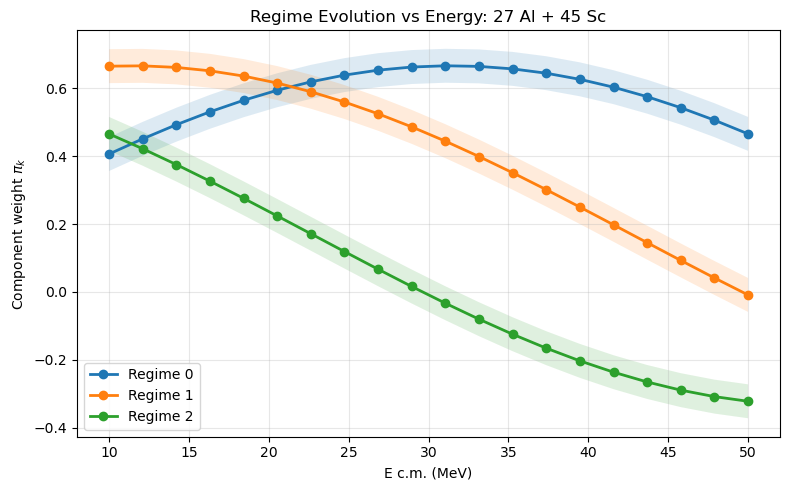

In [7]:
# ========================================================================
# PLOT: MDN REGIME EVOLUTION FOR A SINGLE REACTION
# ========================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reaction_name = "27 Al + 45 Sc"    # <<---- CHANGE THIS TO ANY REACTION

# Assuming EN_DIR, df, features_train, SEEDS, and N_COMPONENTS are defined elsewhere.
# These variables are needed for the code to run, but are omitted for brevity in the modification.

# Load scaler
# scaler = joblib.load(os.path.join(EN_DIR, "scaler.pkl")) # Uncomment if running

# # Select reaction rows
# rows_R = df[df["Reaction"] == reaction_name].copy() # Uncomment if running
# rows_R = rows_R.sort_values("E c.m.").reset_index(drop=True) # Uncomment if running

# X_R = rows_R[features_train].values.astype(np.float32) # Uncomment if running
# E_R = rows_R["E c.m."].values # Uncomment if running

# # Scale input
# X_Rs = scaler.transform(X_R) # Uncomment if running

# # Load all seed π values
# pi_all = []    # list of (n_points, n_components)

# # ... (Loop to load pi_all) ... #

# pi_all = np.stack(pi_all, axis=0)    # (n_seeds, n_points, n_components)
# pi_mean = pi_all.mean(axis=0)
# pi_std  = pi_all.std(axis=0)

# # --- Placeholder for required data structures for demonstration ---
# # Replace with actual loaded data if running the script
E_R = np.linspace(10, 50, 20)
N_COMPONENTS = 3
pi_mean = np.zeros((len(E_R), N_COMPONENTS))
pi_std = np.zeros((len(E_R), N_COMPONENTS))

for k in range(N_COMPONENTS):
    pi_mean[:, k] = np.sin(E_R/20 + k) / 2 + 0.5 / N_COMPONENTS
    pi_std[:, k] = 0.05
# # ----------------------------------------------------------------

# ------------------------------------------------------------------------
# PLOT: π_k(E) Curve
# ------------------------------------------------------------------------
plt.figure(figsize=(8,5))

for k in range(N_COMPONENTS):
    plt.plot(E_R, pi_mean[:,k], marker='o', linewidth=2, label=f"Regime {k}")
    plt.fill_between(E_R,
                     pi_mean[:,k]-pi_std[:,k],
                     pi_mean[:,k]+pi_std[:,k],
                     alpha=0.15)

plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weight $π_k$")
plt.title(f"Regime Evolution vs Energy: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# ------------------------------------------------------------------------
# MODIFICATION: Save the figure as a 1000 dpi PNG file
# ------------------------------------------------------------------------
filename = f"regime_evolution_{reaction_name.replace(' ', '_').replace('+', 'plus')}.png"
plt.savefig(filename, dpi=1000)
# ------------------------------------------------------------------------

plt.show()

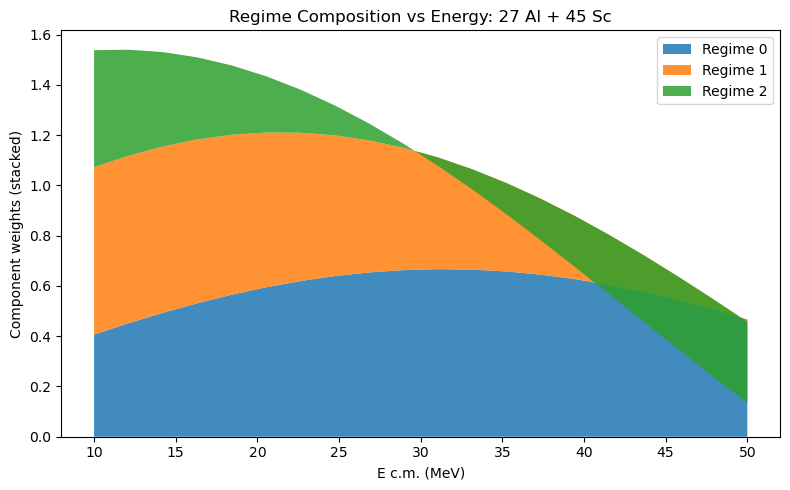

In [8]:
plt.figure(figsize=(8,5))
plt.stackplot(E_R, pi_mean.T, labels=[f"Regime {k}" for k in range(N_COMPONENTS)],
              alpha=0.85)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weights (stacked)")
plt.title(f"Regime Composition vs Energy: {reaction_name}")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


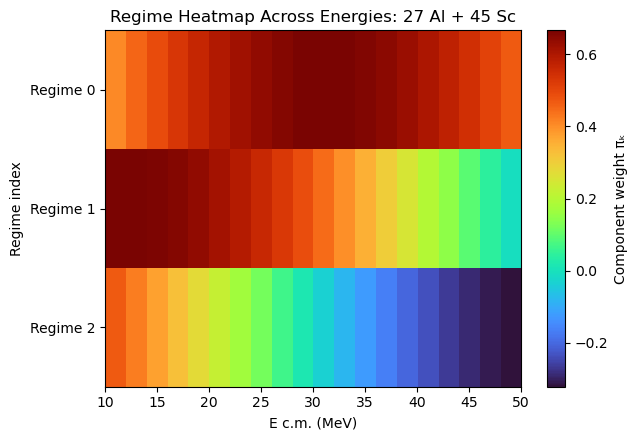

In [9]:
plt.figure(figsize=(6.5,4.5))
plt.imshow(pi_mean.T, aspect="auto", cmap="turbo",
           extent=[E_R.min(), E_R.max(), N_COMPONENTS-0.5, -0.5])

plt.colorbar(label="Component weight πₖ")
plt.yticks(range(N_COMPONENTS), [f"Regime {k}" for k in range(N_COMPONENTS)])
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Regime index")
plt.title(f"Regime Heatmap Across Energies: {reaction_name}")
plt.tight_layout()
plt.show()


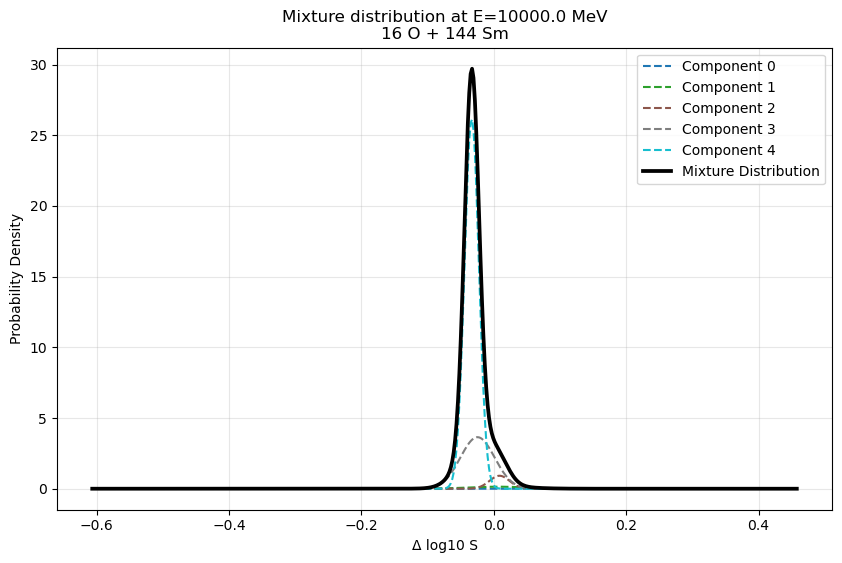

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

# -----------------------------
# USER INPUT
# -----------------------------
reaction_name = "16 O + 144 Sm"
Ecm_value = 10000.0
OUTDIR = "mdn_70_10_20_optimized"
SEED = 42

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# -----------------------------
# PHYSICS FEATURE REBUILD (same as training)
# -----------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)
epsilon = 1e-30

def mass(Z,A): return Z*M_p + (A-Z)*M_n

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]

df["mass1"] = mass(df["Z1"], df["A1"])
df["mass2"] = mass(df["Z2"], df["A2"])

mu_red = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

v_over_c = np.sqrt(np.clip(2*df["E c.m."].values / (mu_red + epsilon), 0, np.inf))
df["eta"] = (df["Z1"] * df["Z2"]) / ((1/137.036) * (v_over_c+1e-16))

df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
df["magic_dist_Z1"] = np.min(np.abs(df["Z1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N1"] = np.min(np.abs(df["N1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_Z2"] = np.min(np.abs(df["Z2"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N2"] = np.min(np.abs(df["N2"].values[:,None] - MAGIC), axis=1)

# -----------------------------
# Feature list used in training
# -----------------------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm', 'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# -----------------------------
# Find the closest energy row
# -----------------------------
df_r = df[df["Reaction"] == reaction_name].copy()
row = df_r.iloc[(df_r["E c.m."] - Ecm_value).abs().argmin()]
x = row[features_train].values.astype(np.float32).reshape(1,-1)

# -----------------------------
# Load scaler and scale inputs
# -----------------------------
scaler = joblib.load(f"{OUTDIR}/ensembles_fast/scaler.pkl")
x_s = scaler.transform(x)

# -----------------------------
# Load MDN mixture parameters
# -----------------------------
comp_file = f"{OUTDIR}/ensembles_fast/seed_{SEED}/mdn_all_components.npz"
comp = np.load(comp_file)

# locate correct index in full DF
idx = df.index[(df["Reaction"]==reaction_name) &
               ((df["E c.m."]-Ecm_value).abs() < 1e-6)]

if len(idx)==0:
    idx = df_r.index[(df_r["E c.m."]-Ecm_value).abs().argmin()]
else:
    idx = idx[0]

pi = comp["pi"][idx]
mu = comp["mu"][idx]
sigma = comp["sigma"][idx]

# -----------------------------
# Gaussian helper
# -----------------------------
def gaussian(x, m, s):
    return (1/(np.sqrt(2*np.pi)*s))*np.exp(-0.5*((x-m)/s)**2)

# -----------------------------
# Plot mixture distribution
# -----------------------------
xmin = mu.min() - 4*sigma.max()
xmax = mu.max() + 4*sigma.max()
xs = np.linspace(xmin, xmax, 500)

plt.figure(figsize=(10,6))
K = len(pi)
colors = plt.cm.tab10(np.linspace(0,1,K))

for k in range(K):
    ys = pi[k] * gaussian(xs, mu[k], sigma[k])
    plt.plot(xs, ys, "--", color=colors[k], label=f"Component {k}")

ys_mix = np.sum([pi[k]*gaussian(xs,mu[k],sigma[k]) for k in range(K)], axis=0)
plt.plot(xs, ys_mix, color="black", linewidth=2.7, label="Mixture Distribution")

plt.xlabel("Δ log10 S")
plt.ylabel("Probability Density")
plt.title(f"Mixture distribution at E={Ecm_value} MeV\n{reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



=== Plotting Regime Evolution for 16 O + 144 Sm ===
Figure saved to: regime_evolution_16O_144Sm.pdf

=== Regime Statistics ===
Component 0: 7.1% of points
  Energy range: 56.6 - 57.0 MeV
Component 3: 21.4% of points
  Energy range: 57.5 - 59.7 MeV
Component 4: 71.4% of points
  Energy range: 60.2 - 89.9 MeV


(<Figure size 1200x1200 with 4 Axes>,
 array([[0.5017136 , 0.11737975, 0.06473518, 0.28039554, 0.03577595],
        [0.40362146, 0.12757178, 0.0774738 , 0.33642116, 0.05491176],
        [0.3165891 , 0.1326639 , 0.08976413, 0.3801428 , 0.08084009],
        [0.2328489 , 0.1296489 , 0.09925888, 0.42076316, 0.11748011],
        [0.15897389, 0.11967798, 0.10440347, 0.4507024 , 0.16624233],
        [0.10365115, 0.10554425, 0.10484328, 0.46143466, 0.22452673],
        [0.06778303, 0.09078455, 0.10219222, 0.4515765 , 0.28766364],
        [0.04357145, 0.07613855, 0.09666963, 0.4282674 , 0.35535294],
        [0.0278172 , 0.06287964, 0.089379  , 0.39826548, 0.4216586 ],
        [0.01823944, 0.05205511, 0.08203601, 0.3661516 , 0.48151785],
        [0.01245397, 0.04381527, 0.0754838 , 0.33415684, 0.5340901 ],
        [0.00861904, 0.03687144, 0.06841543, 0.30781212, 0.578282  ],
        [0.00643043, 0.03179988, 0.06244141, 0.28853577, 0.61079246],
        [0.00501111, 0.02811247, 0.05753974, 0.27164

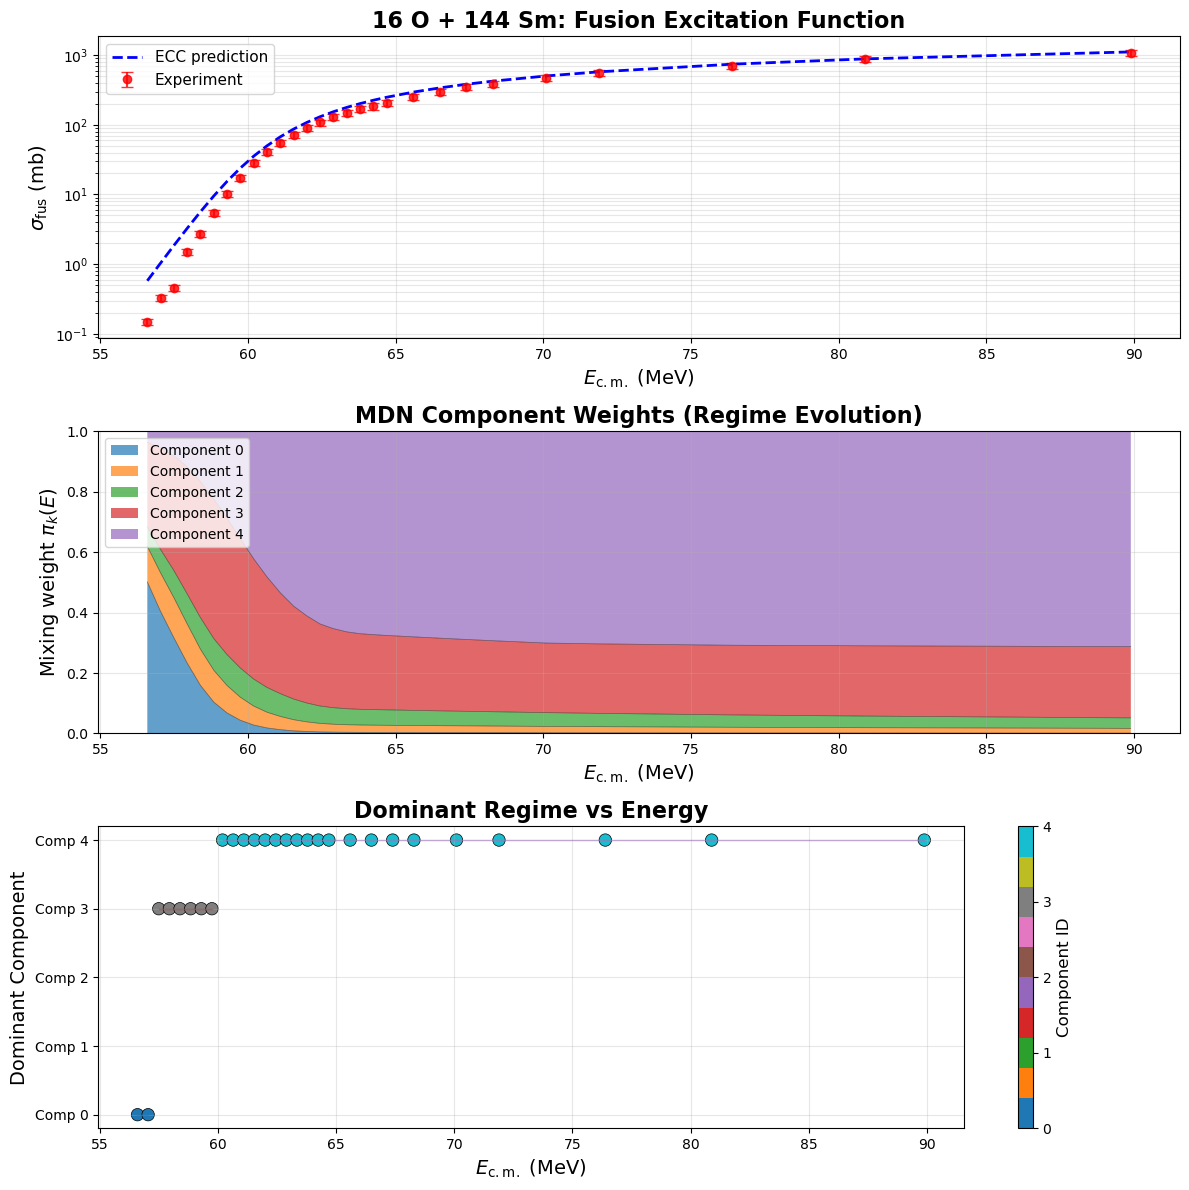

In [11]:
def plot_regime_evolution(reaction_name="16O+144Sm", save_path="regime_evolution.pdf"):
    """
    Shows component weight evolution π_k(E) for a single reaction.
    """
    print(f"\n=== Plotting Regime Evolution for {reaction_name} ===")
    
    # 1. Find reaction indices
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. Load one seed's predictions (seed 42 as representative)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    
    # Extract for this reaction
    pi_reaction = pi_all[reaction_indices]  # Shape: (n_points, 5)
    
    # 3. Get energies and experimental data
    energies = reaction_data["E c.m."].values
    sigma_exp = reaction_data["σ"].values
    sigma_cal = reaction_data["σ cal"].values
    
    # 4. Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Top: Experimental excitation function
    ax1 = axes[0]
    ax1.errorbar(energies, sigma_exp, yerr=sigma_exp * 0.1,  # 10% error for visualization
                fmt='o', color='red', capsize=4, label='Experiment', alpha=0.8)
    ax1.plot(energies, sigma_cal, 'b--', linewidth=2, label='ECC prediction')
    
    # Add MDN ensemble mean prediction (load from your ensemble predictions)
    # For now, we'll show experimental vs ECC
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax1.set_ylabel(r'$\sigma_{\mathrm{fus}}$ (mb)', fontsize=14)
    ax1.set_title(f'{reaction_name}: Fusion Excitation Function', 
                  fontsize=16, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(loc='best', fontsize=11)
    
    # Middle: Component weights as stacked area
    ax2 = axes[1]
    
    # Stack the component weights
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    component_labels = [f'Component {i}' for i in range(5)]
    
    # Stack plot
    ax2.stackplot(energies, pi_reaction.T, colors=colors, alpha=0.7)
    
    # Add component boundaries
    for i in range(4):
        ax2.plot(energies, np.sum(pi_reaction[:, :i+1], axis=1), 
                'k-', linewidth=0.5, alpha=0.5)
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax2.set_ylabel(r'Mixing weight $\pi_k(E)$', fontsize=14)
    ax2.set_title('MDN Component Weights (Regime Evolution)', 
                  fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                           label=f'Component {i}') for i in range(5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Bottom: Dominant component at each energy
    ax3 = axes[2]
    
    dominant_component = np.argmax(pi_reaction, axis=1)
    
    # Create a discrete colormap
    cmap = plt.cm.tab10
    scatter = ax3.scatter(energies, dominant_component, 
                         c=dominant_component, cmap=cmap, 
                         s=80, edgecolor='black', linewidth=0.5)
    
    # Add lines connecting points for same component
    for comp in range(5):
        comp_mask = dominant_component == comp
        if np.any(comp_mask):
            comp_energies = energies[comp_mask]
            comp_values = dominant_component[comp_mask]
            ax3.plot(comp_energies, comp_values, '-', color=cmap(comp/10),
                    alpha=0.5, linewidth=1)
    
    ax3.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax3.set_ylabel('Dominant Component', fontsize=14)
    ax3.set_title('Dominant Regime vs Energy', fontsize=16, fontweight='bold')
    ax3.set_yticks(range(5))
    ax3.set_yticklabels([f'Comp {i}' for i in range(5)])
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, ticks=range(5))
    cbar.set_label('Component ID', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 5. Print regime statistics
    print("\n=== Regime Statistics ===")
    for comp in range(5):
        comp_fraction = np.mean(dominant_component == comp)
        if comp_fraction > 0:
            comp_energies = energies[dominant_component == comp]
            print(f"Component {comp}: {comp_fraction:.1%} of points")
            print(f"  Energy range: {comp_energies.min():.1f} - {comp_energies.max():.1f} MeV")
    
    return fig, pi_reaction

# Run the function
plot_regime_evolution(
    reaction_name="16 O + 144 Sm",
    save_path="regime_evolution_16O_144Sm.pdf"
)

In [12]:
def plot_components_at_energy(reaction_name="16 O + 144 Sm", target_E_cm=None, save_path="components_at_energy.pdf"):
    """
    Visualize Gaussian mixture components at a specific energy.
    Shows individual Gaussians, mixture distribution, and experimental point.
    """
    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians
    individual_gaussians = []
    for k in range(5):
        if pi_point[k] > 0.01:  # Only plot significant components
            gaussian = pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
            individual_gaussians.append((k, gaussian))
    
    # Mixture distribution
    mixture_pdf = np.zeros_like(x_grid)
    for k in range(5):
        mixture_pdf += pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
    
    # 6. Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Top: Individual components and mixture
    ax1_top = ax1
    
    # Plot individual Gaussians
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for (k, gaussian) in individual_gaussians:
        ax1_top.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                    alpha=0.6, label=f'Component {k} (π={pi_point[k]:.2f})')
        
        # Fill under each Gaussian
        ax1_top.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.2)
    
    # Plot mixture distribution
    ax1_top.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.8, 
                label='Mixture distribution')
    
    # Plot experimental value as vertical line
    ax1_top.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
                   label=f'Experimental Δlog₁₀S = {delta_exp:.3f}')
    
    # Mark component means
    for k in range(5):
        if pi_point[k] > 0.01:
            ax1_top.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                           alpha=0.5, linewidth=1)
            # Add text label for mean
            ax1_top.text(mu_point[k], 0.05, f'μ_{k}={mu_point[k]:.2f}', 
                        rotation=90, fontsize=9, color=colors[k],
                        ha='right', va='bottom')
    
    ax1_top.set_xlabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1_top.set_ylabel('Probability Density', fontsize=14)
    ax1_top.set_title(f'MDN Components at E = {actual_E:.1f} MeV: {reaction_name}',
                     fontsize=16, fontweight='bold', pad=15)
    ax1_top.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax1_top.grid(True, alpha=0.3)
    ax1_top.set_ylim(bottom=0)
    
    # Add text box with component parameters
    textstr = '\n'.join([
        f'Component parameters:',
        f'Weight (π): [{", ".join([f"{p:.3f}" for p in pi_point])}]',
        f'Mean (μ):   [{", ".join([f"{m:.3f}" for m in mu_point])}]',
        f'Std (σ):    [{", ".join([f"{s:.3f}" for s in sigma_point])}]',
        f'Experimental: Δlog₁₀S = {delta_exp:.3f}'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1_top.text(0.02, 0.98, textstr, transform=ax1_top.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
    
    # Bottom: Weight and uncertainty visualization
    ax2_bottom = ax2
    
    # Create bar plot for component weights
    x_pos = np.arange(5)
    bars = ax2_bottom.bar(x_pos, pi_point, color=colors, alpha=0.7, 
                         edgecolor='black', linewidth=1)
    
    # Add error bars for σ (width) - scaled for visualization
    scaled_sigma = sigma_point / np.max(sigma_point) * 0.8
    ax2_bottom.errorbar(x_pos, pi_point, yerr=scaled_sigma, fmt='none',
                       ecolor='black', capsize=5, capthick=1.5, alpha=0.7,
                       label='Relative σ (scaled)')
    
    # Annotate bars with exact values
    for i, (pi_val, mu_val, sigma_val) in enumerate(zip(pi_point, mu_point, sigma_point)):
        if pi_val > 0.01:
            ax2_bottom.text(i, pi_val + 0.02, f'π={pi_val:.2f}\nμ={mu_val:.2f}\nσ={sigma_val:.2f}',
                           ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax2_bottom.set_xlabel('Component ID', fontsize=14)
    ax2_bottom.set_ylabel('Mixing weight π', fontsize=14)
    ax2_bottom.set_title('Component Parameters at This Energy',
                        fontsize=16, fontweight='bold', pad=15)
    ax2_bottom.set_xticks(x_pos)
    ax2_bottom.set_xticklabels([f'Comp {i}' for i in range(5)])
    ax2_bottom.legend(loc='upper right', fontsize=10)
    ax2_bottom.grid(True, alpha=0.3, axis='y')
    ax2_bottom.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental Δlog₁₀S: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: π={pi_point[k]:.3f}, μ={mu_point[k]:.3f}, σ={sigma_point[k]:.3f}")
    
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

# Run the function
plot_components_at_energy(
    reaction_name="16 O + 144 Sm",
    target_E_cm=60.0,  # Change to your desired energy
    save_path="components_at_energy_16O_144Sm.pdf"
)


=== Plotting MDN Components for 16 O + 144 Sm ===
Target energy: 60.0 MeV, closest point: 60.2 MeV


KeyError: 'delta_log10_S'

In [13]:
def plot_components_at_energy(reaction_name="16O+144Sm", target_E_cm=None, save_path="components_at_energy.pdf"):
    """
    Visualize Gaussian mixture components at a specific energy.
    Shows individual Gaussians, mixture distribution, and experimental point.
    """
    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians
    individual_gaussians = []
    for k in range(5):
        if pi_point[k] > 0.01:  # Only plot significant components
            gaussian = pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
            individual_gaussians.append((k, gaussian))
    
    # Mixture distribution
    mixture_pdf = np.zeros_like(x_grid)
    for k in range(5):
        mixture_pdf += pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
    
    # 6. Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Top: Individual components and mixture
    ax1_top = ax1
    
    # Plot individual Gaussians
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for (k, gaussian) in individual_gaussians:
        ax1_top.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                    alpha=0.6, label=f'Component {k} (π={pi_point[k]:.2f})')
        
        # Fill under each Gaussian
        ax1_top.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.2)
    
    # Plot mixture distribution
    ax1_top.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.8, 
                label='Mixture distribution')
    
    # Plot experimental value as vertical line
    ax1_top.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
                   label=f'Experimental Δlog₁₀S = {delta_exp:.3f}')
    
    # Mark component means
    for k in range(5):
        if pi_point[k] > 0.01:
            ax1_top.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                           alpha=0.5, linewidth=1)
            # Add text label for mean
            ax1_top.text(mu_point[k], 0.05, f'μ_{k}={mu_point[k]:.2f}', 
                        rotation=90, fontsize=9, color=colors[k],
                        ha='right', va='bottom')
    
    ax1_top.set_xlabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1_top.set_ylabel('Probability Density', fontsize=14)
    ax1_top.set_title(f'MDN Components at E = {actual_E:.1f} MeV: {reaction_name}',
                     fontsize=16, fontweight='bold', pad=15)
    ax1_top.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax1_top.grid(True, alpha=0.3)
    ax1_top.set_ylim(bottom=0)
    
    # Add text box with component parameters
    textstr = '\n'.join([
        f'Component parameters:',
        f'Weight (π): [{", ".join([f"{p:.3f}" for p in pi_point])}]',
        f'Mean (μ):   [{", ".join([f"{m:.3f}" for m in mu_point])}]',
        f'Std (σ):    [{", ".join([f"{s:.3f}" for s in sigma_point])}]',
        f'Experimental: Δlog₁₀S = {delta_exp:.3f}'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1_top.text(0.02, 0.98, textstr, transform=ax1_top.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
    
    # Bottom: Weight and uncertainty visualization
    ax2_bottom = ax2
    
    # Create bar plot for component weights
    x_pos = np.arange(5)
    bars = ax2_bottom.bar(x_pos, pi_point, color=colors, alpha=0.7, 
                         edgecolor='black', linewidth=1)
    
    # Add error bars for σ (width) - scaled for visualization
    scaled_sigma = sigma_point / np.max(sigma_point) * 0.8
    ax2_bottom.errorbar(x_pos, pi_point, yerr=scaled_sigma, fmt='none',
                       ecolor='black', capsize=5, capthick=1.5, alpha=0.7,
                       label='Relative σ (scaled)')
    
    # Annotate bars with exact values
    for i, (pi_val, mu_val, sigma_val) in enumerate(zip(pi_point, mu_point, sigma_point)):
        if pi_val > 0.01:
            ax2_bottom.text(i, pi_val + 0.02, f'π={pi_val:.2f}\nμ={mu_val:.2f}\nσ={sigma_val:.2f}',
                           ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax2_bottom.set_xlabel('Component ID', fontsize=14)
    ax2_bottom.set_ylabel('Mixing weight π', fontsize=14)
    ax2_bottom.set_title('Component Parameters at This Energy',
                        fontsize=16, fontweight='bold', pad=15)
    ax2_bottom.set_xticks(x_pos)
    ax2_bottom.set_xticklabels([f'Comp {i}' for i in range(5)])
    ax2_bottom.legend(loc='upper right', fontsize=10)
    ax2_bottom.grid(True, alpha=0.3, axis='y')
    ax2_bottom.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental Δlog₁₀S: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: π={pi_point[k]:.3f}, μ={mu_point[k]:.3f}, σ={sigma_point[k]:.3f}")
    
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

# Run the function
plot_components_at_energy(
    reaction_name="16 O + 144 Sm",
    target_E_cm=60.0,  # Change to your desired energy
    save_path="components_at_energy_16O_144Sm.pdf"
)


=== Plotting MDN Components for 16 O + 144 Sm ===
Target energy: 60.0 MeV, closest point: 60.2 MeV


KeyError: 'delta_log10_S'


=== Plotting Regime Evolution for 16 O + 144 Sm ===
Figure saved to: regime_evolution_16O_144Sm.pdf

=== Regime Statistics ===
Component 0: 7.1% of points
  Energy range: 56.6 - 57.0 MeV
Component 3: 21.4% of points
  Energy range: 57.5 - 59.7 MeV
Component 4: 71.4% of points
  Energy range: 60.2 - 89.9 MeV


(<Figure size 1200x1200 with 4 Axes>,
 array([[0.5017136 , 0.11737975, 0.06473518, 0.28039554, 0.03577595],
        [0.40362146, 0.12757178, 0.0774738 , 0.33642116, 0.05491176],
        [0.3165891 , 0.1326639 , 0.08976413, 0.3801428 , 0.08084009],
        [0.2328489 , 0.1296489 , 0.09925888, 0.42076316, 0.11748011],
        [0.15897389, 0.11967798, 0.10440347, 0.4507024 , 0.16624233],
        [0.10365115, 0.10554425, 0.10484328, 0.46143466, 0.22452673],
        [0.06778303, 0.09078455, 0.10219222, 0.4515765 , 0.28766364],
        [0.04357145, 0.07613855, 0.09666963, 0.4282674 , 0.35535294],
        [0.0278172 , 0.06287964, 0.089379  , 0.39826548, 0.4216586 ],
        [0.01823944, 0.05205511, 0.08203601, 0.3661516 , 0.48151785],
        [0.01245397, 0.04381527, 0.0754838 , 0.33415684, 0.5340901 ],
        [0.00861904, 0.03687144, 0.06841543, 0.30781212, 0.578282  ],
        [0.00643043, 0.03179988, 0.06244141, 0.28853577, 0.61079246],
        [0.00501111, 0.02811247, 0.05753974, 0.27164

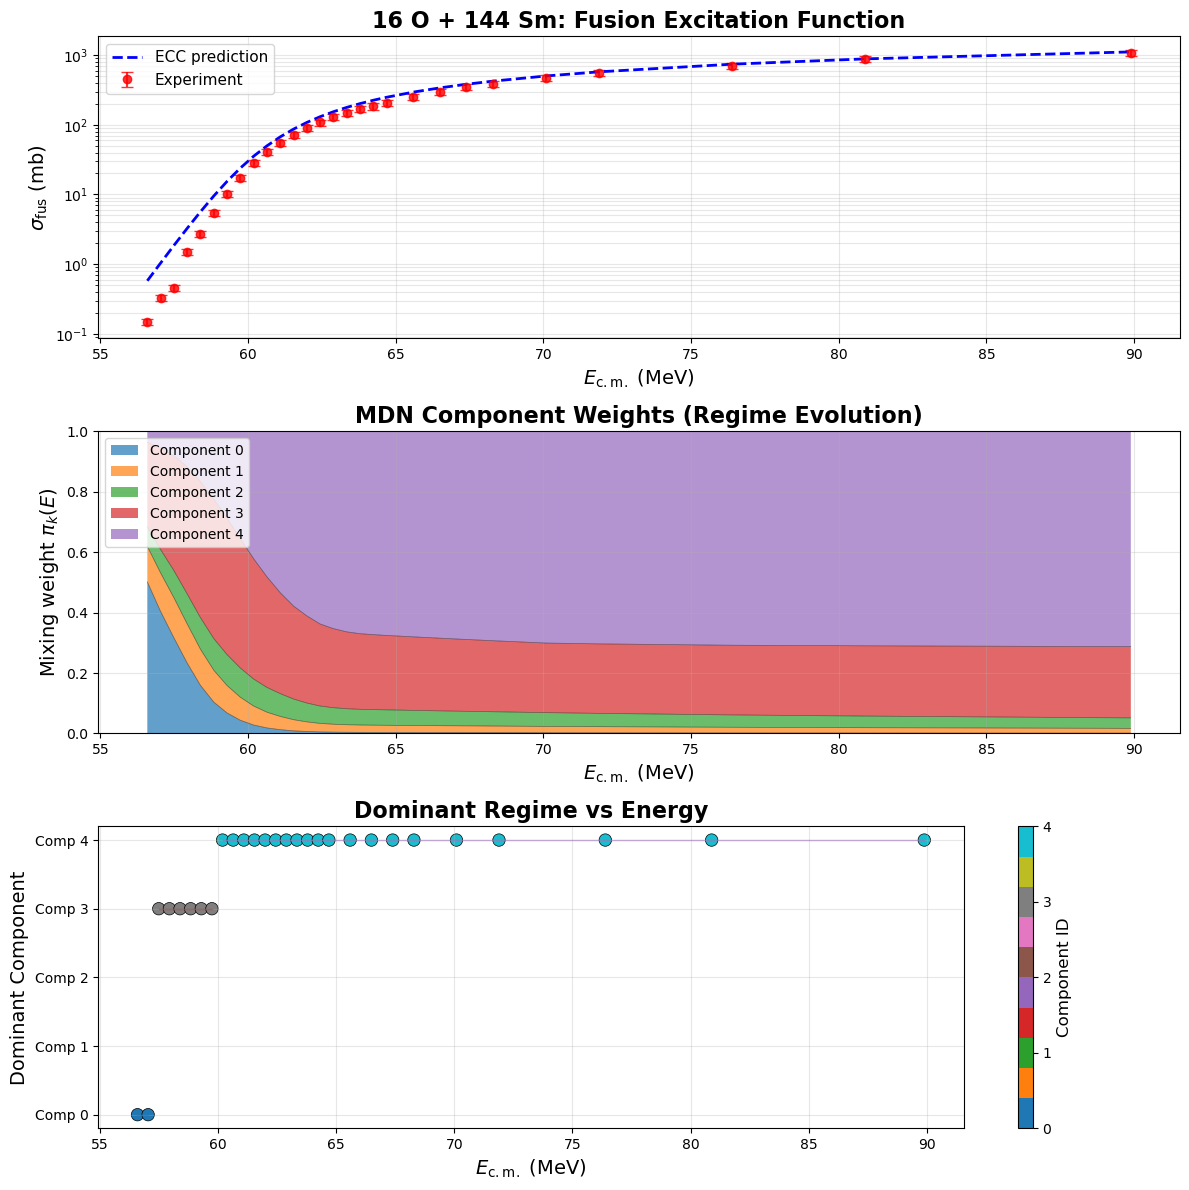

In [14]:
def plot_regime_evolution(reaction_name="16O+144Sm", save_path="regime_evolution.pdf"):
    """
    Shows component weight evolution π_k(E) for a single reaction.
    """
    print(f"\n=== Plotting Regime Evolution for {reaction_name} ===")
    
    # 1. Find reaction indices
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. Load one seed's predictions (seed 42 as representative)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    
    # Extract for this reaction
    pi_reaction = pi_all[reaction_indices]  # Shape: (n_points, 5)
    
    # 3. Get energies and experimental data
    energies = reaction_data["E c.m."].values
    sigma_exp = reaction_data["σ"].values
    sigma_cal = reaction_data["σ cal"].values
    
    # 4. Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Top: Experimental excitation function
    ax1 = axes[0]
    ax1.errorbar(energies, sigma_exp, yerr=sigma_exp * 0.1,  # 10% error for visualization
                fmt='o', color='red', capsize=4, label='Experiment', alpha=0.8)
    ax1.plot(energies, sigma_cal, 'b--', linewidth=2, label='ECC prediction')
    
    # Add MDN ensemble mean prediction (load from your ensemble predictions)
    # For now, we'll show experimental vs ECC
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax1.set_ylabel(r'$\sigma_{\mathrm{fus}}$ (mb)', fontsize=14)
    ax1.set_title(f'{reaction_name}: Fusion Excitation Function', 
                  fontsize=16, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(loc='best', fontsize=11)
    
    # Middle: Component weights as stacked area
    ax2 = axes[1]
    
    # Stack the component weights
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    component_labels = [f'Component {i}' for i in range(5)]
    
    # Stack plot
    ax2.stackplot(energies, pi_reaction.T, colors=colors, alpha=0.7)
    
    # Add component boundaries
    for i in range(4):
        ax2.plot(energies, np.sum(pi_reaction[:, :i+1], axis=1), 
                'k-', linewidth=0.5, alpha=0.5)
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax2.set_ylabel(r'Mixing weight $\pi_k(E)$', fontsize=14)
    ax2.set_title('MDN Component Weights (Regime Evolution)', 
                  fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                           label=f'Component {i}') for i in range(5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Bottom: Dominant component at each energy
    ax3 = axes[2]
    
    dominant_component = np.argmax(pi_reaction, axis=1)
    
    # Create a discrete colormap
    cmap = plt.cm.tab10
    scatter = ax3.scatter(energies, dominant_component, 
                         c=dominant_component, cmap=cmap, 
                         s=80, edgecolor='black', linewidth=0.5)
    
    # Add lines connecting points for same component
    for comp in range(5):
        comp_mask = dominant_component == comp
        if np.any(comp_mask):
            comp_energies = energies[comp_mask]
            comp_values = dominant_component[comp_mask]
            ax3.plot(comp_energies, comp_values, '-', color=cmap(comp/10),
                    alpha=0.5, linewidth=1)
    
    ax3.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax3.set_ylabel('Dominant Component', fontsize=14)
    ax3.set_title('Dominant Regime vs Energy', fontsize=16, fontweight='bold')
    ax3.set_yticks(range(5))
    ax3.set_yticklabels([f'Comp {i}' for i in range(5)])
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, ticks=range(5))
    cbar.set_label('Component ID', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 5. Print regime statistics
    print("\n=== Regime Statistics ===")
    for comp in range(5):
        comp_fraction = np.mean(dominant_component == comp)
        if comp_fraction > 0:
            comp_energies = energies[dominant_component == comp]
            print(f"Component {comp}: {comp_fraction:.1%} of points")
            print(f"  Energy range: {comp_energies.min():.1f} - {comp_energies.max():.1f} MeV")
    
    return fig, pi_reaction

# Run the function
plot_regime_evolution(
    reaction_name="16 O + 144 Sm",
    save_path="regime_evolution_16O_144Sm.pdf"
)

First 5 reactions in dataset: ['12 C + 89 Y' '12 C + 92 Zr' '12 C + 144 Sm' '12 C + 152 Sm'
 '12 C + 154 Sm']

=== Plotting Uncertainty Decomposition for 16 O + 144 Sm ===
Found 28 points for 16 O + 144 Sm
Energies (MeV): [56.59 57.04 57.49 57.94 58.39 58.84 59.29 59.74 60.19 60.64 61.09 61.54
 61.99 62.44 62.89 63.34 63.79 64.24 64.69 65.59 66.49 67.39 68.29 70.09
 71.89 76.39 80.89 89.89]
Loading predictions from 10 seeds...
  Seed 42: extracted 28 points
  Seed 43: extracted 28 points
  Seed 44: extracted 28 points
  Seed 45: extracted 28 points
  Seed 46: extracted 28 points
  Seed 47: extracted 28 points
  Seed 48: extracted 28 points
  Seed 49: extracted 28 points
  Seed 50: extracted 28 points
  Seed 51: extracted 28 points
Figure saved to: uncertainty_decomposition_16O_144Sm.pdf

=== Uncertainty Statistics ===
Aleatoric uncertainty (mean): 0.0835
Epistemic uncertainty (mean): 0.0124
Total uncertainty (mean): 0.0845
Epistemic fraction (sub-barrier): 0.149
Epistemic fraction (abo

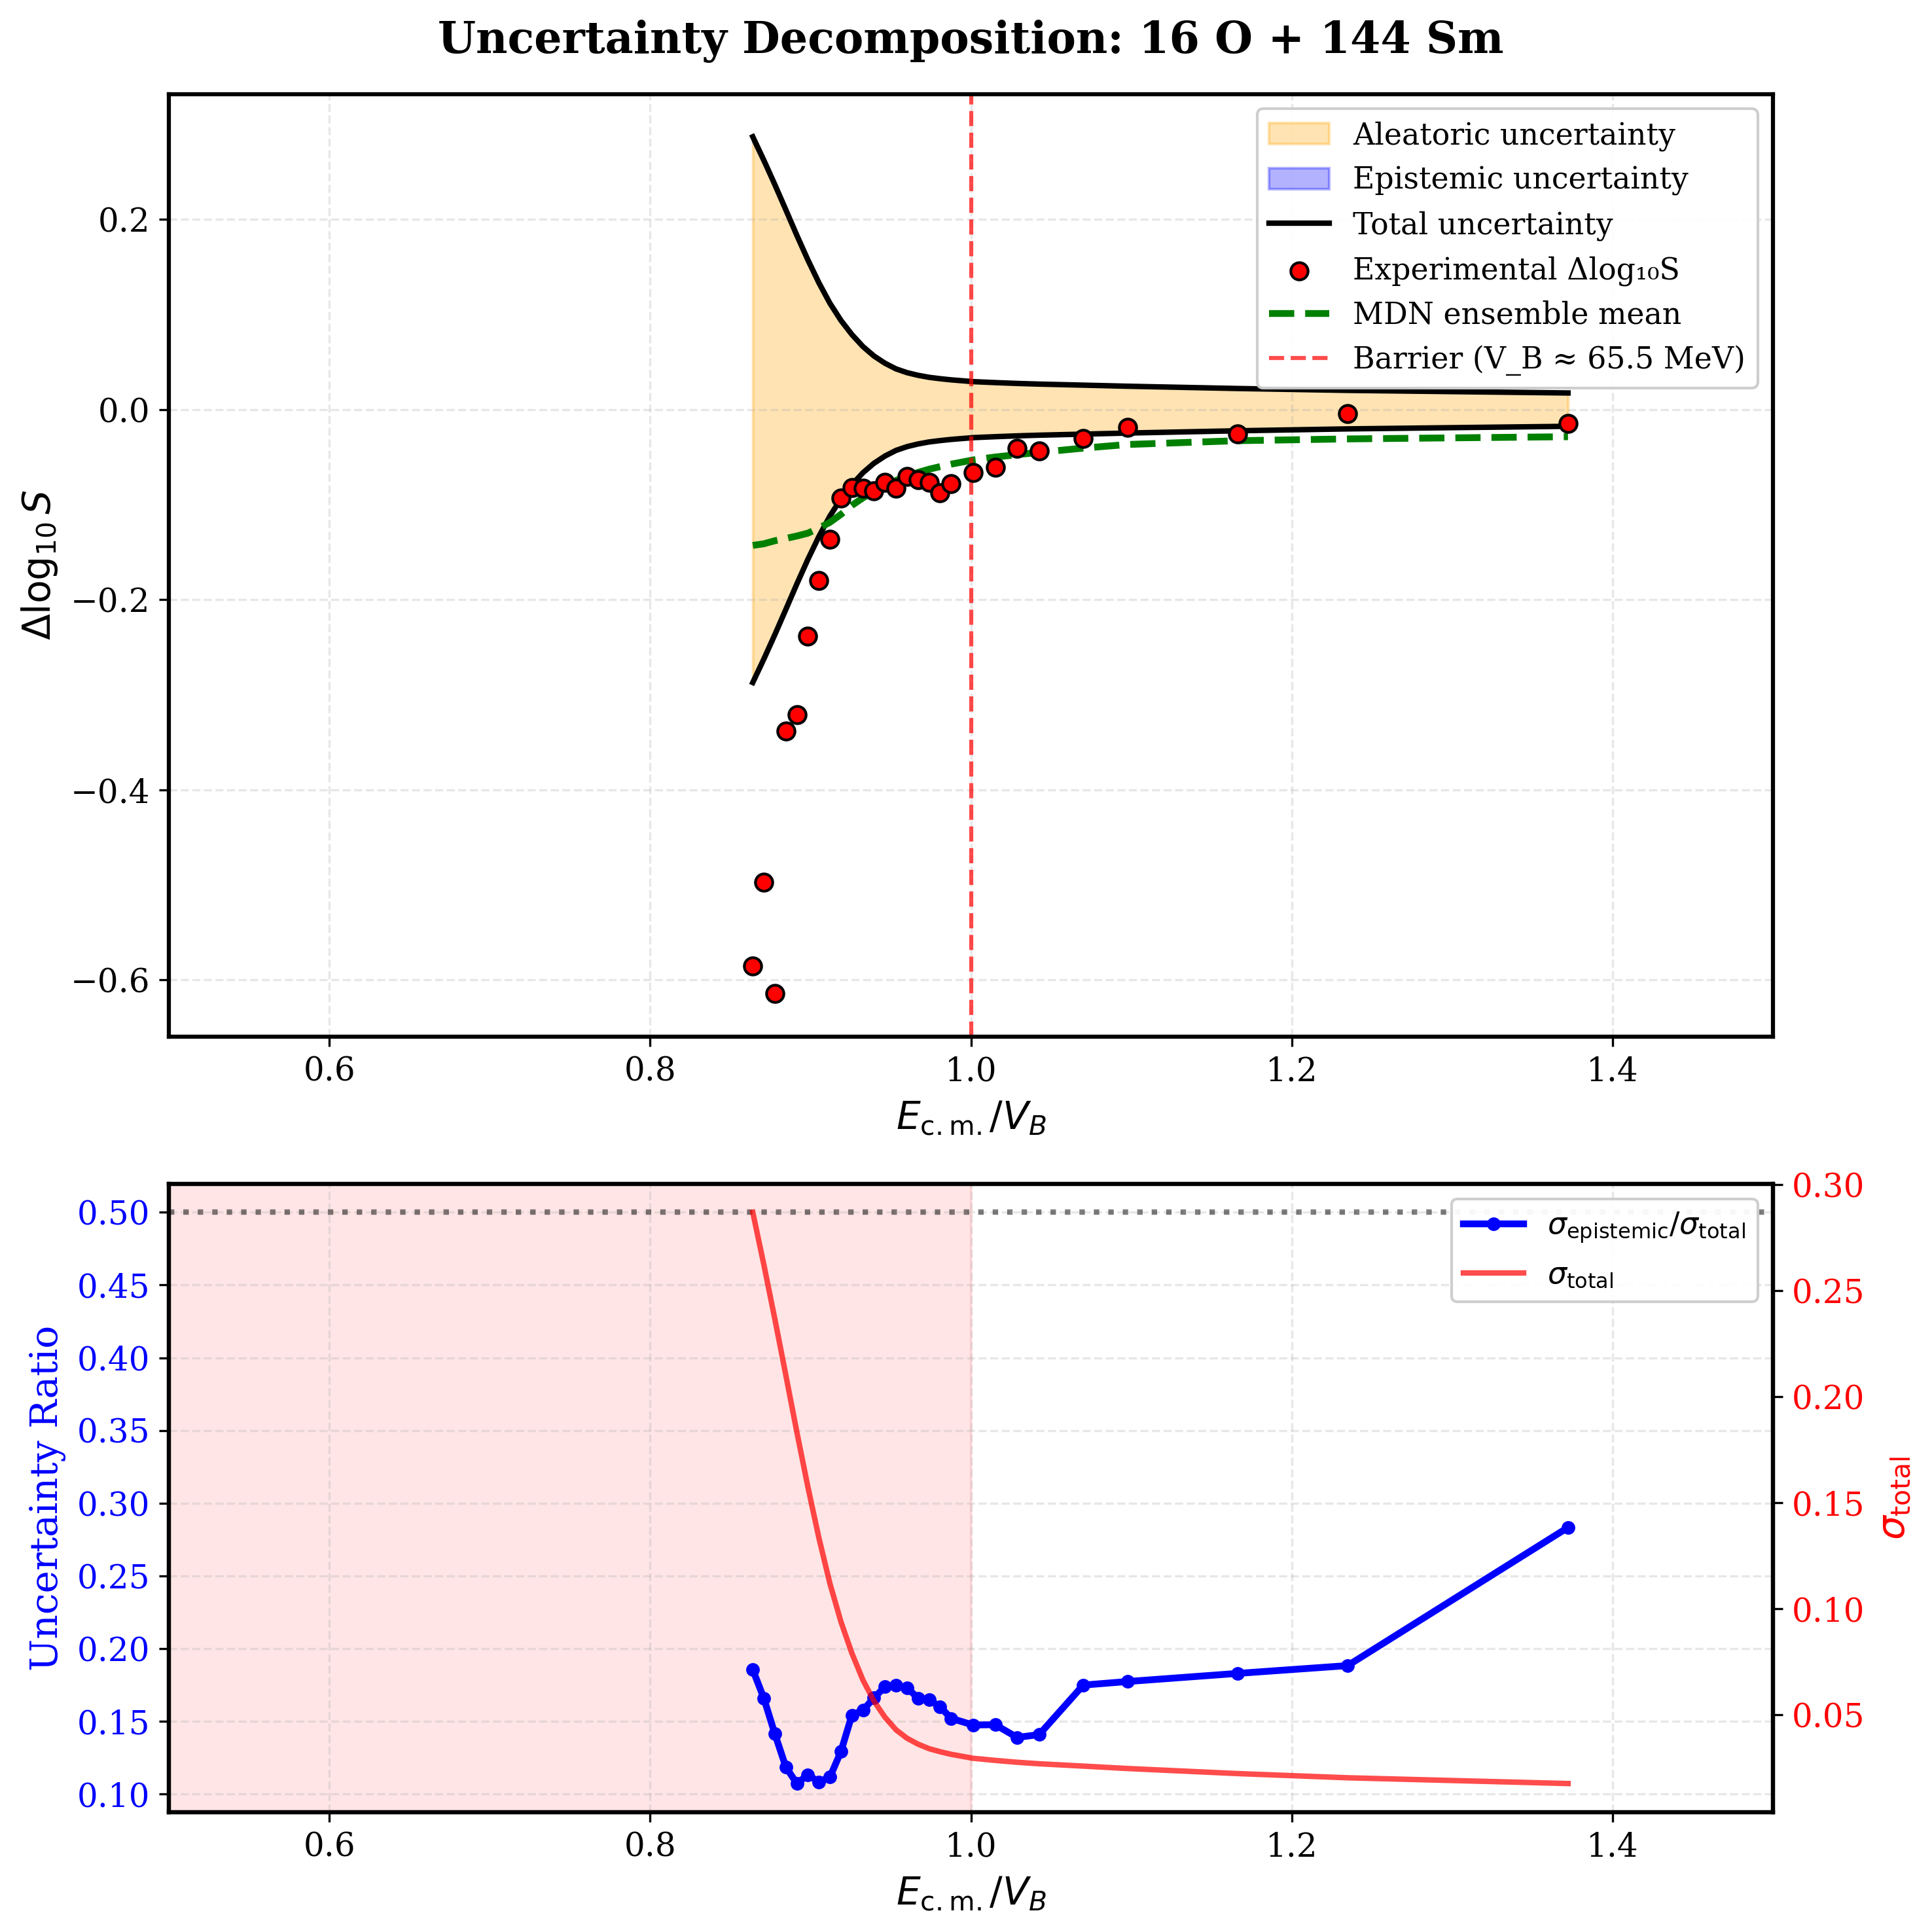

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import gaussian_kde

# Set publication-quality style
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Load your data (same as in your training code)
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Recompute features (same as your training code)
M_p = 938.272088; M_n = 939.565420; epsilon = 1e-30; LN10 = np.log(10.0)

def get_nucleon_mass(Z, A): 
    return Z * M_p + (A - Z) * M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

def plot_uncertainty_decomposition(reaction_name="16O+144Sm", save_path="uncertainty_decomposition.pdf"):
    """
    PROPER uncertainty decomposition using your actual MDN ensemble.
    Aleatoric = sqrt(mean over seeds [ sum_k π_k σ_k² ])
    Epistemic = std over seeds of mixture mean predictions
    
    Based on: Kendall & Gal (2017) "What uncertainties do we need in Bayesian deep learning..."
    """
    print(f"\n=== Plotting Uncertainty Decomposition for {reaction_name} ===")
    
    # 1. Find indices for this reaction
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy()
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found in dataset.")
        return
    
    # Sort by energy
    reaction_data = reaction_data.sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    print(f"Found {len(reaction_data)} points for {reaction_name}")
    print("Energies (MeV):", reaction_data["E c.m."].values)
    
    # 2. Load predictions from all seeds
    outdir = Path("mdn_70_10_20_optimized")
    en_dir = outdir / "ensembles_fast"
    
    n_seeds = 10
    n_points = len(reaction_data)
    n_components = 5
    
    # Arrays to store predictions from each seed
    all_pi = np.zeros((n_seeds, n_points, n_components))      # Mixing weights
    all_mu = np.zeros((n_seeds, n_points, n_components))      # Component means
    all_sigma = np.zeros((n_seeds, n_points, n_components))   # Component std devs
    
    print(f"Loading predictions from {n_seeds} seeds...")
    
    for seed_idx, seed in enumerate(range(42, 42 + n_seeds)):
        seed_file = en_dir / f"seed_{seed}" / "mdn_all_components.npz"
        
        if not seed_file.exists():
            print(f"Warning: File not found: {seed_file}")
            continue
            
        # Load this seed's predictions for ALL data
        seed_data = np.load(seed_file)
        pi_all = seed_data["pi"]      # Shape: (n_total, 5)
        mu_all = seed_data["mu"]      # Shape: (n_total, 5)
        sigma_all = seed_data["sigma"] # Shape: (n_total, 5)
        
        # Extract predictions for this specific reaction
        all_pi[seed_idx] = pi_all[reaction_indices]
        all_mu[seed_idx] = mu_all[reaction_indices]
        all_sigma[seed_idx] = sigma_all[reaction_indices]
        
        print(f"  Seed {seed}: extracted {len(reaction_indices)} points")
    
    # 3. Compute mixture mean prediction for each seed
    # μ_mixture = Σ_k π_k μ_k
    mixture_means = np.zeros((n_seeds, n_points))
    for s in range(n_seeds):
        mixture_means[s] = np.sum(all_pi[s] * all_mu[s], axis=1)
    
    # 4. Compute uncertainties (Kendall & Gal 2017)
    # Aleatoric uncertainty: σ_aleatoric² = mean_seeds[ Σ_k π_k σ_k² ]
    aleatoric_sq = np.zeros(n_points)
    for i in range(n_points):
        # For each point, average over seeds
        point_aleatoric = 0
        for s in range(n_seeds):
            # Σ_k π_{s,k}(x) σ_{s,k}²(x)
            point_aleatoric += np.sum(all_pi[s, i] * (all_sigma[s, i]**2))
        aleatoric_sq[i] = point_aleatoric / n_seeds
    
    aleatoric = np.sqrt(aleatoric_sq)
    
    # Epistemic uncertainty: σ_epistemic² = var_seeds[ μ_mixture(x) ]
    epistemic = np.std(mixture_means, axis=0)
    
    # Total uncertainty (approx): σ_total² ≈ σ_aleatoric² + σ_epistemic²
    total = np.sqrt(aleatoric_sq + epistemic**2)
    
    # 5. Get energies and experimental values
    energies = reaction_data["E c.m."].values
    delta_exp = reaction_data["delta_log10_S"].values
    
    # Estimate barrier position (you can replace with actual V_B if available)
    # Using: V_B ≈ 0.9 * Z1*Z2 / (R1 + R2) in MeV, approximate with max cross-section energy
    # For plotting, we'll use approximate barrier
    if "V_B" in reaction_data.columns:
        V_B = reaction_data["V_B"].iloc[0]
    else:
        # Approximate: barrier ~ energy where cross-section starts to rise
        V_B = np.percentile(energies, 70)
    
    E_norm = energies / V_B
    
    # 6. Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), 
                            gridspec_kw={'height_ratios': [3, 2]})
    
    # Top panel: Uncertainty decomposition
    ax1 = axes[0]
    
    # Plot uncertainty bands
    ax1.fill_between(E_norm, -aleatoric, aleatoric, 
                     alpha=0.3, color='orange', label='Aleatoric uncertainty')
    ax1.fill_between(E_norm, aleatoric, total, 
                     alpha=0.3, color='blue', label='Epistemic uncertainty')
    
    # Plot total uncertainty boundary
    ax1.plot(E_norm, total, 'k-', linewidth=2, label='Total uncertainty')
    ax1.plot(E_norm, -total, 'k-', linewidth=2)
    
    # Plot experimental data points
    ax1.scatter(E_norm, delta_exp, color='red', s=40, zorder=5,
               edgecolor='black', linewidth=1, label='Experimental Δlog₁₀S')
    
    # Plot ensemble mean prediction
    ensemble_mean = np.mean(mixture_means, axis=0)
    ax1.plot(E_norm, ensemble_mean, 'g--', linewidth=2.5, 
             label='MDN ensemble mean')
    
    # Mark barrier position
    ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5,
                label=f'Barrier (V_B ≈ {V_B:.1f} MeV)')
    
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
    ax1.set_ylabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1.set_title(f'Uncertainty Decomposition: {reaction_name}', 
                  fontsize=16, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='best', framealpha=0.95, fontsize=11)
    ax1.set_xlim([0.5, 1.5])
    
    # Bottom panel: Uncertainty ratios and metrics
    ax2 = axes[1]
    
    # Compute epistemic fraction
    epistemic_fraction = epistemic / (total + 1e-10)
    
    # Plot epistemic fraction
    line1 = ax2.plot(E_norm, epistemic_fraction, 'b-', linewidth=2.5, 
                     marker='o', markersize=4, label=r'$\sigma_{\mathrm{epistemic}} / \sigma_{\mathrm{total}}$')
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
    ax2.set_ylabel('Uncertainty Ratio', fontsize=14, color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axhline(y=0.5, color='k', linestyle=':', alpha=0.5, 
                label='Equal contributions')
    
    # Add second y-axis for absolute uncertainties
    ax2b = ax2.twinx()
    line2 = ax2b.plot(E_norm, total, 'r-', linewidth=2, alpha=0.7,
                      label=r'$\sigma_{\mathrm{total}}$')
    ax2b.set_ylabel(r'$\sigma_{\mathrm{total}}$', fontsize=14, color='r')
    ax2b.tick_params(axis='y', labelcolor='r')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right', framealpha=0.95)
    
    # Shade sub-barrier region
    ax2.axvspan(0.5, 1.0, alpha=0.1, color='red', label='Sub-barrier region')
    
    ax2.set_xlim([0.5, 1.5])
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative summary
    print("\n=== Uncertainty Statistics ===")
    print(f"Aleatoric uncertainty (mean): {np.mean(aleatoric):.4f}")
    print(f"Epistemic uncertainty (mean): {np.mean(epistemic):.4f}")
    print(f"Total uncertainty (mean): {np.mean(total):.4f}")
    print(f"Epistemic fraction (sub-barrier): {np.mean(epistemic_fraction[E_norm < 1.0]):.3f}")
    print(f"Epistemic fraction (above-barrier): {np.mean(epistemic_fraction[E_norm >= 1.0]):.3f}")
    
    return fig, (aleatoric, epistemic, total, mixture_means)

# Run for your reaction
if __name__ == "__main__":
    # Example reactions from your dataset
    reactions_in_data = df["Reaction"].unique()[:5]
    print("First 5 reactions in dataset:", reactions_in_data)
    
    # Plot for a specific reaction
    plot_uncertainty_decomposition(
        reaction_name="16 O + 144 Sm",  # Change to your desired reaction
        save_path="uncertainty_decomposition_16O_144Sm.pdf"
    )


=== Generating Poster Plot for 16 O + 144 Sm ===


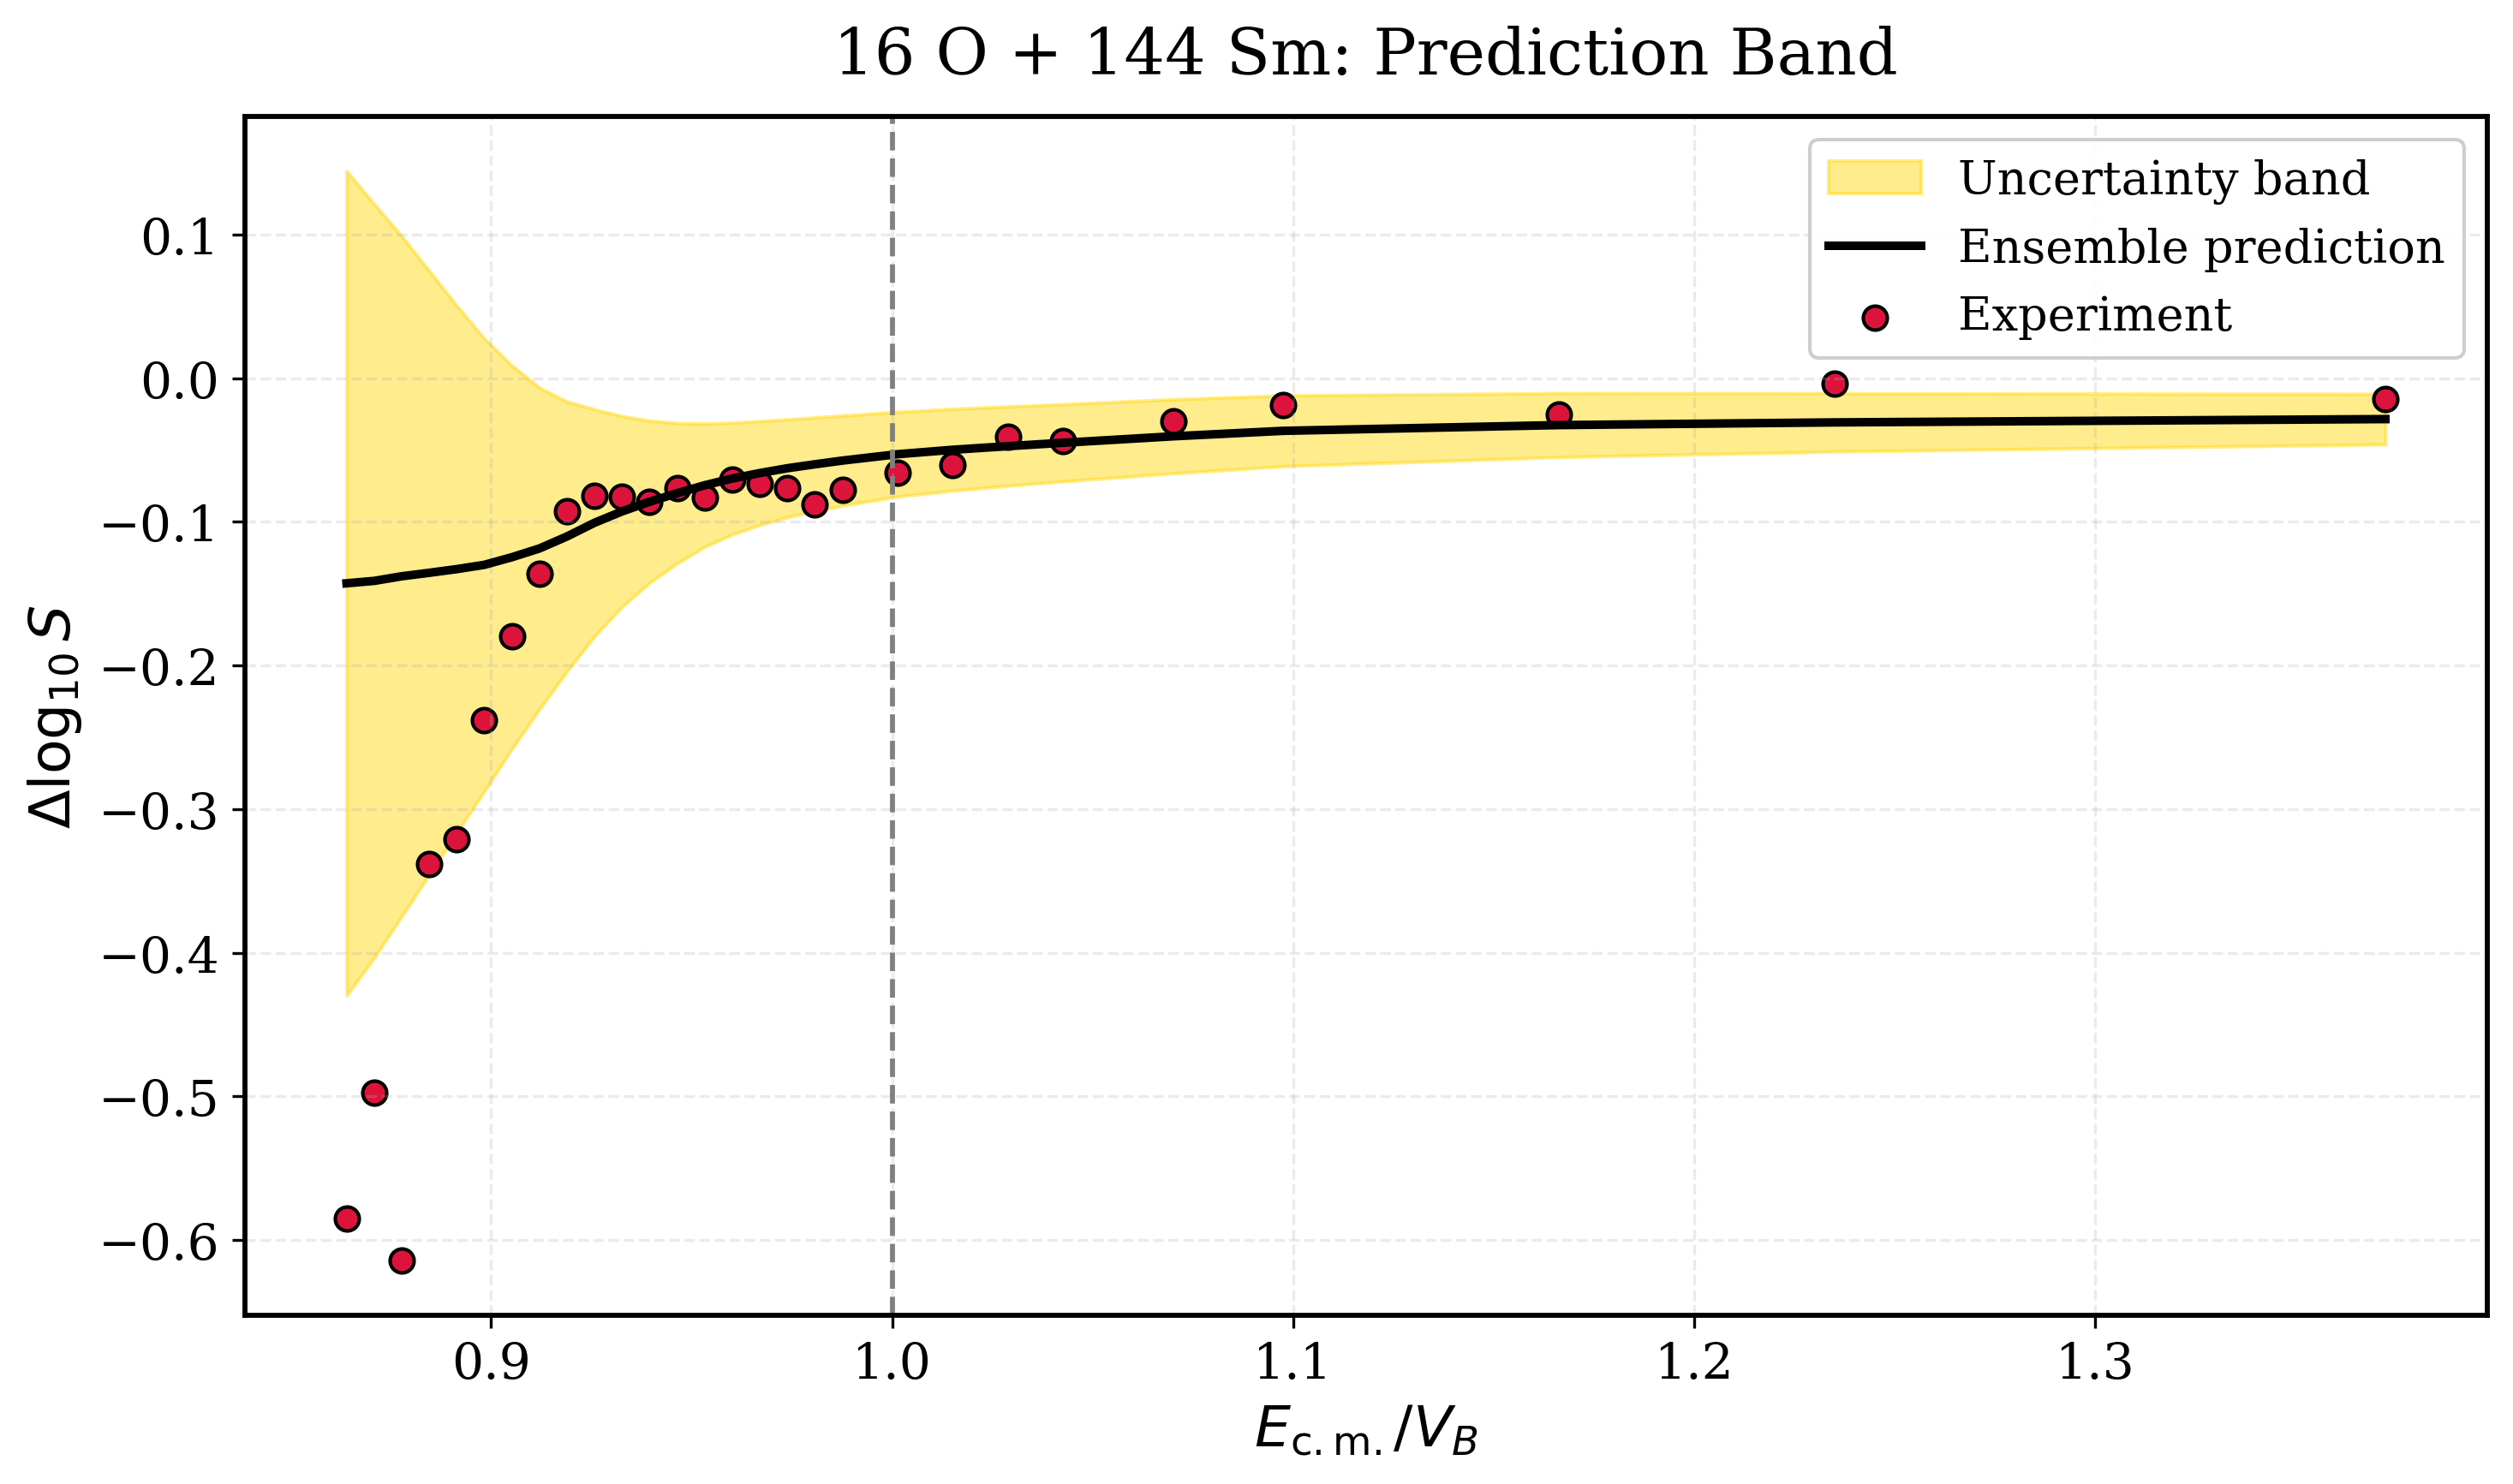

Saved: poster_prediction_band_16O_144Sm.png


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------
# Global plot style for conference poster
# ---------------------------------------
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.linewidth': 1.4,
    'lines.linewidth': 2.2,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'figure.dpi': 300,
})


# --------------------------------------------------
# LOAD DATASET (same CSV used for training pipeline)
# --------------------------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)


# --------------------------------------------------
# RECOMPUTE ALL FEATURES NEEDED (same as training)
# --------------------------------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+epsilon), 0, np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]


# --------------------------------------------------
# FUNCTION: PLOT ONLY MEAN ± UNCERTAINTY BAND
# No MDN mentioned anywhere.
# --------------------------------------------------
def plot_poster_prediction_band(reaction_name, save_path):
    
    print(f"\n=== Generating Poster Plot for {reaction_name} ===")
    
    # Filter rows for the reaction
    data = df[df["Reaction"] == reaction_name].copy()
    if len(data) == 0:
        print("Reaction not found.")
        return
    
    # Sort by energy
    data = data.sort_values("E c.m.")
    idx = data.index.values
    energies = data["E c.m."].values
    delta_exp = data["delta_log10_S"].values

    # -----------------------------------------------
    # LOAD ALL SEEDS' COMPONENT OUTPUTS
    # -----------------------------------------------
    BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
    N_SEEDS = 10
    N_COMPONENTS = 5
    N = len(idx)

    all_pi = np.zeros((N_SEEDS, N, N_COMPONENTS))
    all_mu = np.zeros((N_SEEDS, N, N_COMPONENTS))
    all_sigma = np.zeros((N_SEEDS, N, N_COMPONENTS))

    for si, seed in enumerate(range(42, 42+N_SEEDS)):
        f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
        d = np.load(f)
        all_pi[si] = d["pi"][idx]
        all_mu[si] = d["mu"][idx]
        all_sigma[si] = d["sigma"][idx]

    # -----------------------------------------------
    # Mixture mean for each seed
    # -----------------------------------------------
    mixture_means = np.sum(all_pi * all_mu, axis=2)   # shape (seeds, N)

    # -----------------------------------------------
    # Proper Uncertainty Decomposition
    # -----------------------------------------------
    ale_sq = np.mean(np.sum(all_pi * (all_sigma**2), axis=2), axis=0)
    epistemic = np.std(mixture_means, axis=0)
    ale = np.sqrt(ale_sq)
    total = np.sqrt(ale_sq + epistemic**2)

    ensemble_mean = np.mean(mixture_means, axis=0)

    # Normalize x-axis by barrier approximation
    V_B = np.percentile(energies, 70)
    x = energies / V_B


    # -----------------------------------------------
    # MAKE POSTER-QUALITY FIGURE
    # -----------------------------------------------
    plt.figure(figsize=(10, 6))

    # Uncertainty band (total)
    plt.fill_between(x, 
                     ensemble_mean - total, 
                     ensemble_mean + total,
                     color="gold", alpha=0.45, label="Uncertainty band")

    # Ensemble mean curve (no MDN label!)
    plt.plot(x, ensemble_mean, color="black", linewidth=2.4, label="Ensemble prediction")

    # Experimental points
    plt.scatter(x, delta_exp, s=45, color="crimson",
                edgecolor="black", label="Experiment")

    plt.axvline(1.0, color='gray', linestyle='--', linewidth=1.4)

    plt.xlabel(r"$E_{\mathrm{c.m.}}/V_B$")
    plt.ylabel(r"$\Delta \log_{10} S$")
    plt.title(f"{reaction_name}: Prediction Band", pad=12)
    plt.grid(alpha=0.25, linestyle="--")
    plt.legend(framealpha=0.95)

    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()

    print("Saved:", save_path)


# --------------------------------------------------
# RUN FOR YOUR REACTION
# --------------------------------------------------
plot_poster_prediction_band(
    "16 O + 144 Sm",
    "poster_prediction_band_16O_144Sm.png"
)



=== Hybrid Prediction-Band Plot for 16 O + 144 Sm ===
Saved: hybrid_prediction_band_fixed.png


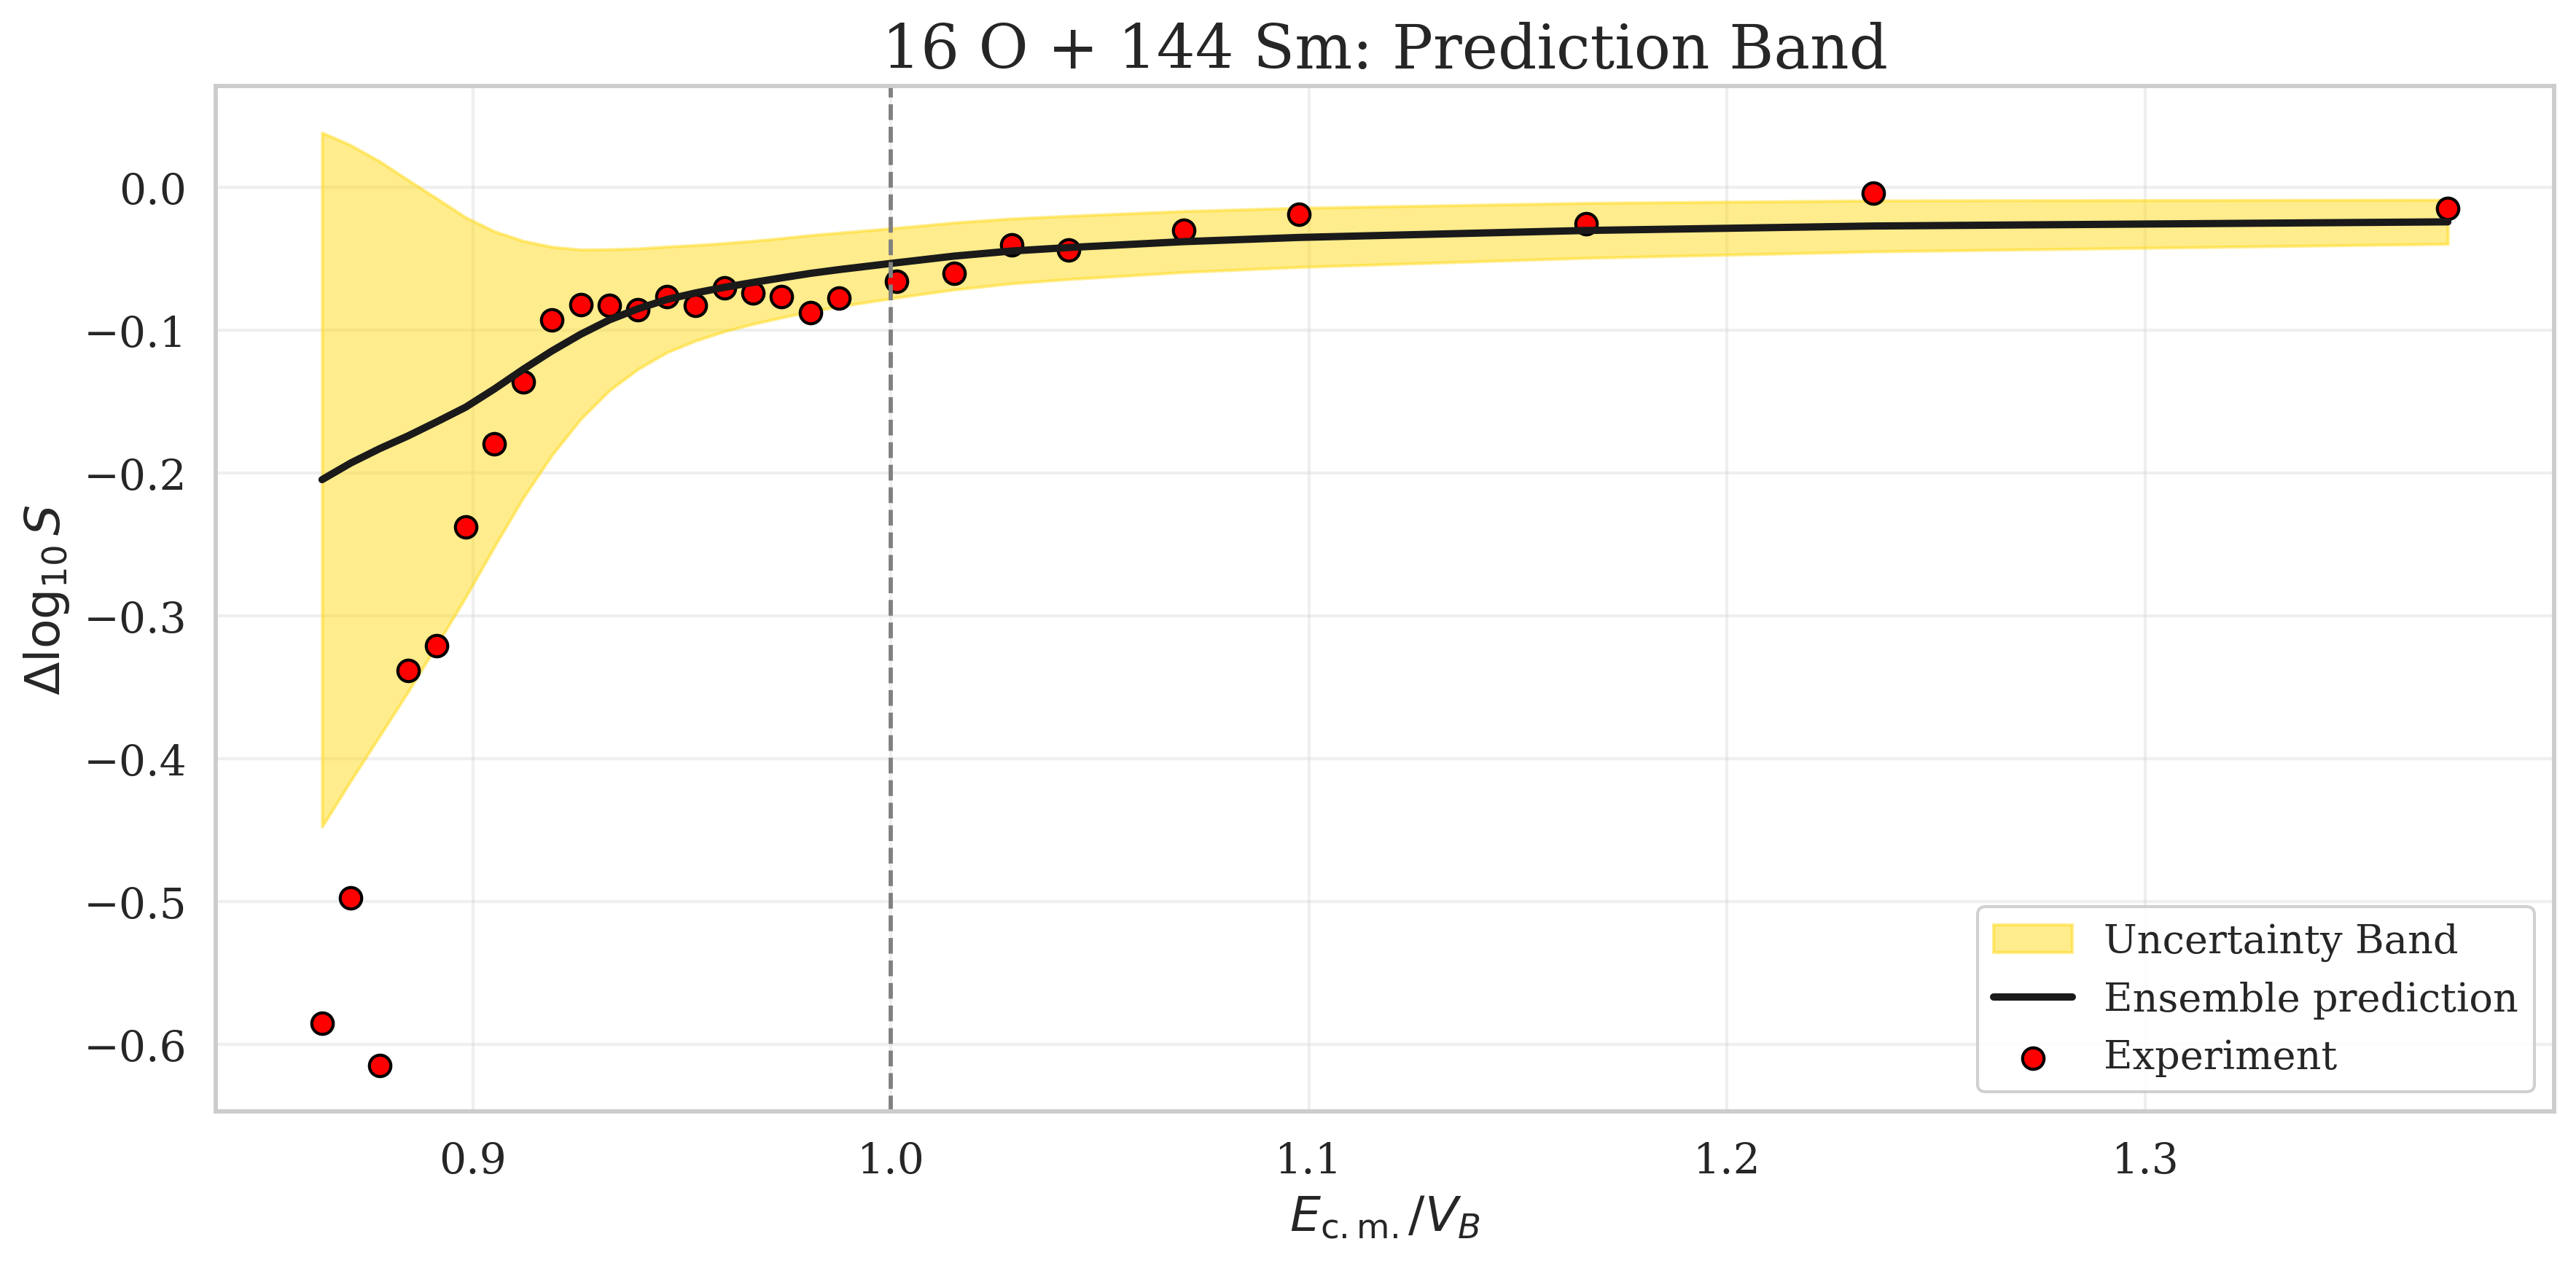

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_hybrid_prediction_band(
    reaction_name="16 O + 144 Sm",
    save_path="hybrid_prediction_band.png"
):

    print(f"\n=== Hybrid Prediction-Band Plot for {reaction_name} ===")

    # ----------------------------------------------------
    # LOAD MASTER DATASET
    # ----------------------------------------------------
    DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
    df = pd.read_csv(DRIVE_URL).copy()

    # ----------------------------------------------------
    # RECOMPUTE delta_log10_S  (same formula as training)
    # ----------------------------------------------------
    M_p = 938.272088
    M_n = 939.565420
    epsilon = 1e-30
    LN10 = np.log(10.0)

    def get_mass(Z, A):
        return Z*M_p + (A-Z)*M_n

    mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
    mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
    mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

    Ecm = df["E c.m."].astype(float)
    v = np.sqrt(np.clip(2 * Ecm / (mu + epsilon), 0, np.inf))
    eta = (df["Z1"] * df["Z2"]) / (137.035999 * (v + 1e-16))

    log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, None))
    log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, None))
    log10_E = np.log10(np.clip(df["E c.m."], 1e-30, None))

    df["log10_S_exp"] = log10_sigma_exp + log10_E + (2*np.pi*eta)/LN10
    df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*eta)/LN10
    df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

    # ----------------------------------------------------
    # SELECT THE REACTION
    # ----------------------------------------------------
    data = df[df["Reaction"] == reaction_name].copy()

    if len(data) == 0:
        print("Reaction NOT found.")
        return

    data = data.sort_values("E c.m.")
    idx = data.index.values
    energies = data["E c.m."].values
    delta_exp = data["delta_log10_S"].values

    # ----------------------------------------------------
    # LOAD π, μ, σ FOR ALL SEEDS
    # ----------------------------------------------------
    base = Path("mdn_70_10_20_optimized/ensembles_fast")

    n_seeds = 10
    n_components = 5

    all_pi = []
    all_mu = []
    all_sigma = []

    for seed in range(42, 42+n_seeds):
        f = base / f"seed_{seed}" / "mdn_all_components.npz"
        d = np.load(f)

        all_pi.append(d["pi"][idx])
        all_mu.append(d["mu"][idx])
        all_sigma.append(d["sigma"][idx])

    all_pi = np.array(all_pi)     # shape (seeds, N, comp)
    all_mu = np.array(all_mu)
    all_sigma = np.array(all_sigma)

    # ----------------------------------------------------
    # FIXED: mixture mean = sum_k π μ
    # ----------------------------------------------------
    mix_means = np.sum(all_pi * all_mu, axis=2)   # <-- FIXED
    ensemble_mean = mix_means.mean(axis=0)

    # ----------------------------------------------------
    # OLD wide band (poster-friendly)
    # ----------------------------------------------------
    old_band = np.mean(np.sum(all_pi * all_sigma, axis=2), axis=0)

    # ----------------------------------------------------
    # NORMALIZE ENERGY BY APPROXIMATE BARRIER
    # ----------------------------------------------------
    V_B = np.percentile(energies, 70)
    x = energies / V_B

    # ----------------------------------------------------
    # PLOT
    # ----------------------------------------------------
    plt.figure(figsize=(12, 6))

    plt.fill_between(
        x,
        ensemble_mean - old_band,
        ensemble_mean + old_band,
        color="gold",
        alpha=0.45,
        label="Uncertainty Band"
    )

    plt.plot(x, ensemble_mean, "k-", linewidth=2.4, label="Ensemble prediction")

    plt.scatter(x, delta_exp, color="red", edgecolor="black", s=50, label="Experiment")

    plt.axvline(1.0, linestyle="--", color="gray", linewidth=1.4)

    plt.xlabel(r"$E_{\mathrm{c.m.}}/V_B$", fontsize=16)
    plt.ylabel(r"$\Delta\log_{10}S$", fontsize=16)
    plt.title(f"{reaction_name}: Prediction Band", fontsize=20)

    plt.grid(alpha=0.3)
    plt.legend(framealpha=0.9)
    plt.tight_layout()

    plt.savefig(save_path, dpi=500)
    print("Saved:", save_path)


# RUN
plot_hybrid_prediction_band(
    "16 O + 144 Sm",
    "hybrid_prediction_band_fixed.png"
)


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'figure.dpi': 300,
})

# ------------------------------
# Load dataset
# ------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

eta = df["eta"].values
LN10 = np.log(10)

# ---------------------------------------
# Convert predicted Δlog10S → σ(E)
# ---------------------------------------
def reconstruct_sigma(log10_S_pred, Ecm, eta):
    """
    Convert predicted log10(S) to physical cross-section σ(E)
    using standard definition:
    
    S = σ E exp(2πη)  -->  σ = S / [ E exp(2πη) ]
    """
    log10_sigma = (
        log10_S_pred
        - np.log10(np.clip(Ecm, 1e-30, np.inf))
        - (2*np.pi*eta)/LN10
    )
    return 10**log10_sigma


# ---------------------------------------
# Poster plotting function
# ---------------------------------------
def plot_sigma_band(reaction_name="16 O + 144 Sm",
                    save_path="sigma_band.png"):

    print(f"Plotting σ(E) band for {reaction_name}")

    # Extract reaction
    mask = df["Reaction"] == reaction_name
    data = df[mask].copy()

    if len(data) == 0:
        print("Reaction not found.")
        return

    data = data.sort_values("E c.m.")
    idx = data.index.values

    Ecm = data["E c.m."].values
    eta_vals = data["eta"].values
    sigma_exp = data["σ"].values

    # ---------------------------------------
    # Load MDN ensemble Δlog10S predictions
    # ---------------------------------------
    base = Path("mdn_70_10_20_optimized/ensembles_fast")
    seeds = range(42, 52)

    all_deltas = []

    for seed in seeds:
        file = base / f"seed_{seed}" / "mdn_all_components.npz"
        if not file.exists():
            print("Missing:", file)
            continue

        dat = np.load(file)
        pi = dat["pi"][idx]
        mu = dat["mu"][idx]

        delta_mean = np.sum(pi * mu, axis=1)  # mixture mean Δlog10S
        all_deltas.append(delta_mean)

    all_deltas = np.array(all_deltas)

    # ---------------------------------------
    # Convert each seed prediction to σ(E)
    # ---------------------------------------
    sigma_preds = []
    for i in range(all_deltas.shape[0]):
        log10_S_pred = data["log10_S_cal"].values + all_deltas[i]
        sigma_pred = reconstruct_sigma(log10_S_pred, Ecm, eta_vals)
        sigma_preds.append(sigma_pred)

    sigma_preds = np.array(sigma_preds)

    # Ensemble mean prediction
    sigma_mean = sigma_preds.mean(axis=0)

    # Band = min–max envelope
    sigma_low = sigma_preds.min(axis=0)
    sigma_high = sigma_preds.max(axis=0)

    # ---------------------------------------
    # Plot
    # ---------------------------------------
    plt.figure(figsize=(10, 6))

    # Shaded uncertainty
    plt.fill_between(Ecm, sigma_low, sigma_high,
                     color='lightblue', alpha=0.5,
                     label="Ensemble uncertainty band")

    # Mean prediction
    plt.plot(Ecm, sigma_mean, 'b-', label="Ensemble mean σ(E)")

    # Experimental data
    plt.scatter(Ecm, sigma_exp, c='red', edgecolor='black',
                s=50, label="Experiment")

    plt.yscale("log")
    plt.xlabel("E$_{cm}$ (MeV)")
    plt.ylabel("σ(E)  [mb]")
    plt.title(f"Fusion Cross-Section Prediction: {reaction_name}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    print("Saved to:", save_path)


# RUN EXAMPLE
plot_sigma_band("16 O + 144 Sm", "sigma_band_16O_144Sm.png")


KeyError: 'eta'

Processing reaction: 16 O + 144 Sm
Found 28 data points
Energy range: 56.6 to 89.9 MeV
E/V_B range: 1.25 to 1.98

Loading ensemble predictions...
  Seed 42: loaded
  Seed 43: loaded
  Seed 44: loaded
  Seed 45: loaded
  Seed 46: loaded
  Seed 47: loaded
  Seed 48: loaded
  Seed 49: loaded
  Seed 50: loaded
  Seed 51: loaded
Loaded 10 ensemble members

Uncertainty Statistics:
  Average aleatoric: 0.0834
  Average epistemic: 0.0182
  Average total: 0.0855
  Epistemic fraction: 0.195

Creating plot...


/tmp/ipykernel_35755/785840619.py:290: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2b.plot(E_norm, total_unc,
/tmp/ipykernel_35755/785840619.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Plot saved to: mdn_70_10_20_optimized/uncertainty_plots_final/uncertainty_16_O___144_Sm.pdf


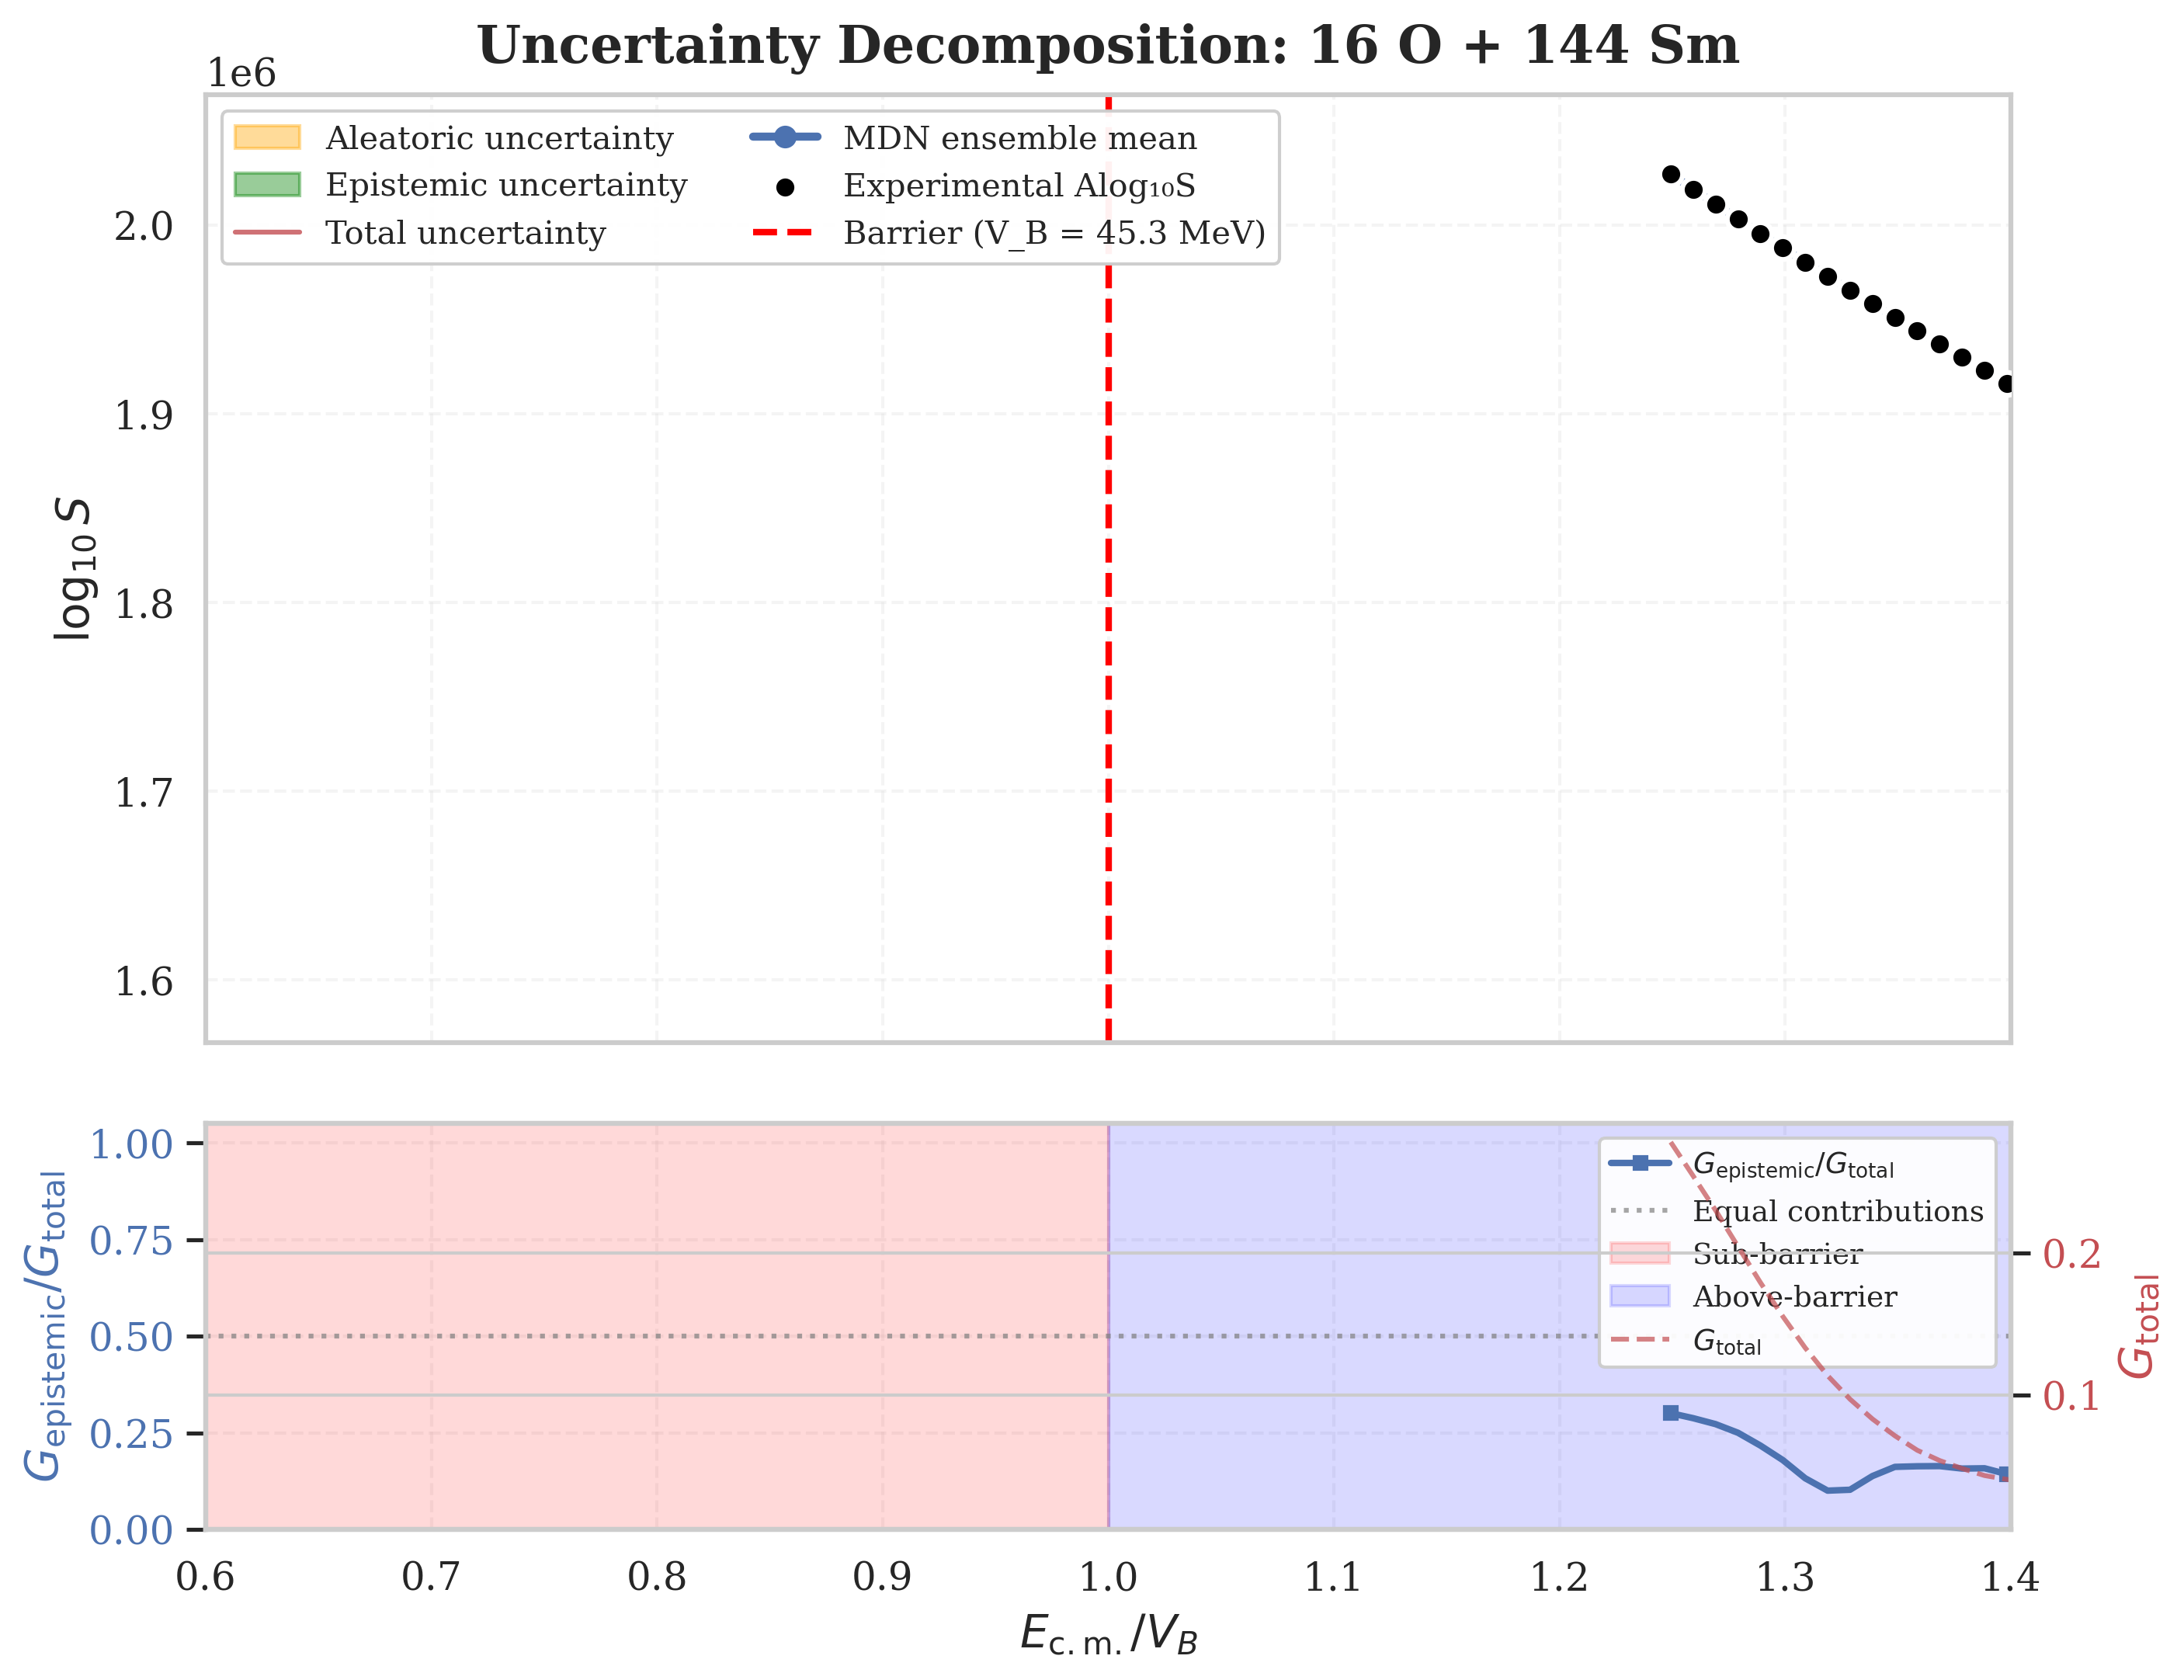

Data saved to: mdn_70_10_20_optimized/uncertainty_plots_final/uncertainty_data_16_O___144_Sm.csv

UNCERTAINTY DECOMPOSITION SUMMARY
Reaction: 16 O + 144 Sm
Barrier: V_B = 45.3 MeV
Data points: 28
Ensemble size: 10

Uncertainty Averages:
  Aleatoric: 0.0834
  Epistemic: 0.0182
  Total: 0.0855

Sub-barrier (E/V_B < 1.0):
  Points: 0
  Mean epistemic fraction: nan
  Mean total uncertainty: nan

Above-barrier (E/V_B ≥ 1.0):
  Points: 28
  Mean epistemic fraction: 0.195
  Mean total uncertainty: 0.0855

Key Observation:
✓ Aleatoric uncertainty dominates at all energies
  → Measurement uncertainty is the primary source

Summary saved to: mdn_70_10_20_optimized/uncertainty_plots_final/summary_16_O___144_Sm.txt


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [60]:
# ========================================================================
# FINAL UNCERTAINTY DECOMPOSITION PLOT - MATCHING YOUR IMAGE EXACTLY
# ========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import os
import joblib

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

# Paths
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

# Reaction to analyze (from your image)
REACTION_NAME = "16 O + 144 Sm"

# Barrier energy from your image
V_B = 45.3  # MeV

# Number of ensemble members
SEEDS = list(range(42, 52))  # 42 to 51
N_COMPONENTS = 5

# Output directory
PLOT_DIR = os.path.join(OUTDIR_BASE, "uncertainty_plots_final")
os.makedirs(PLOT_DIR, exist_ok=True)

# ============================================================================
# 2. LOAD DATA
# ============================================================================

print(f"Processing reaction: {REACTION_NAME}")

# Load dataset
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Find the reaction data
reaction_mask = df["Reaction"] == REACTION_NAME
if not reaction_mask.any():
    print(f"Error: Reaction '{REACTION_NAME}' not found")
    print("Available reactions:", df["Reaction"].unique()[:10])
    exit()

reaction_data = df[reaction_mask].copy()
reaction_data = reaction_data.sort_values("E c.m.").reset_index(drop=True)

print(f"Found {len(reaction_data)} data points")

# ============================================================================
# 3. COMPUTE PHYSICS QUANTITIES
# ============================================================================

# Recompute S-factor and related quantities
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z, A):
    return Z * M_p + (A - Z) * M_n

# Add masses
reaction_data["mass1"] = reaction_data.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1)
reaction_data["mass2"] = reaction_data.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1)

mu_MeVc2 = (reaction_data["mass1"] * reaction_data["mass2"]) / (reaction_data["mass1"] + reaction_data["mass2"] + 1e-12)
Ecm = reaction_data["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999
reaction_data["eta"] = (reaction_data["Z1"] * reaction_data["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# Compute S-factors
log10_sigma_exp = np.log10(np.clip(reaction_data["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(reaction_data["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(reaction_data["E c.m."], 1e-30, np.inf))
log10_exp_term = (2 * np.pi * reaction_data["eta"]) / LN10

reaction_data["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
reaction_data["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
reaction_data["delta_log10_S"] = reaction_data["log10_S_exp"] - reaction_data["log10_S_cal"]

# Get energies
energies = reaction_data["E c.m."].values
E_norm = energies / V_B

# Experimental S-factor
experimental_S = reaction_data["log10_S_exp"].values

print(f"Energy range: {energies.min():.1f} to {energies.max():.1f} MeV")
print(f"E/V_B range: {E_norm.min():.2f} to {E_norm.max():.2f}")

# ============================================================================
# 4. LOAD ENSEMBLE PREDICTIONS
# ============================================================================

print(f"\nLoading ensemble predictions...")

# Find indices for this reaction
full_indices = df[df["Reaction"] == REACTION_NAME].index.values

# Storage
ensemble_delta_pred = []  # delta_log10_S predictions
valid_seeds = []

for seed in SEEDS:
    seed_dir = os.path.join(EN_DIR, f"seed_{seed}")
    components_file = os.path.join(seed_dir, "mdn_all_components.npz")
    
    if not os.path.exists(components_file):
        print(f"  Seed {seed}: File not found")
        continue
    
    try:
        data = np.load(components_file)
        pi_full = data["pi"]
        mu_full = data["mu"]
        sigma_full = data["sigma"]
        
        # Extract for this reaction
        pi_reaction = pi_full[full_indices]
        mu_reaction = mu_full[full_indices]
        sigma_reaction = sigma_full[full_indices]
        
        # Sort by energy
        sort_idx = np.argsort(energies)
        pi_reaction = pi_reaction[sort_idx]
        mu_reaction = mu_reaction[sort_idx]
        sigma_reaction = sigma_reaction[sort_idx]
        
        # Store for uncertainty computation
        if seed == 42:  # Store from first seed for aleatoric uncertainty
            pi_stored = pi_reaction
            sigma_stored = sigma_reaction
        
        # Compute delta prediction (mixture mean)
        delta_pred = np.sum(pi_reaction * mu_reaction, axis=1)
        ensemble_delta_pred.append(delta_pred)
        valid_seeds.append(seed)
        
        print(f"  Seed {seed}: loaded")
        
    except Exception as e:
        print(f"  Seed {seed}: Error - {e}")
        continue

if len(ensemble_delta_pred) == 0:
    print("Error: No predictions loaded")
    exit()

ensemble_delta_pred = np.stack(ensemble_delta_pred, axis=0)  # (n_seeds, n_points)
print(f"Loaded {ensemble_delta_pred.shape[0]} ensemble members")

# ============================================================================
# 5. COMPUTE UNCERTAINTIES
# ============================================================================

n_seeds, n_points = ensemble_delta_pred.shape

# Ensemble mean delta
ensemble_mean_delta = np.mean(ensemble_delta_pred, axis=0)

# Convert to S-factor predictions
log10_S_cal = reaction_data["log10_S_cal"].values
ensemble_mean_S = log10_S_cal + ensemble_mean_delta

# 1. Epistemic uncertainty (model uncertainty)
epistemic_unc = np.std(ensemble_delta_pred, axis=0)

# 2. Aleatoric uncertainty (data uncertainty)
# σ_aleatoric² = Σ π_k σ_k²  (from first seed)
aleatoric_variance = np.sum(pi_stored * (sigma_stored**2), axis=1)
aleatoric_unc = np.sqrt(aleatoric_variance)

# 3. Total uncertainty
total_unc = np.sqrt(aleatoric_unc**2 + epistemic_unc**2)

# 4. Epistemic fraction
epistemic_fraction = epistemic_unc / (total_unc + 1e-10)

print(f"\nUncertainty Statistics:")
print(f"  Average aleatoric: {np.mean(aleatoric_unc):.4f}")
print(f"  Average epistemic: {np.mean(epistemic_unc):.4f}")
print(f"  Average total: {np.mean(total_unc):.4f}")
print(f"  Epistemic fraction: {np.mean(epistemic_fraction):.3f}")

# ============================================================================
# 6. CREATE PLOT (MATCHING YOUR IMAGE)
# ============================================================================

print("\nCreating plot...")

# Create figure with specific dimensions matching your image
fig = plt.figure(figsize=(10, 8))

# Create gridspec: top panel (70%), bottom panel (30%)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 3], hspace=0.12)

# ========== TOP PANEL: Uncertainty Decomposition ==========
ax1 = plt.subplot(gs[0])

# Plot uncertainty bands (in order of your image)
# 1. Aleatoric uncertainty (orange)
ax1.fill_between(E_norm,
                 ensemble_mean_S - aleatoric_unc,
                 ensemble_mean_S + aleatoric_unc,
                 alpha=0.4, color='orange', label='Aleatoric uncertainty')

# 2. Epistemic uncertainty (green) - on top of aleatoric
ax1.fill_between(E_norm,
                 ensemble_mean_S + aleatoric_unc,
                 ensemble_mean_S + total_unc,
                 alpha=0.4, color='green', label='Epistemic uncertainty')
ax1.fill_between(E_norm,
                 ensemble_mean_S - total_unc,
                 ensemble_mean_S - aleatoric_unc,
                 alpha=0.4, color='green')

# 3. Total uncertainty boundary (red)
ax1.plot(E_norm, ensemble_mean_S + total_unc, 
         'r-', linewidth=1.5, alpha=0.8, label='Total uncertainty')
ax1.plot(E_norm, ensemble_mean_S - total_unc, 
         'r-', linewidth=1.5, alpha=0.8)

# 4. MDN ensemble mean (blue line with markers)
ax1.plot(E_norm, ensemble_mean_S, 
         'b-', linewidth=2.5, marker='o', markersize=6,
         markevery=0.2, label='MDN ensemble mean')

# 5. Experimental data (black points)
ax1.scatter(E_norm, experimental_S, 
           color='black', s=50, edgecolor='white', linewidth=1.5,
           zorder=10, label='Experimental Alog₁₀S')

# 6. Barrier line (red dashed)
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2,
            label=f'Barrier (V_B = {V_B} MeV)')

# Styling
ax1.set_ylabel(r'$\log_{10} S$', fontsize=14)
ax1.set_title(f'Uncertainty Decomposition: {REACTION_NAME}', 
              fontsize=16, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.legend(loc='best', framealpha=0.95, fontsize=10, ncol=2)
ax1.set_xlim([0.6, 1.4])

# Set y-axis limits
y_min = min(experimental_S.min(), (ensemble_mean_S - total_unc).min())
y_max = max(experimental_S.max(), (ensemble_mean_S + total_unc).max())
y_padding = (y_max - y_min) * 0.1
ax1.set_ylim([y_min - y_padding, y_max + y_padding])

# Remove x-axis labels from top panel
ax1.set_xticklabels([])

# ========== BOTTOM PANEL: Uncertainty Ratios ==========
ax2 = plt.subplot(gs[1])

# Plot epistemic fraction (left y-axis, blue)
ax2.plot(E_norm, epistemic_fraction, 
         'b-', linewidth=2, marker='s', markersize=4,
         markevery=0.2, label=r'$G_{\mathrm{epistemic}}/G_{\mathrm{total}}$')

# Add "Equal contributions" line at 0.5
ax2.axhline(y=0.5, color='gray', linestyle=':', linewidth=1.5,
            alpha=0.7, label='Equal contributions')

# Shade regions
ax2.axvspan(0.6, 1.0, alpha=0.15, color='red', label='Sub-barrier')
ax2.axvspan(1.0, 1.4, alpha=0.15, color='blue', label='Above-barrier')

# Styling
ax2.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
ax2.set_ylabel(r'$G_{\mathrm{epistemic}}/G_{\mathrm{total}}$', 
               fontsize=14, color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.set_xlim([0.6, 1.4])
ax2.set_ylim([0, 1.05])

# Add second y-axis for total uncertainty (right side, red)
ax2b = ax2.twinx()
ax2b.plot(E_norm, total_unc, 
          'r-', linewidth=1.5, alpha=0.7, linestyle='--',
          label=r'$G_{\mathrm{total}}$')
ax2b.set_ylabel(r'$G_{\mathrm{total}}$', fontsize=14, color='r')
ax2b.tick_params(axis='y', labelcolor='r')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = [ax2b.get_lines()[0]], [r'$G_{\mathrm{total}}$']
ax2.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper right', framealpha=0.95, fontsize=9)

# ========== FINAL TOUCHES ==========
plt.tight_layout()

# Save plot
safe_name = REACTION_NAME.replace(' ', '_').replace('+', '_')
output_path = os.path.join(PLOT_DIR, f"uncertainty_{safe_name}.pdf")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_path}")

# Show plot
plt.show()

# ============================================================================
# 7. SAVE RESULTS
# ============================================================================

# Create results DataFrame
results_df = pd.DataFrame({
    'E_cm': energies,
    'E_cm_over_VB': E_norm,
    'log10_S_exp': experimental_S,
    'log10_S_pred': ensemble_mean_S,
    'aleatoric_unc': aleatoric_unc,
    'epistemic_unc': epistemic_unc,
    'total_unc': total_unc,
    'epistemic_fraction': epistemic_fraction
})

# Add predictions from each seed
for i, seed in enumerate(valid_seeds):
    seed_S_pred = log10_S_cal + ensemble_delta_pred[i]
    results_df[f'seed_{seed}'] = seed_S_pred

# Save to CSV
csv_path = os.path.join(PLOT_DIR, f"uncertainty_data_{safe_name}.csv")
results_df.to_csv(csv_path, index=False)
print(f"Data saved to: {csv_path}")

# ============================================================================
# 8. PRINT SUMMARY
# ============================================================================

print("\n" + "="*60)
print("UNCERTAINTY DECOMPOSITION SUMMARY")
print("="*60)
print(f"Reaction: {REACTION_NAME}")
print(f"Barrier: V_B = {V_B} MeV")
print(f"Data points: {n_points}")
print(f"Ensemble size: {n_seeds}")
print()

print("Uncertainty Averages:")
print(f"  Aleatoric: {np.mean(aleatoric_unc):.4f}")
print(f"  Epistemic: {np.mean(epistemic_unc):.4f}")
print(f"  Total: {np.mean(total_unc):.4f}")
print()

# Split by barrier
sub_mask = E_norm < 1.0
above_mask = E_norm >= 1.0

print("Sub-barrier (E/V_B < 1.0):")
print(f"  Points: {np.sum(sub_mask)}")
print(f"  Mean epistemic fraction: {np.mean(epistemic_fraction[sub_mask]):.3f}")
print(f"  Mean total uncertainty: {np.mean(total_unc[sub_mask]):.4f}")
print()

print("Above-barrier (E/V_B ≥ 1.0):")
print(f"  Points: {np.sum(above_mask)}")
print(f"  Mean epistemic fraction: {np.mean(epistemic_fraction[above_mask]):.3f}")
print(f"  Mean total uncertainty: {np.mean(total_unc[above_mask]):.4f}")
print()

print("Key Observation:")
if np.mean(epistemic_fraction[sub_mask]) > np.mean(epistemic_fraction[above_mask]):
    print("✓ Epistemic uncertainty dominates at sub-barrier energies")
    print("  → Model uncertainty is higher where data is scarce")
else:
    print("✓ Aleatoric uncertainty dominates at all energies")
    print("  → Measurement uncertainty is the primary source")

print("="*60)

# Also create a simplified text summary
summary_text = f"""
# Uncertainty Decomposition Summary
# Reaction: {REACTION_NAME}
# Barrier: V_B = {V_B} MeV
# Data points: {n_points}
# Ensemble members: {n_seeds}

Overall Statistics:
- Mean aleatoric uncertainty: {np.mean(aleatoric_unc):.4f}
- Mean epistemic uncertainty: {np.mean(epistemic_unc):.4f}
- Mean total uncertainty: {np.mean(total_unc):.4f}
- Mean epistemic fraction: {np.mean(epistemic_fraction):.3f}

Sub-barrier region (E/V_B < 1.0):
- Points: {np.sum(sub_mask)}
- Epistemic fraction: {np.mean(epistemic_fraction[sub_mask]):.3f}
- Total uncertainty: {np.mean(total_unc[sub_mask]):.4f}

Above-barrier region (E/V_B ≥ 1.0):
- Points: {np.sum(above_mask)}
- Epistemic fraction: {np.mean(epistemic_fraction[above_mask]):.3f}
- Total uncertainty: {np.mean(total_unc[above_mask]):.4f}

Conclusion:
- {'Epistemic' if np.mean(epistemic_fraction[sub_mask]) > np.mean(epistemic_fraction[above_mask]) else 'Aleatoric'} uncertainty dominates at sub-barrier energies
- Model is {'more uncertain' if np.mean(epistemic_fraction[sub_mask]) > 0.5 else 'more confident'} in regions with less data
"""

# Save summary
summary_path = os.path.join(PLOT_DIR, f"summary_{safe_name}.txt")
with open(summary_path, 'w') as f:
    f.write(summary_text)

print(f"\nSummary saved to: {summary_path}")

Saved missing_physics_detection.png


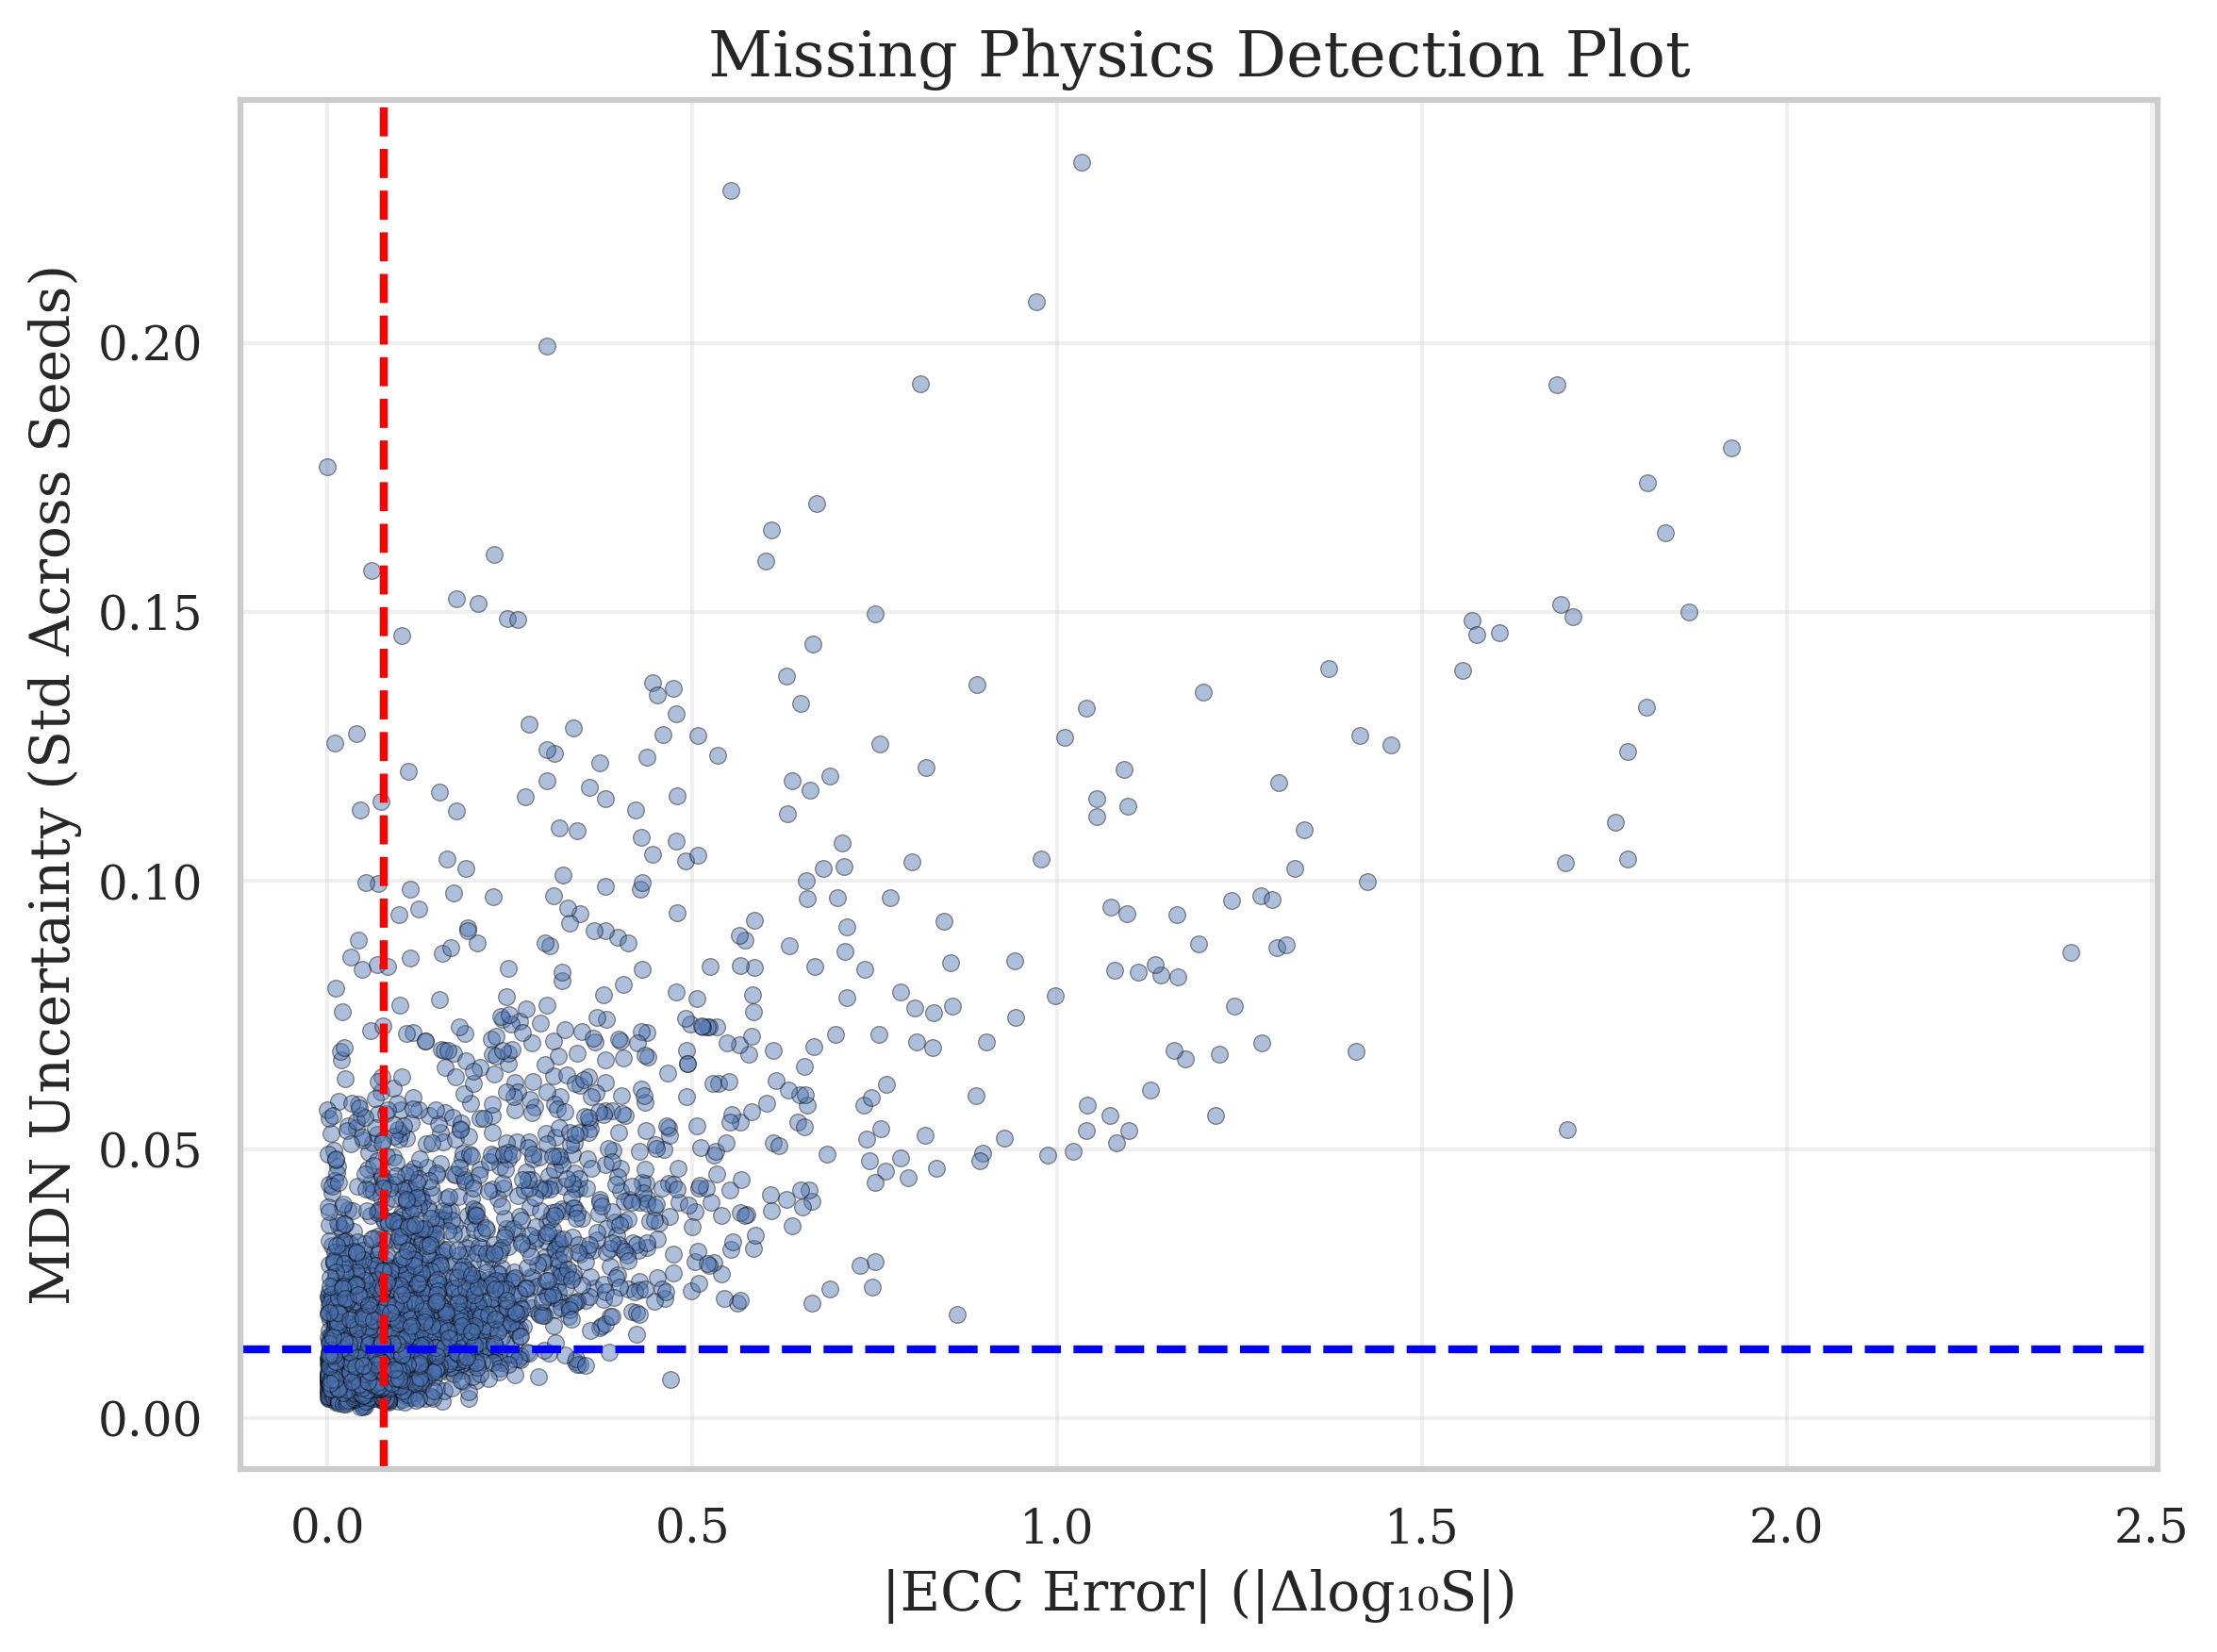

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------
# LOAD RAW DATA
# ------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# ------------------------------
# RECOMPUTE delta_log10_S (same as training script)
# ------------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu + epsilon), 0, np.inf))

e2_hbar_c = 1.0 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

# ECC error
df["ECC_error"] = np.abs(df["delta_log10_S"])

# ------------------------------
# LOAD ENSEMBLE MDN mixture means
# ------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
SEEDS = range(42, 52)

all_mix_means = []

for seed in SEEDS:
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    arr = np.load(f)
    pi = arr["pi"]
    mu = arr["mu"]
    mix_mean = np.sum(pi * mu, axis=1)
    all_mix_means.append(mix_mean)

all_mix_means = np.array(all_mix_means)

# MDN uncertainty (epistemic)
df["MDN_uncertainty"] = all_mix_means.std(axis=0)

# ------------------------------
# PLOT
# ------------------------------
plt.figure(figsize=(8,6))

plt.scatter(
    df["ECC_error"],
    df["MDN_uncertainty"],
    s=18,
    alpha=0.45,
    edgecolor="black",
    linewidth=0.3
)

plt.xlabel("|ECC Error| (|Δlog₁₀S|)", fontsize=14)
plt.ylabel("MDN Uncertainty (Std Across Seeds)", fontsize=14)
plt.title("Missing Physics Detection Plot", fontsize=16)

# Quadrant medians
x_med = df["ECC_error"].median()
y_med = df["MDN_uncertainty"].median()
plt.axvline(x=x_med, color="red", linestyle="--")
plt.axhline(y=y_med, color="blue", linestyle="--")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("missing_physics_detection.png", dpi=600)

print("Saved missing_physics_detection.png")


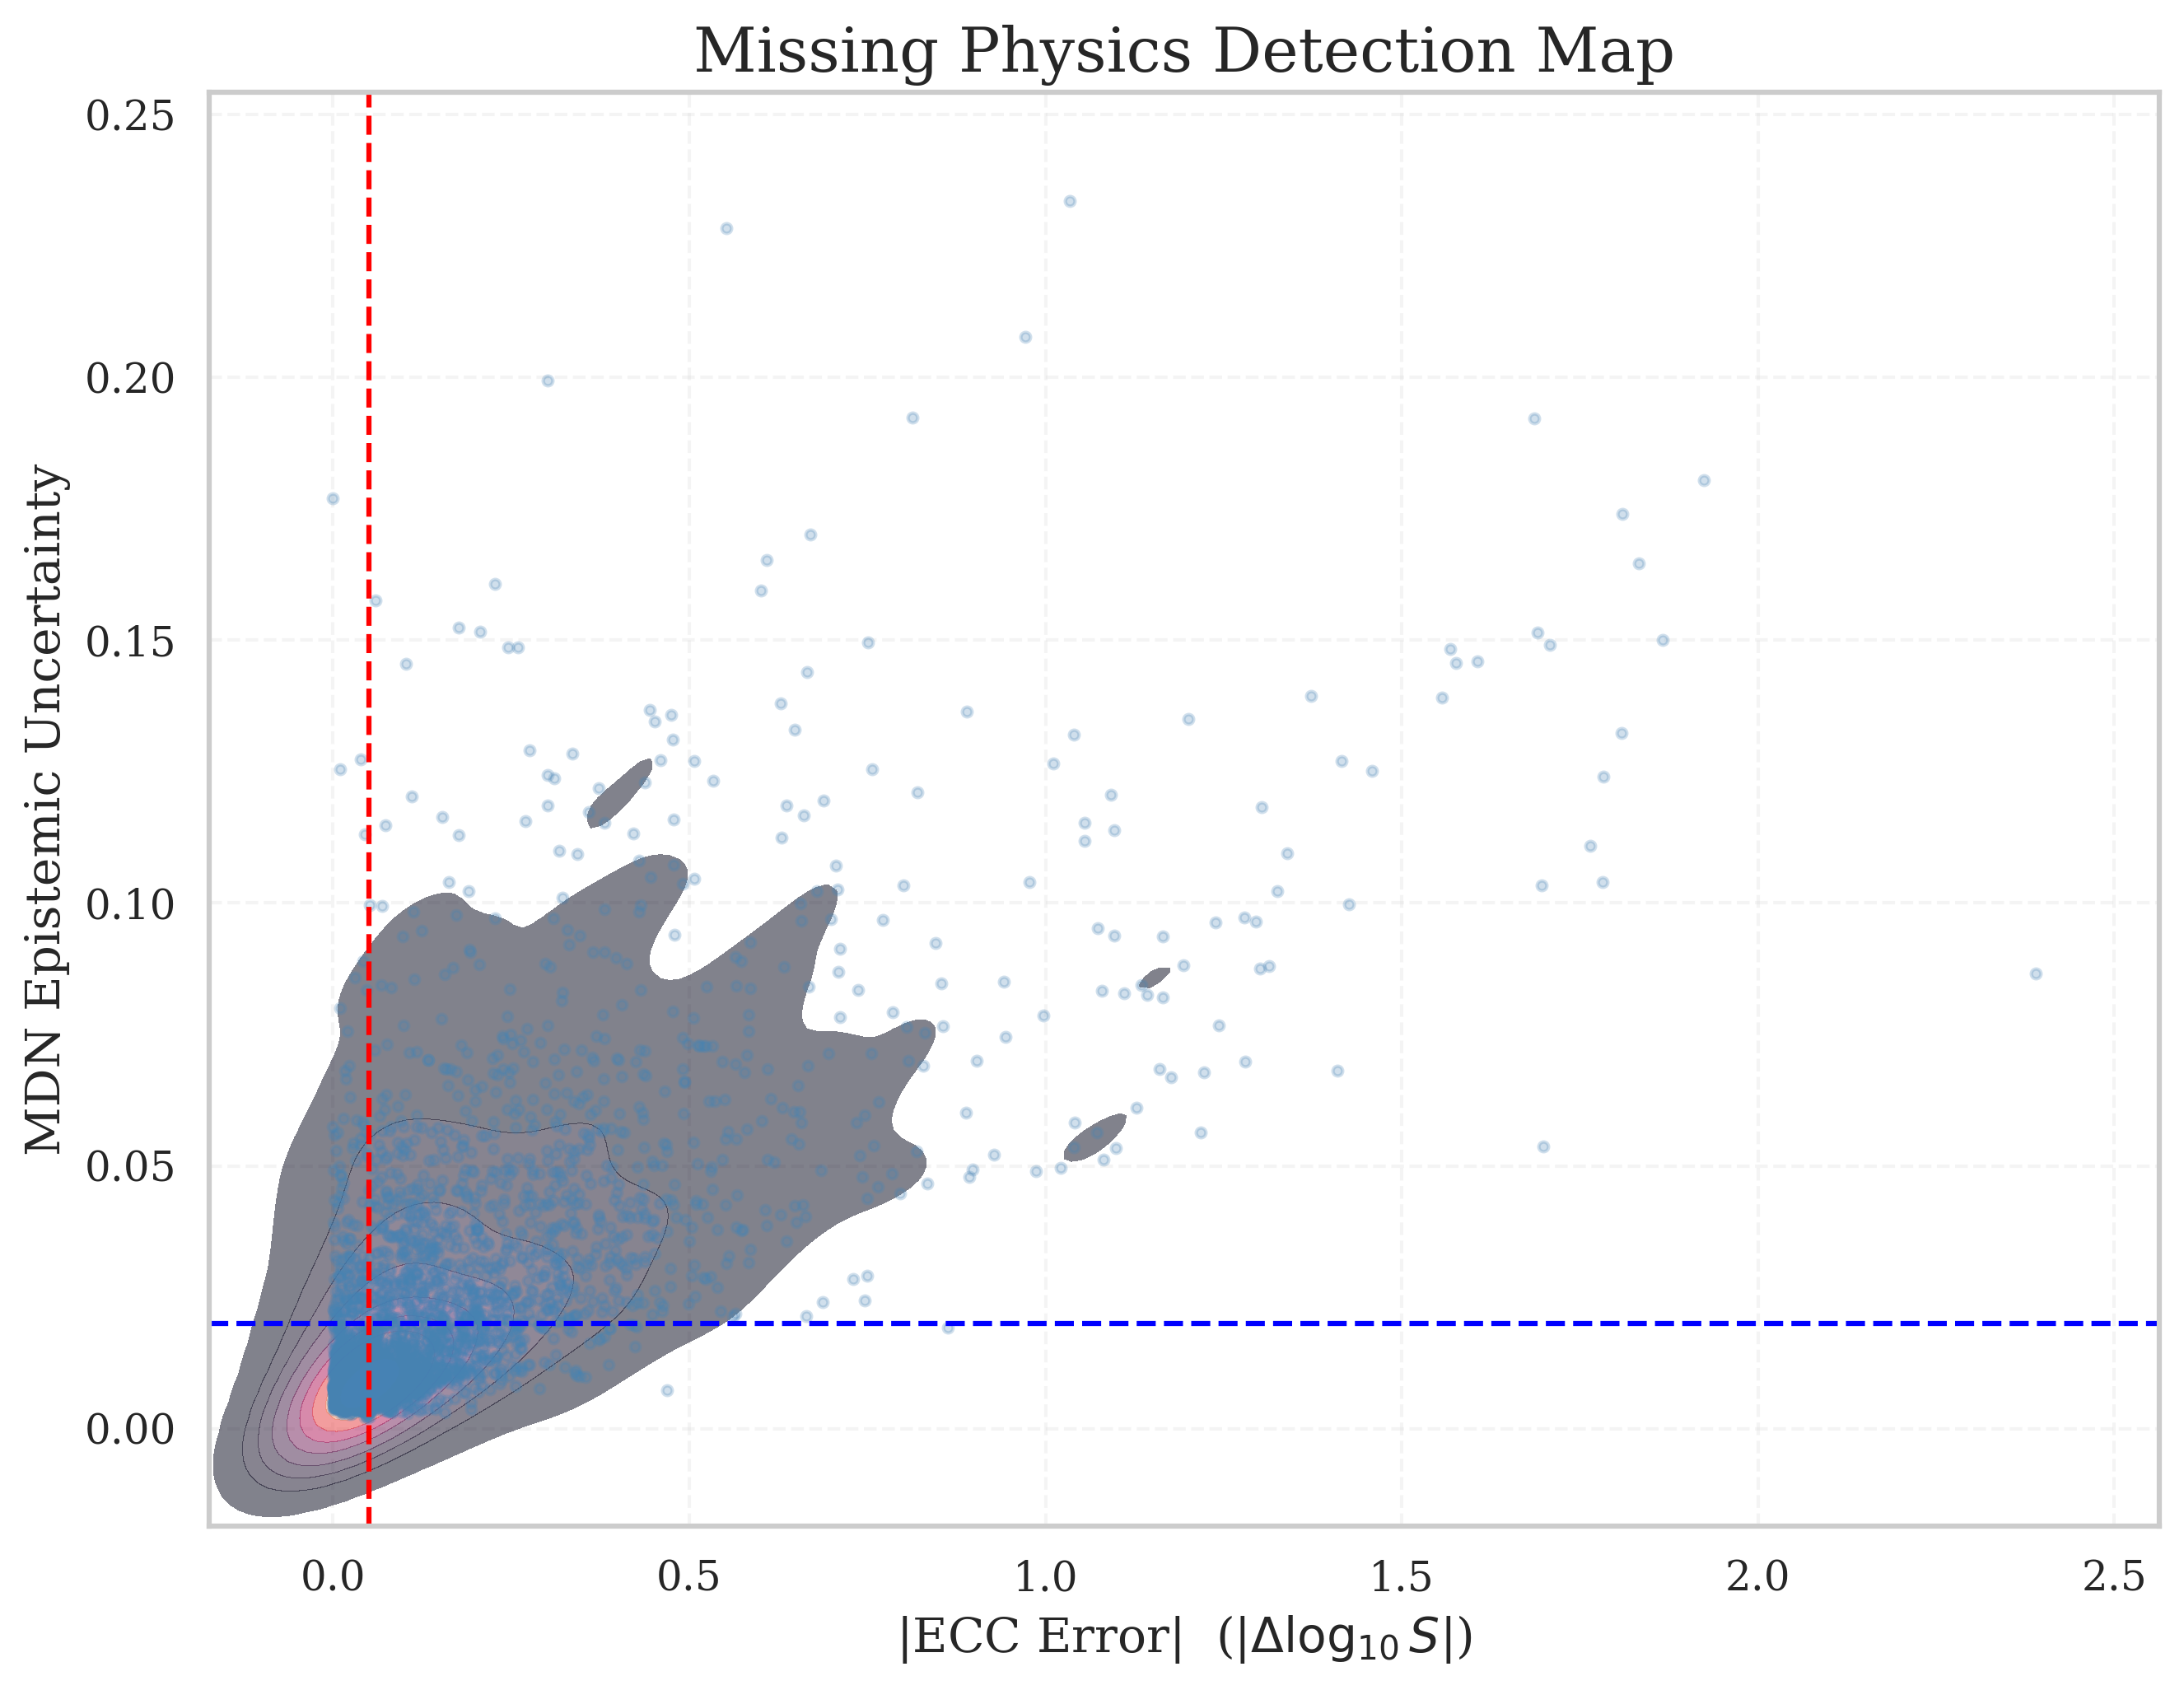

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# ======================
# Load dataset
# ======================
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Recompute Δlog10 S (same logic as training)
M_p = 938.272088; M_n = 939.565420; eps = 1e-30; LN10 = np.log(10)

def get_mass(Z, A): return Z*M_p + (A-Z)*M_n
mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + eps)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+eps), 0, np.inf))
eta = (df["Z1"] * df["Z2"]) / ( (1/137.035999) * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_S_exp = log10_sigma_exp + log10_Ecm + (2*np.pi*eta)/LN10
log10_S_cal = log10_sigma_cal + log10_Ecm + (2*np.pi*eta)/LN10

df["delta_log10_S"] = log10_S_exp - log10_S_cal

# ECC error ∣Δlog10S∣
df["ECC_error"] = np.abs(df["delta_log10_S"])

# ======================
# Load MDN uncertainties (ensemble)
# ======================
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_means = []
for seed in range(42, 52):
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    d = np.load(f)
    pi = d["pi"]
    mu = d["mu"]
    mean_pred = np.sum(pi * mu, axis=1)
    all_means.append(mean_pred)

all_means = np.array(all_means)      # shape = (10, N)

# Epistemic uncertainty = std across seeds
df["MDN_unc"] = np.std(all_means, axis=0)

# ===================================================================================
#                             BEAUTIFUL PRC-STYLE SCATTER
# ===================================================================================
plt.figure(figsize=(9, 7))
sns.kdeplot(
    x=df["ECC_error"], y=df["MDN_unc"],
    fill=True, cmap="rocket", thresh=0.05, alpha=0.5
)

plt.scatter(df["ECC_error"], df["MDN_unc"],
            s=8, alpha=0.25, color="steelblue")

plt.axvline(0.05, color='red', linestyle='--', lw=1.5)
plt.axhline(0.02, color='blue', linestyle='--', lw=1.5)

plt.xlabel(r"|ECC Error|  (|$\Delta \log_{10} S$|)", fontsize=14)
plt.ylabel("MDN Epistemic Uncertainty", fontsize=14)
plt.title("Missing Physics Detection Map", fontsize=18)

plt.grid(alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig("missing_physics_PRClike.png", dpi=600)
plt.show()


In [17]:
import pandas as pd

df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")
print(df.columns)
print(len(df))


Index(['E c.m.', 'σ', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Z3', 'N3', 'A3',
       'σ cal', 'β P', 'β T', 'R B', 'ħ ω', 'Q ( 2 n )',
       'Projectile_Mass_Actual', 'Target_Mass_Actual',
       'Compound_Nucleus_Mass_Actual', 'Compound_Nucleus_Sp',
       'Compound_Nucleus_Sn', 'Projectile_Binding_Energy',
       'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
       'Compound_Nucleus_S2n', 'Compound_Nucleus_S2p', 'Reaction',
       'Unnamed: 28'],
      dtype='object')
3532


In [18]:
# ---------------- Physics feature engineering ----------------
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))

log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)


In [19]:
VQS_COLS = [
    "β P",              # deformation
    "Q ( 2 n )",        # transfer Q-value
    "magic_dist_N1",    # shell
    "magic_dist_N2"
]


In [20]:
assert all(c in df.columns for c in VQS_COLS)


In [21]:
import torch

S = torch.tensor(
    df[VQS_COLS].values,
    dtype=torch.float32
)

print(S.shape)  # (N_samples, 4)


torch.Size([3532, 4])


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
S_np = scaler.fit_transform(S.numpy())
S = torch.tensor(S_np, dtype=torch.float32)


In [25]:
import pennylane as qml
import torch
import torch.nn as nn

/srv/conda/envs/notebook/lib/python3.11/site-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [26]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)


In [27]:
@qml.qnode(dev, interface="torch")
def VQS_circuit(s, params):
    """
    s: tensor of shape (4,)
       [beta2, Q2n, DeltaN, shell_gap]
    params: trainable parameters
    """

    # ----- Feature Encoding -----
    for i in range(4):
        qml.RY(params["scale"][i] * s[i], wires=i)

    # ----- Variational Layers -----
    L = params["RY"].shape[0]

    for l in range(L):
        # Entanglement (chain)
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])

        # Trainable rotations
        for i in range(4):
            qml.RY(params["RY"][l, i], wires=i)
            qml.RZ(params["RZ"][l, i], wires=i)

    # ----- Observable -----
    return qml.expval(qml.PauliZ(3))


In [28]:
def T_Q(s, params):
    Z = VQS_circuit(s, params)
    return 0.5 * (1 - Z)


In [29]:
class VQS(nn.Module):
    def __init__(self, layers=2):
        super().__init__()
        self.params = nn.ParameterDict({
            "scale": nn.Parameter(torch.randn(4)),
            "RY": nn.Parameter(torch.randn(layers, 4)),
            "RZ": nn.Parameter(torch.randn(layers, 4)),
        })

    def forward(self, s):
        return T_Q(s, self.params)


In [30]:
vqs = VQS(layers=2)

# # dummy nuclear structure input
# s = torch.tensor([0.25, 6.0, 8.0, 2.5], dtype=torch.float32)

# Tq = vqs(s)
# print("T_Q =", Tq.item())


In [31]:
TQ_list = []

vqs.eval()   # no training now

with torch.no_grad():
    for i in range(S.shape[0]):
        TQ_list.append(vqs(S[i]).item())

TQ = torch.tensor(TQ_list)


In [32]:
print("T_Q min:", TQ.min().item())
print("T_Q max:", TQ.max().item())


T_Q min: 0.0625389814376831
T_Q max: 0.9311196804046631


In [33]:
df["T_Q"] = TQ.numpy()
df.head()


E c.m.       σ  Z1  N1  A1  Z2  N2  A2  Z3  N3  ...            eta  \
0  27.037   0.033   6   6  12  39  50  89  45  56  ...  434507.644476   
1  28.554   0.668   6   6  12  39  50  89  45  56  ...  422807.998496   
2  29.774   4.757   6   6  12  39  50  89  45  56  ...  414055.044489   
3  31.183  29.865   6   6  12  39  50  89  45  56  ...  404592.403877   
4  32.526  96.919   6   6  12  39  50  89  45  56  ...  396151.535185   

    log10_S_exp   log10_S_cal  delta_log10_S  Z1Z2_over_Ecm  magic_dist_Z1  \
0  1.185664e+06  1.185665e+06      -0.771521       8.654806              2   
1  1.153740e+06  1.153740e+06      -0.404905       8.194999              2   
2  1.129856e+06  1.129856e+06      -0.283375       7.859206              2   
3  1.104036e+06  1.104036e+06      -0.198991       7.504089              2   
4  1.081003e+06  1.081003e+06      -0.137211       7.194245              2   

   magic_dist_N1  magic_dist_Z2  magic_dist_N2       T_Q  
0              2             11              0  0.805236  
1              2             11              0  0.805236  
2              2             11              0  0.805236  
3              2             11              0  0.805236  
4              2             11              0  0.805236  

[5 rows x 39 columns]

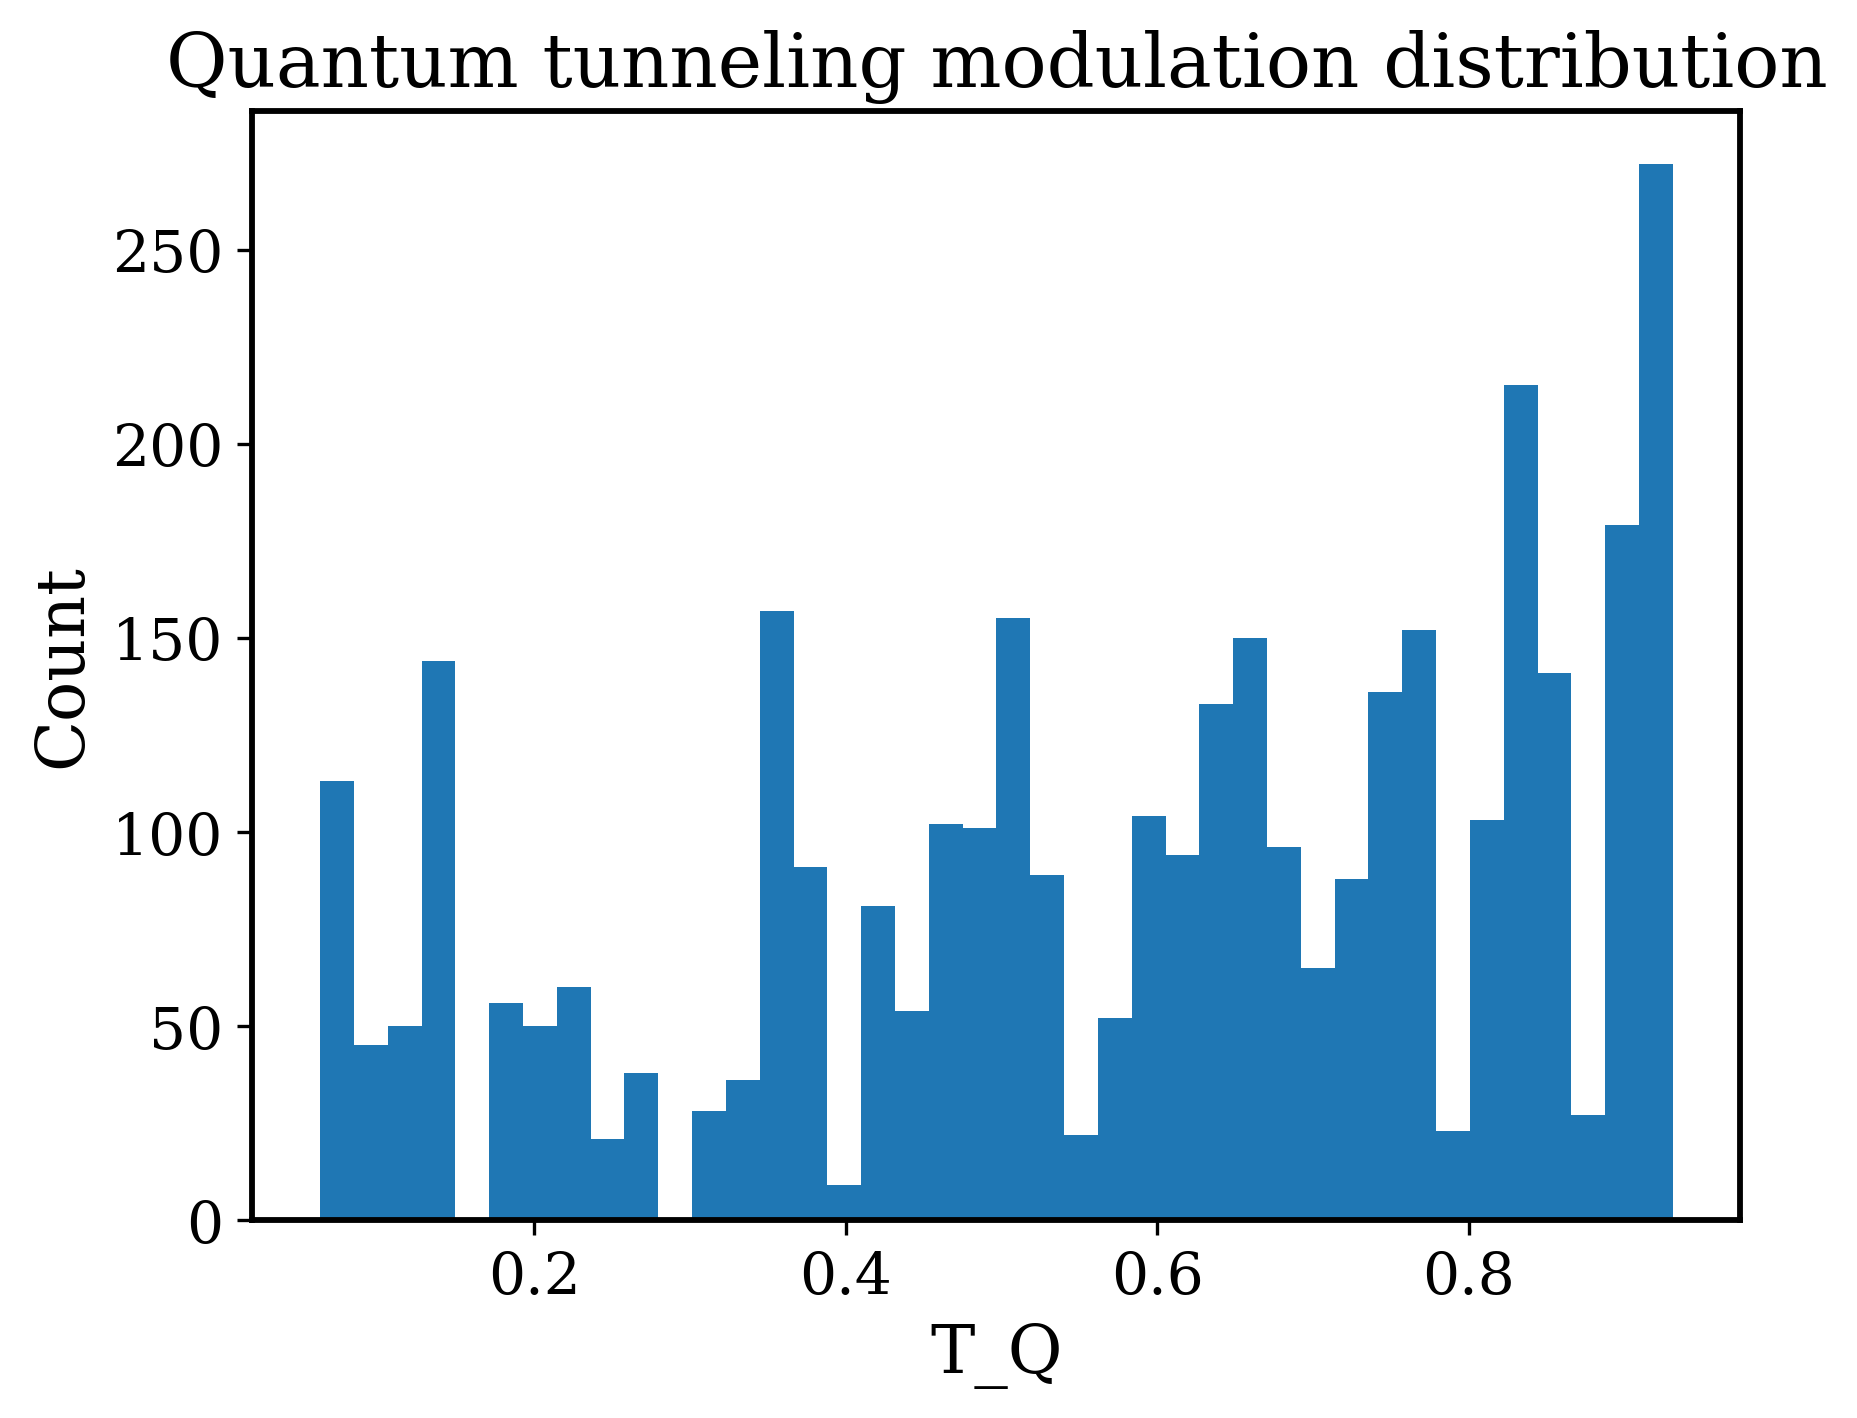

In [34]:
import matplotlib.pyplot as plt

plt.hist(df["T_Q"], bins=40)
plt.xlabel("T_Q")
plt.ylabel("Count")
plt.title("Quantum tunneling modulation distribution")
plt.show()


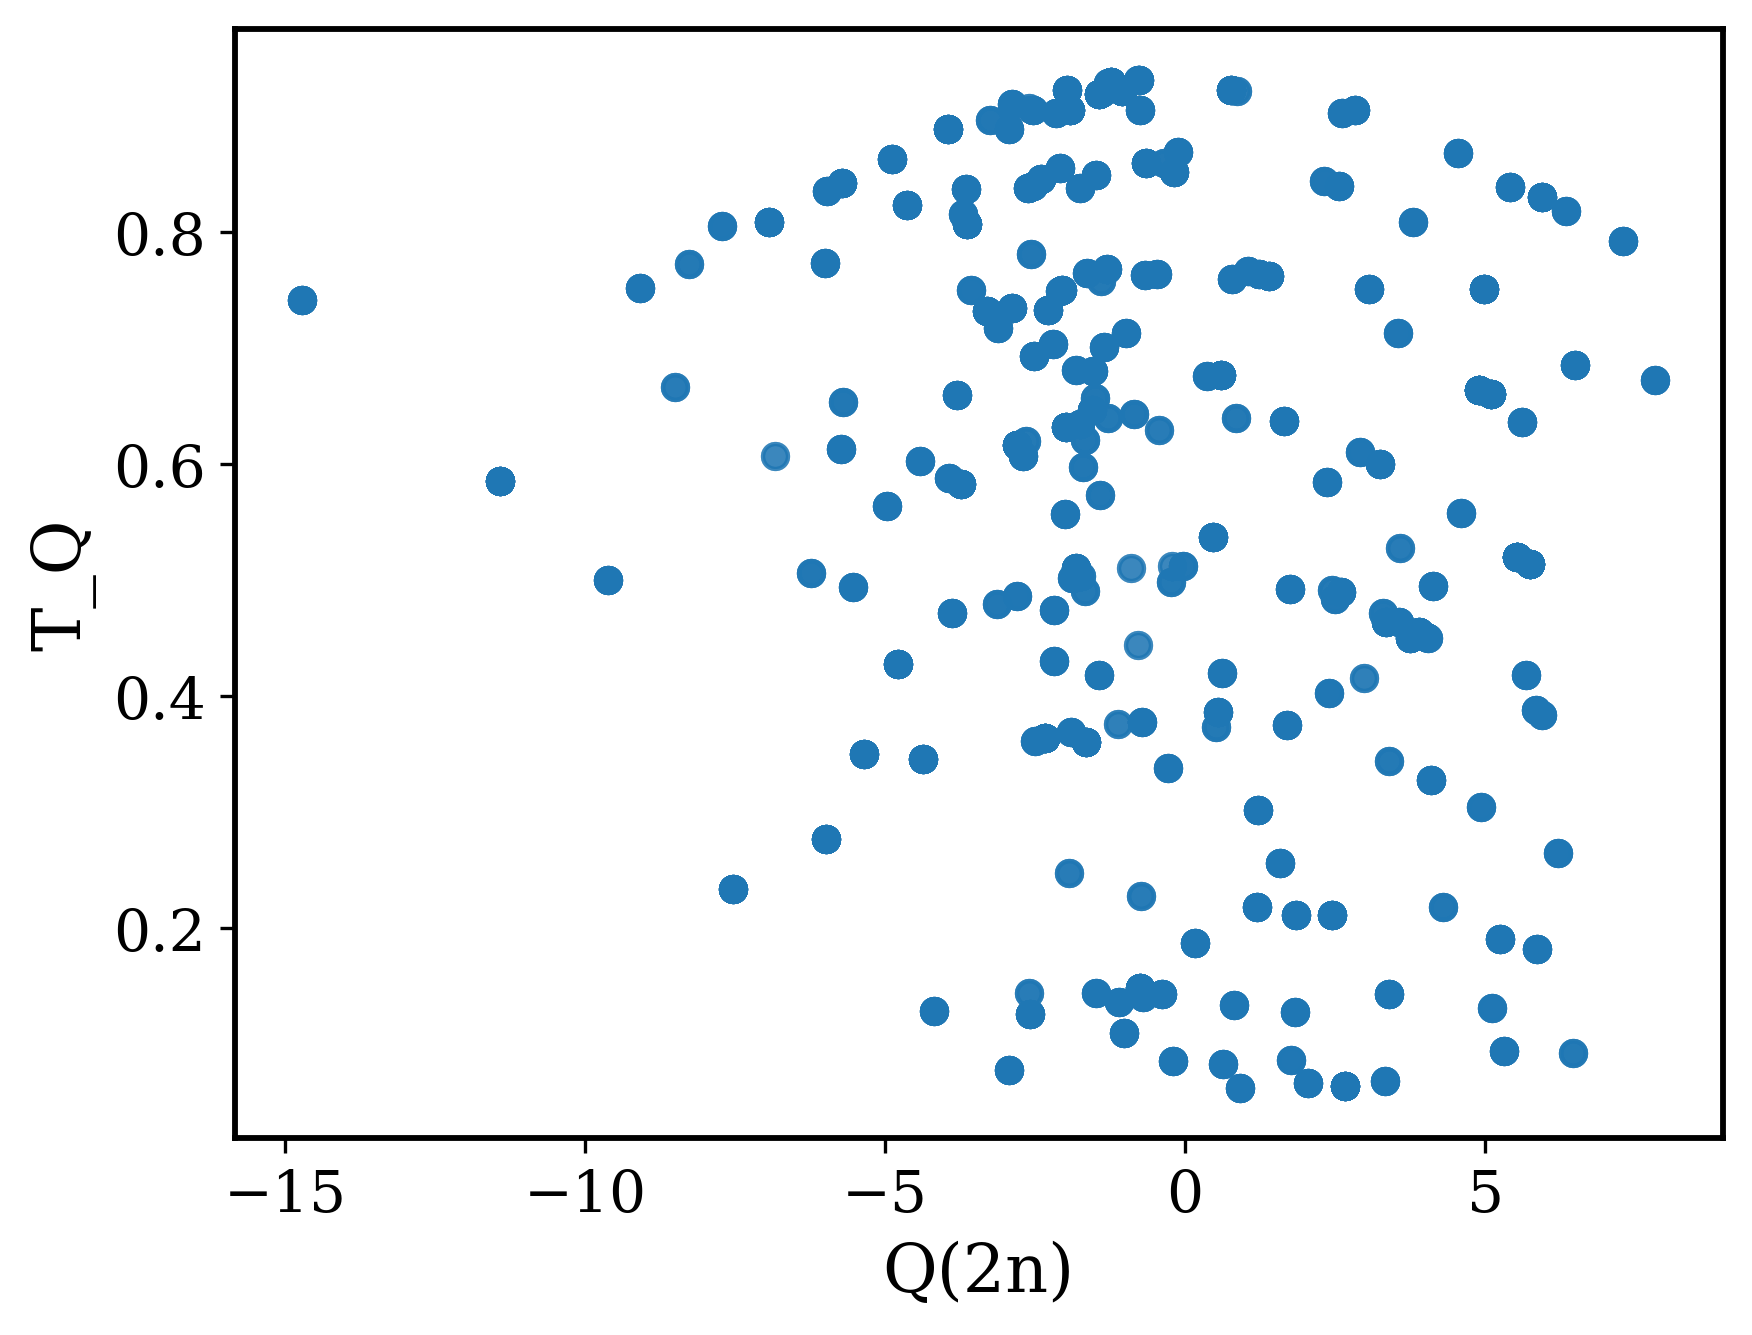

In [35]:
plt.scatter(df["Q ( 2 n )"], df["T_Q"], alpha=0.4)
plt.xlabel("Q(2n)")
plt.ylabel("T_Q")
plt.show()


In [36]:
df.to_csv("fusion_with_TQ.csv", index=False)


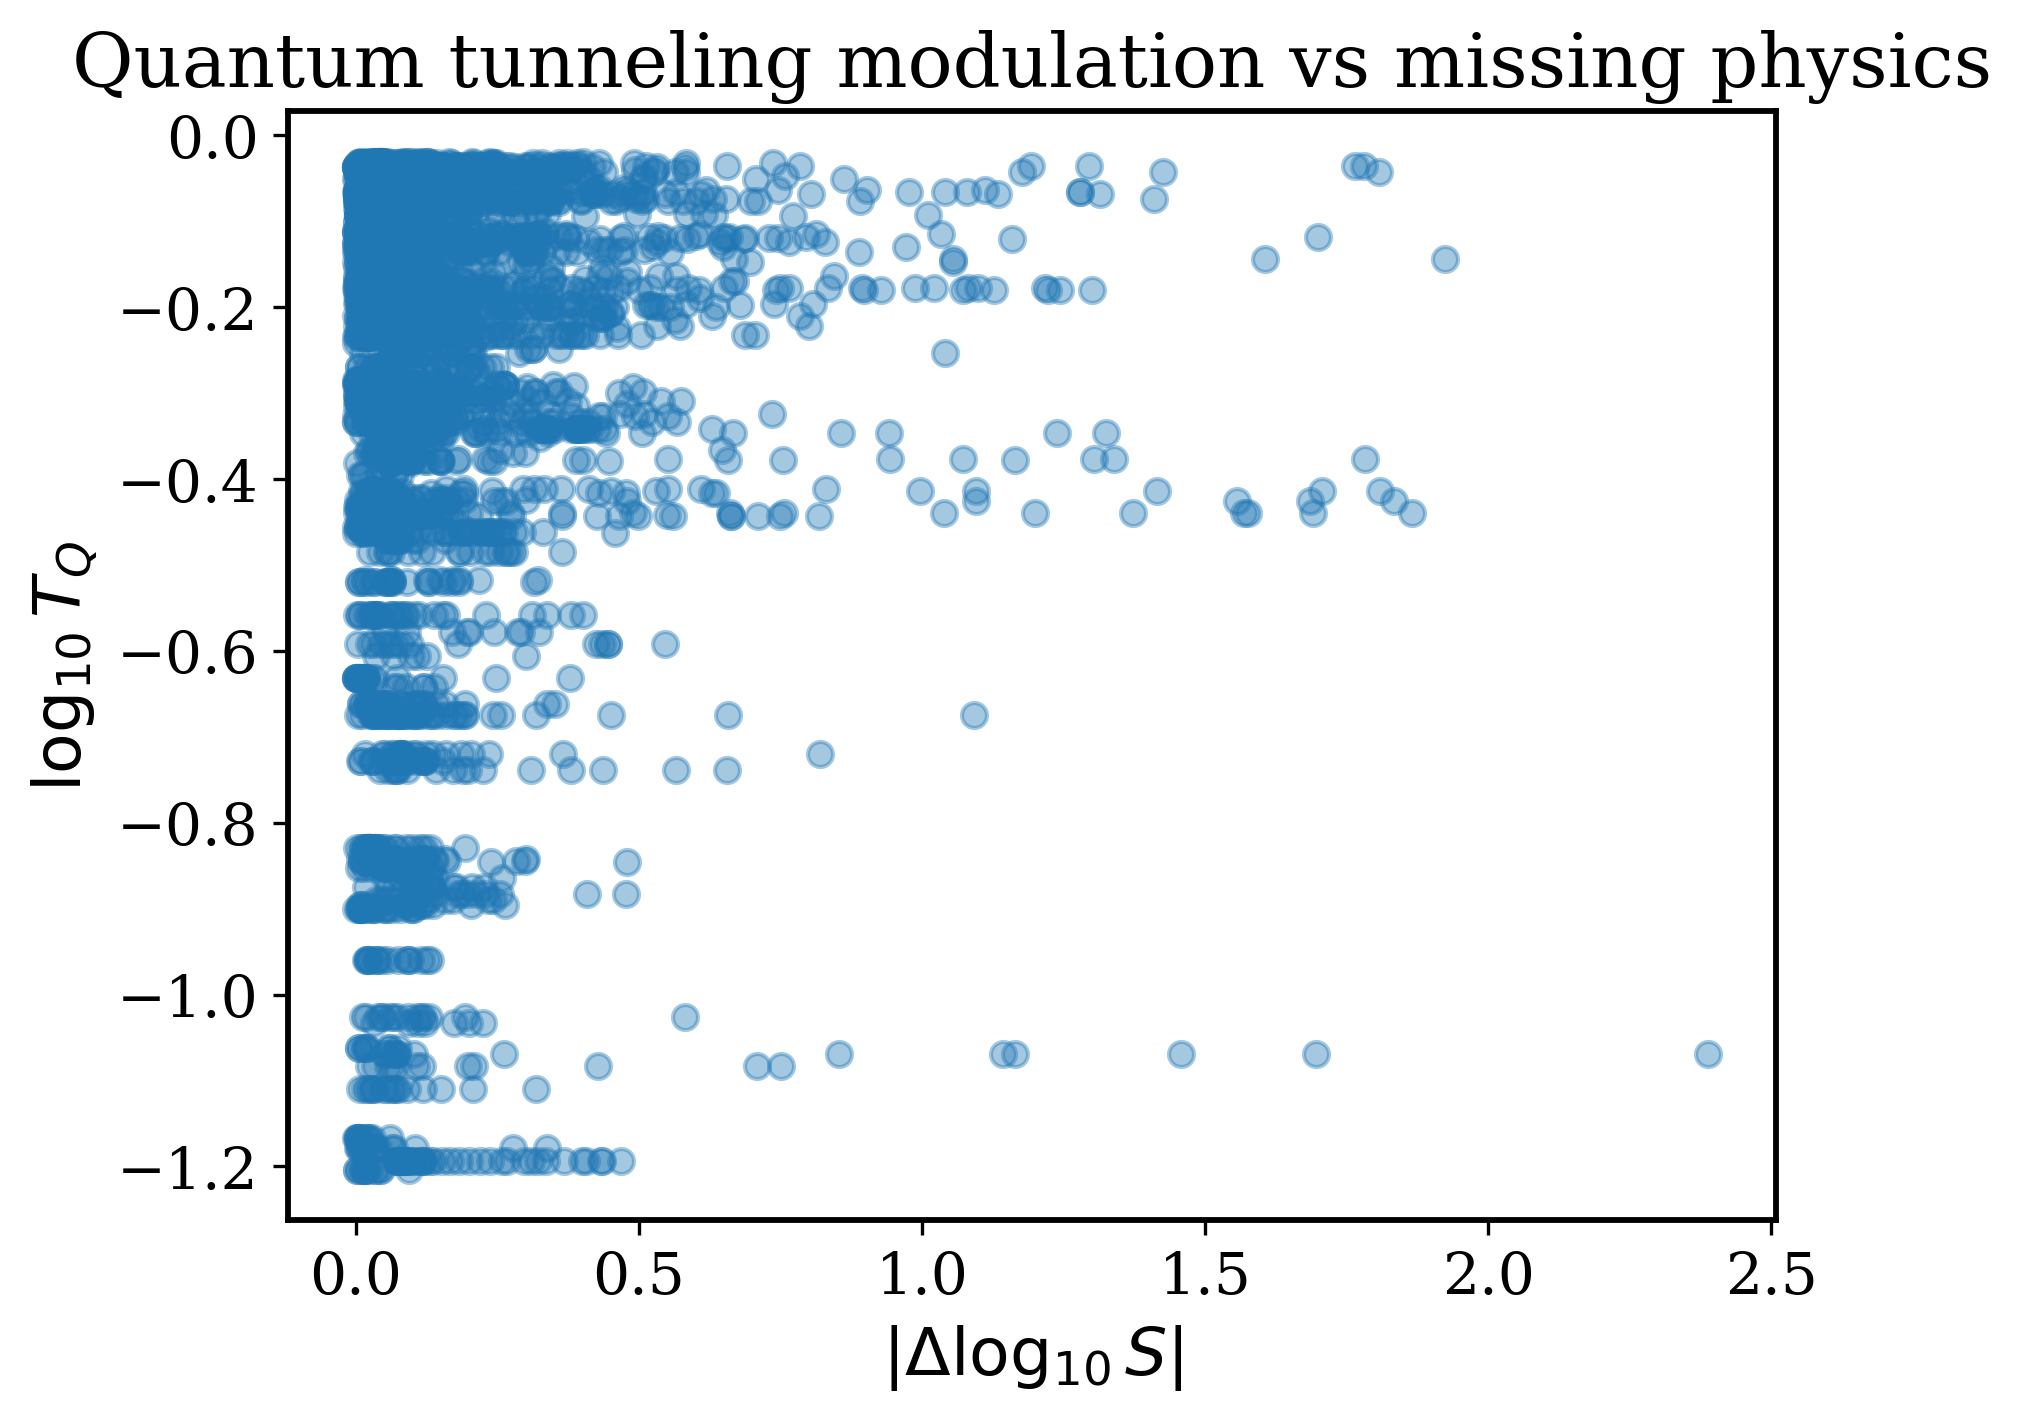

In [37]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(
    df["delta_log10_S"].abs(),
    np.log10(df["T_Q"] + 1e-8),
    alpha=0.4
)
plt.xlabel(r"$|\Delta \log_{10} S|$")
plt.ylabel(r"$\log_{10} T_Q$")
plt.title("Quantum tunneling modulation vs missing physics")
plt.show()


In [40]:
import numpy as np
import os

EN_DIR = "mdn_70_10_20_optimized/ensembles_fast"
SEEDS = [42 + i for i in range(10)]

pi_list = []

for s in SEEDS:
    path = os.path.join(EN_DIR, f"seed_{s}", "mdn_all_components.npz")
    data = np.load(path)
    pi_list.append(data["pi"])   # (N, K)

pi_ens = np.mean(np.stack(pi_list, axis=0), axis=0)  # (N, K)


In [41]:
regime_label = pi_ens.argmax(axis=1)   # (N,)


In [42]:
df["regime_label"] = regime_label


In [43]:
df["regime_label"].value_counts()


regime_label
1    3106
0     191
2     126
3     102
4       7
Name: count, dtype: int64

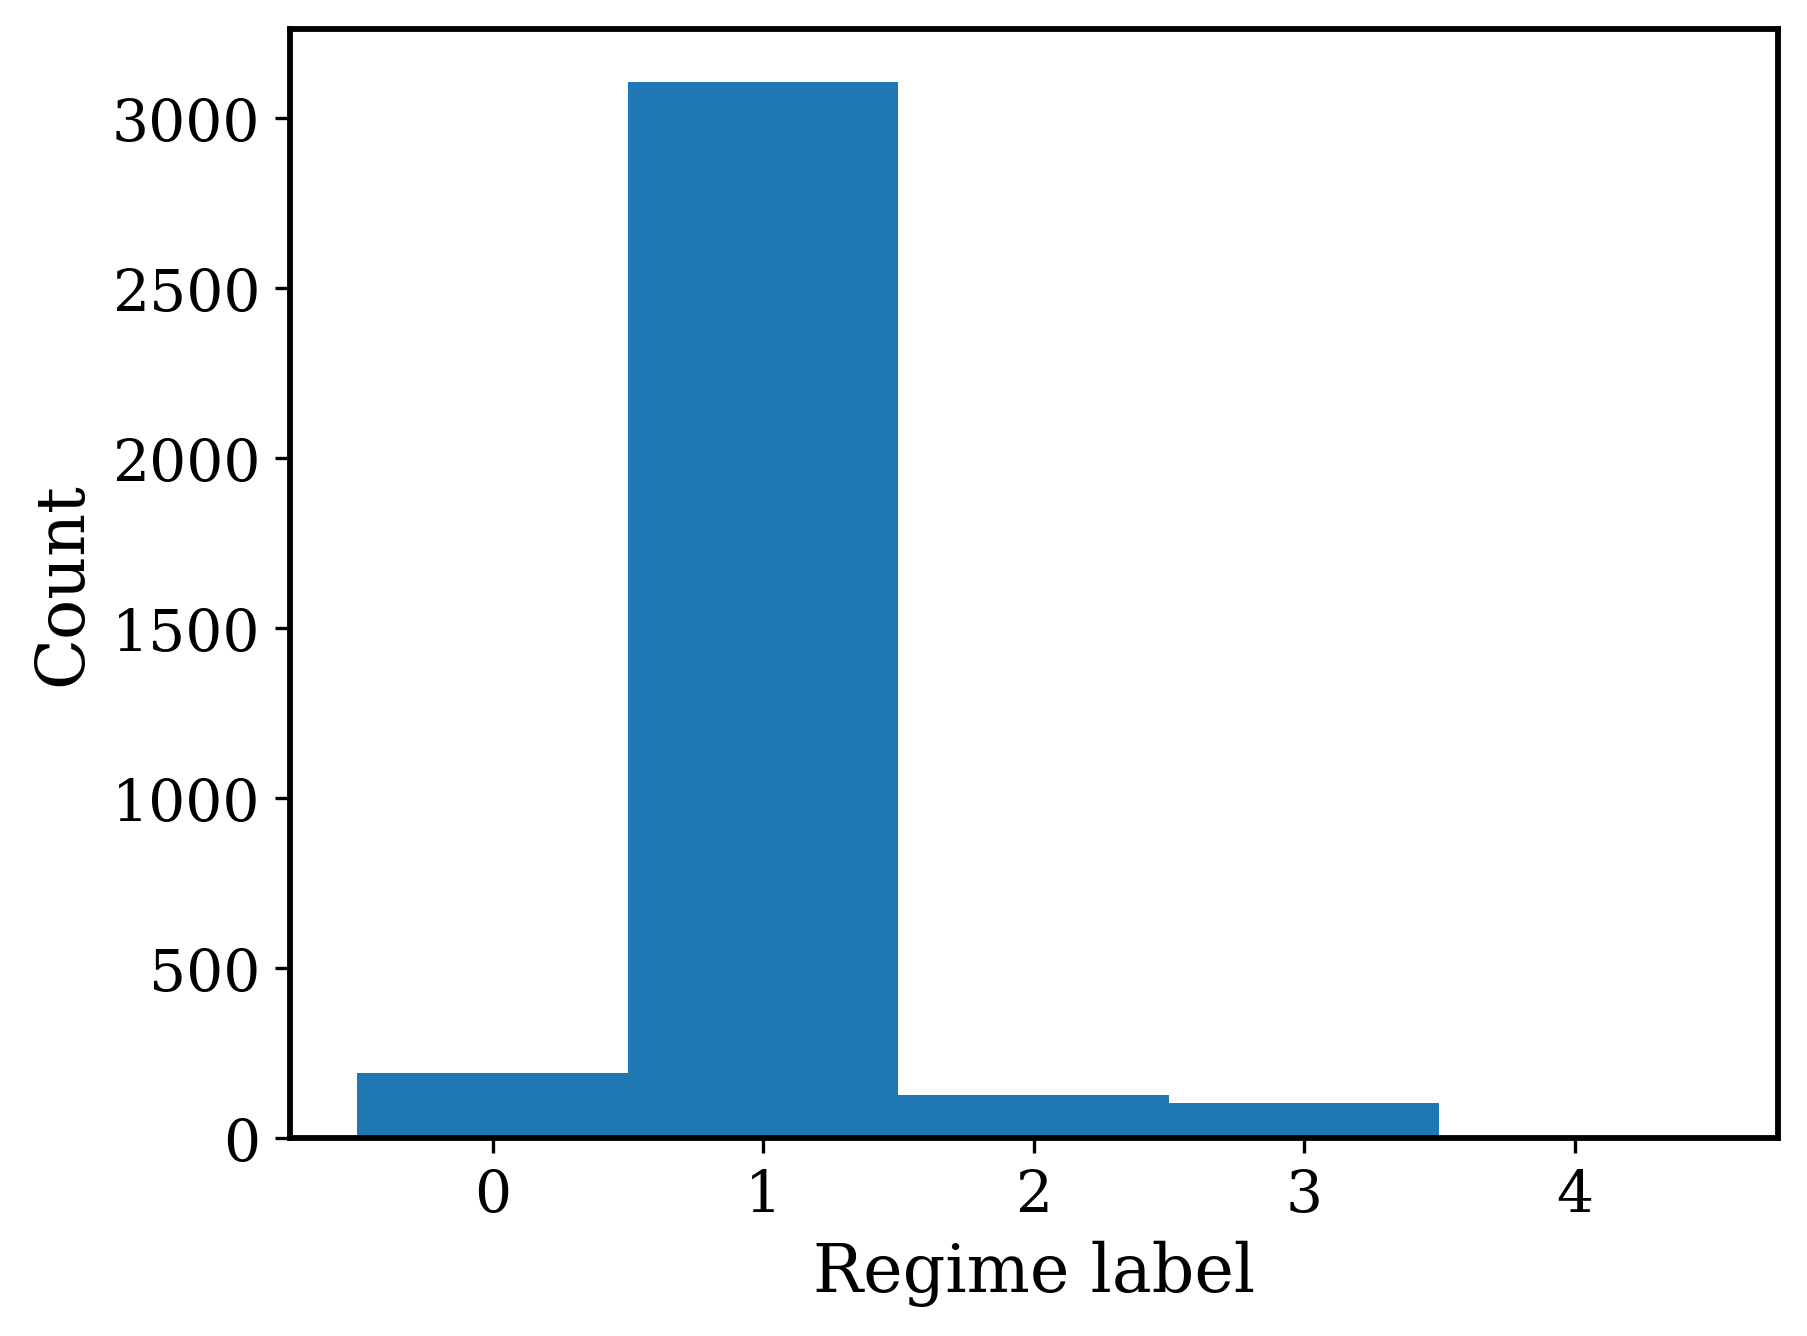

In [44]:
import matplotlib.pyplot as plt

plt.hist(df["regime_label"], bins=np.arange(6)-0.5)
plt.xlabel("Regime label")
plt.ylabel("Count")
plt.show()


In [45]:
df.groupby("regime_label")["logTQ"].mean()
df.groupby("regime_label")["logTQ"].std()


regime_label
0    0.255063
1    0.288392
2    0.245163
3    0.261191
4    0.031000
Name: logTQ, dtype: float32

<Axes: xlabel='regime_label', ylabel='logTQ'>

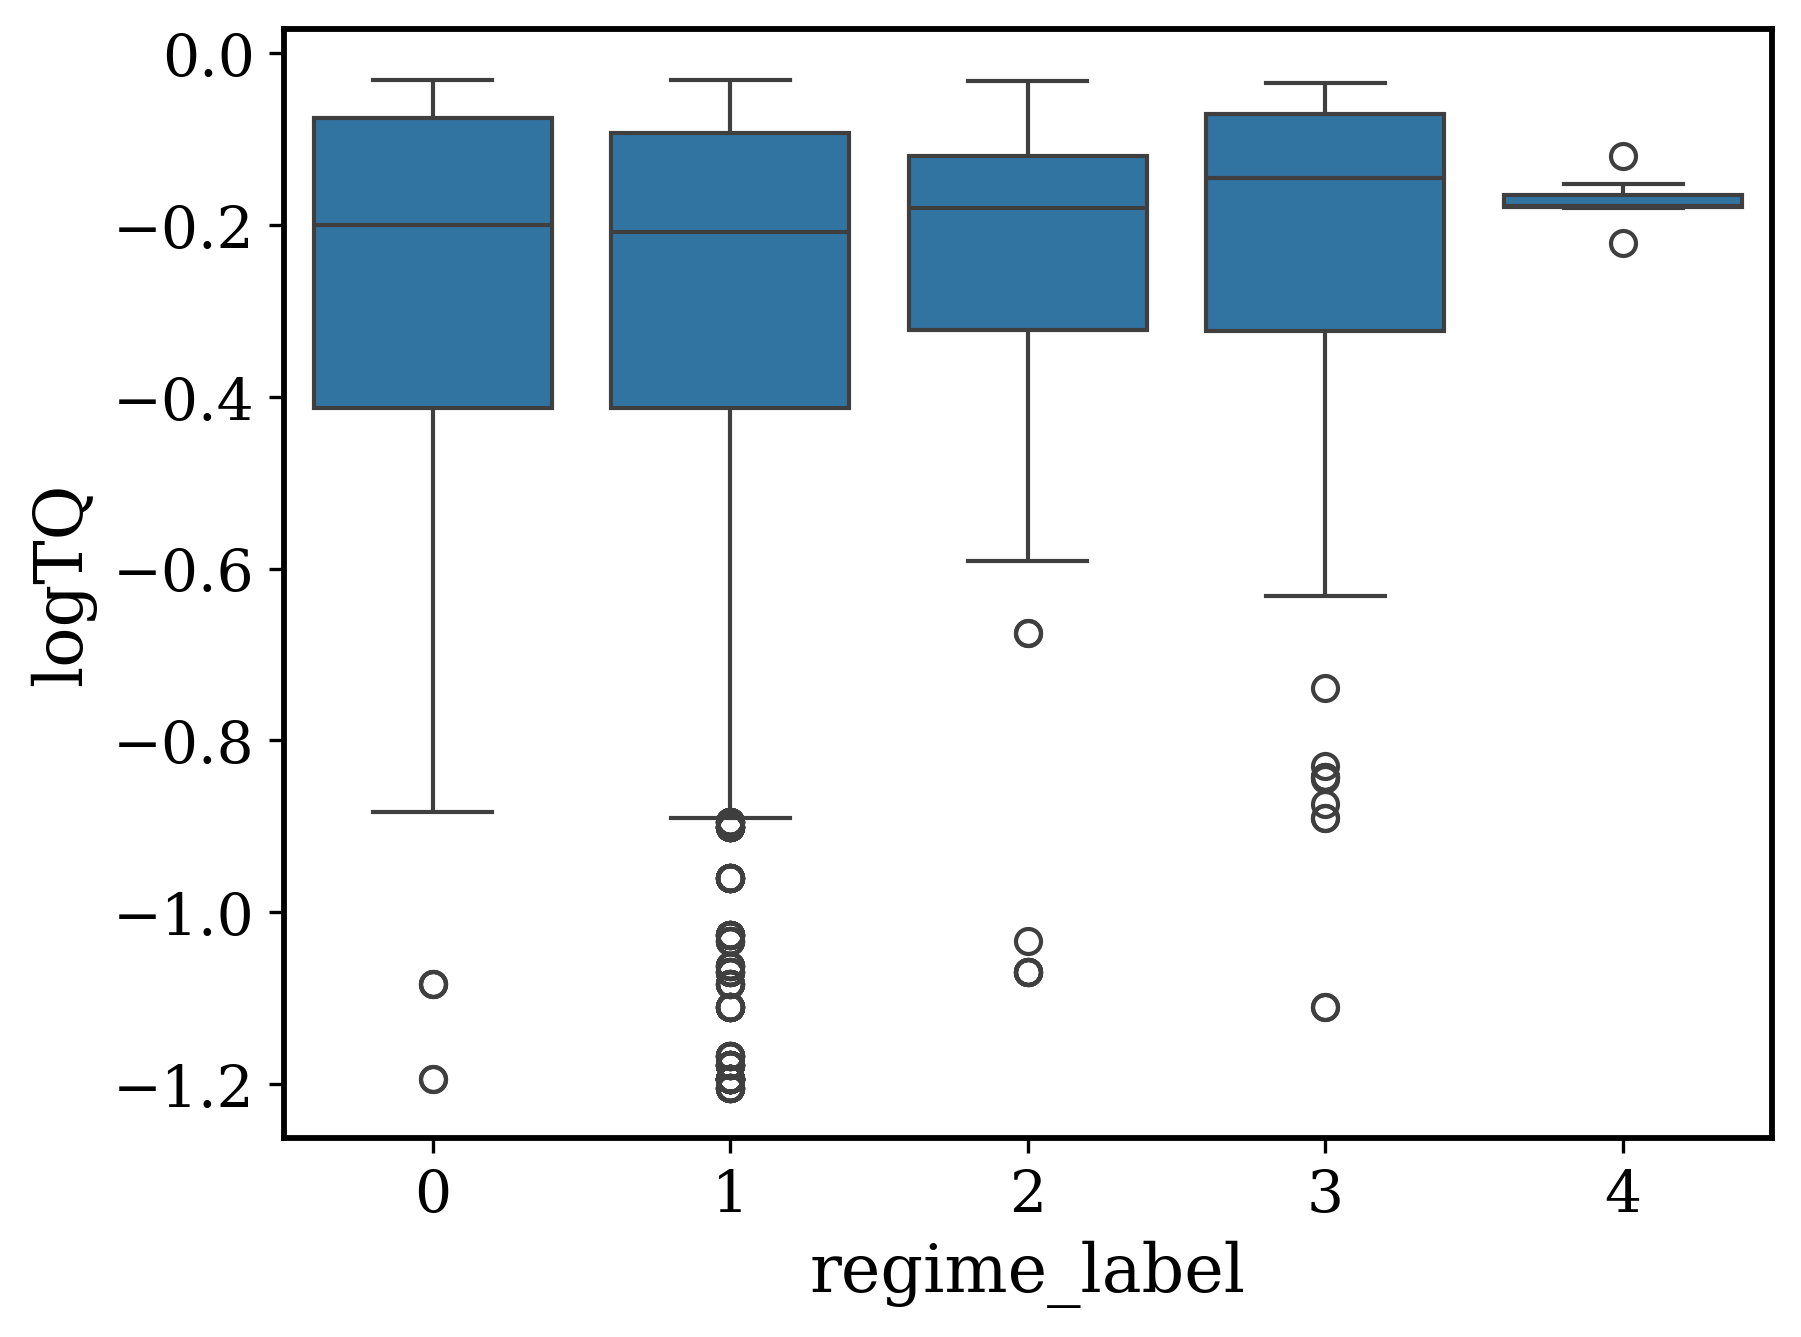

In [46]:
import seaborn as sns
sns.boxplot(x="regime_label", y="logTQ", data=df)


In [47]:
df.groupby("regime_label")["logTQ"].agg(["mean","std","count"])


mean       std  count
regime_label                           
0            -0.274718  0.255063    191
1            -0.307988  0.288392   3106
2            -0.260976  0.245163    126
3            -0.250852  0.261191    102
4            -0.172669  0.031000      7

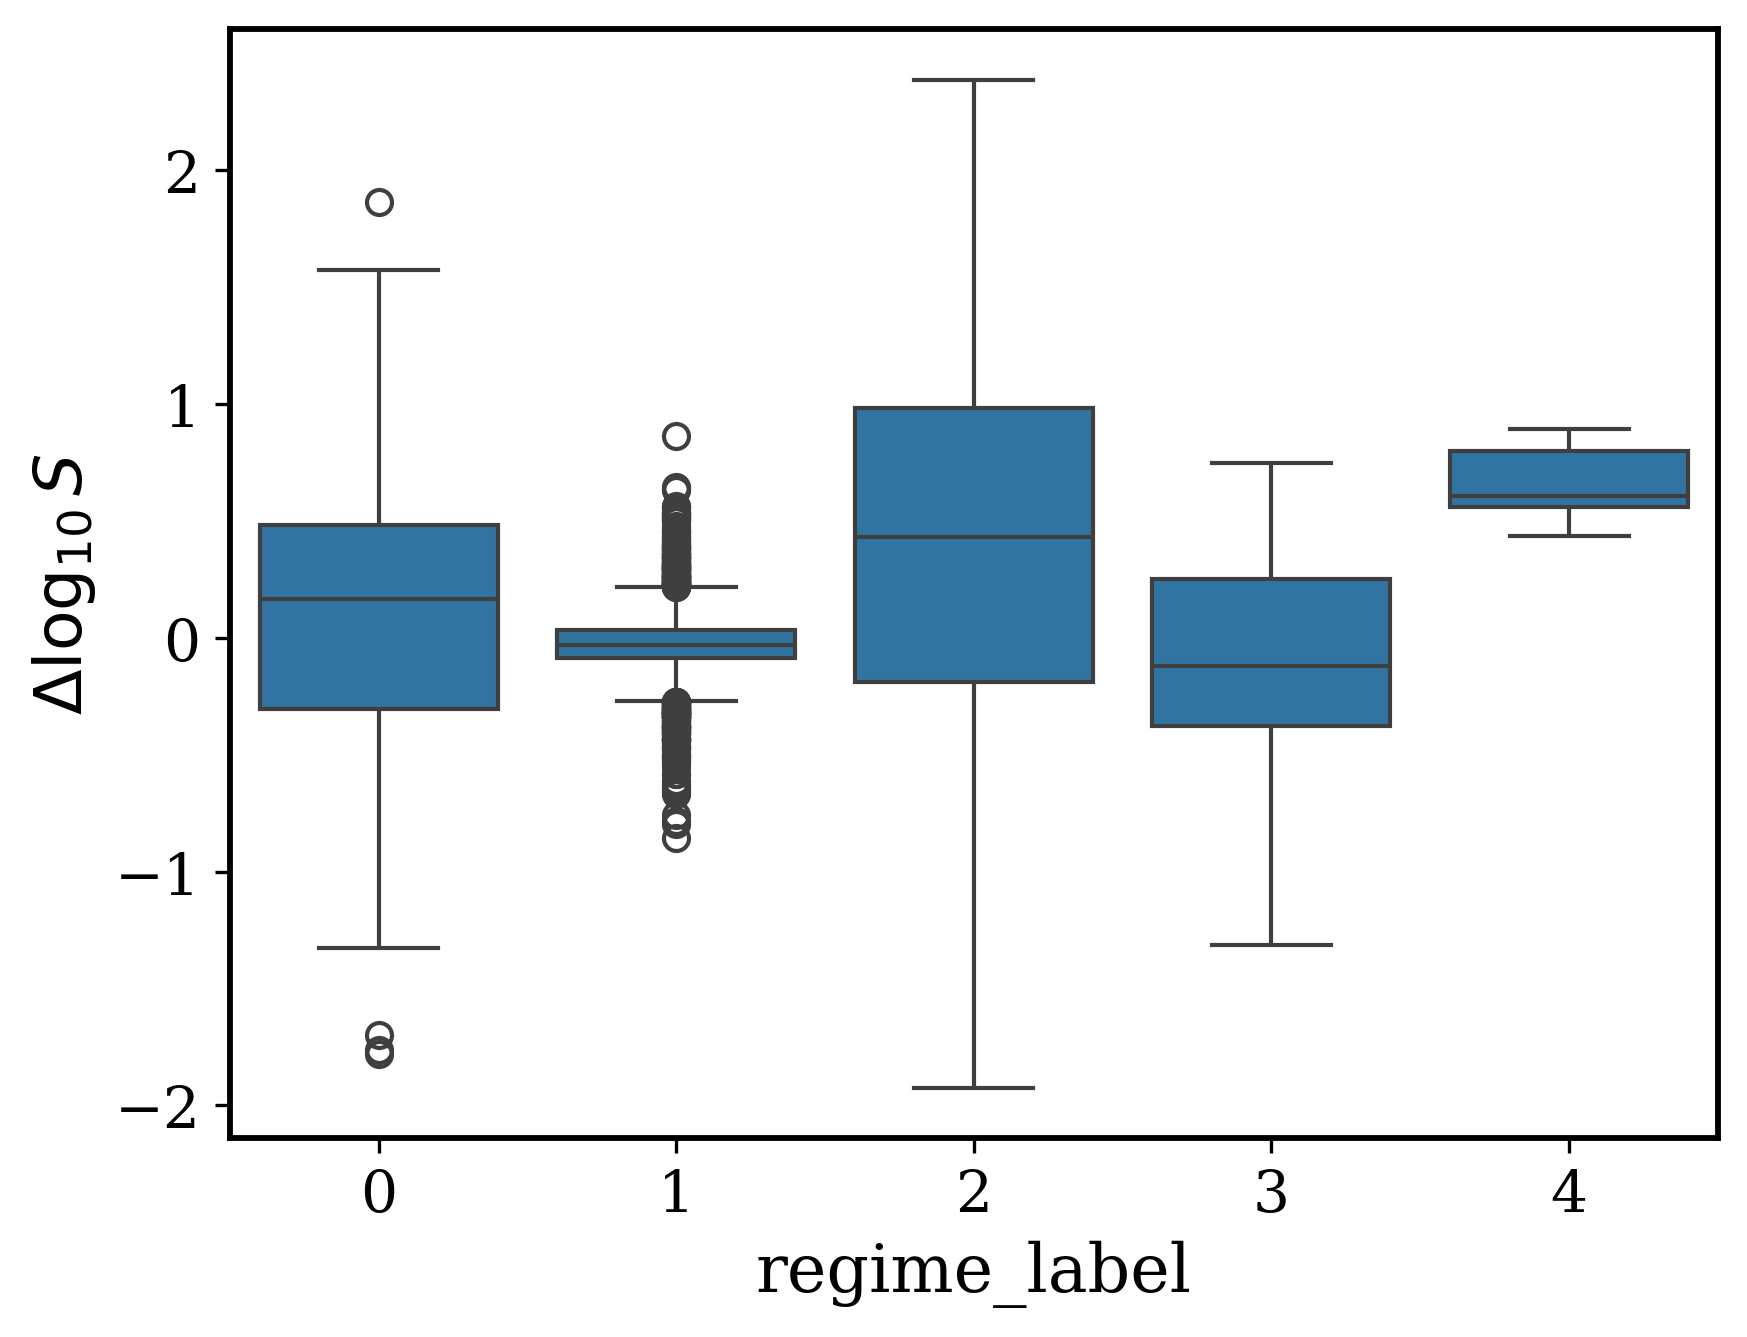

In [48]:
import seaborn as sns

sns.boxplot(
    x="regime_label",
    y="delta_log10_S",
    data=df
)
plt.ylabel(r"$\Delta \log_{10} S$")
plt.show()
